##### Copyright 2023 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

## Import required libraries

In [2]:
import os
#os.environ['PYTHONPATH'] += ":/path/to/models"
import io
import json
import tqdm
import shutil
import pprint
import pathlib
import tempfile
import requests
import collections
import matplotlib
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from PIL import Image
from six import BytesIO
from etils import epath
from IPython import display
from urllib.request import urlopen

2024-11-07 18:57:45.127634: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-07 18:57:45.145122: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-07 18:57:45.150557: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-07 18:57:45.167490: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-07 18:57:49.275885: W tensorflow/compiler/tf2

In [3]:
import orbit
import tensorflow as tf
import tensorflow_models as tfm
import tensorflow_datasets as tfds

from official.core import exp_factory
from official.core import config_definitions as cfg
from official.vision.data import tfrecord_lib
from official.vision.serving import export_saved_model_lib
from official.vision.dataloaders.tf_example_decoder import TfExampleDecoder
from official.vision.utils.object_detection import visualization_utils
from official.vision.ops.preprocess_ops import normalize_image, resize_and_crop_image
from official.vision.data.create_coco_tf_record import coco_annotations_to_lists

pp = pprint.PrettyPrinter(indent=4) # Set Pretty Print Indentation
print(tf.__version__) # Check the version of tensorflow used

%matplotlib inline

2.17.0


In [4]:
# @title Lvis annotation parsing

def get_category_map(annotation_path, num_classes):
  with epath.Path(annotation_path).open() as f:
      data = json.load(f)

  category_map = {id+1: {'id': cat_dict['id'],
                       'name': cat_dict['name']}
                  for id, cat_dict in enumerate(data['categories'][:num_classes])}
  return category_map

class LvisAnnotation:
  """LVIS annotation helper class.
  The format of the annations is explained on
  https://www.lvisdataset.org/dataset.
  """

  def __init__(self, annotation_path):
    with epath.Path(annotation_path).open() as f:
      data = json.load(f)
    self._data = data

    img_id2annotations = collections.defaultdict(list)
    for a in self._data.get('annotations', []):
    #  if a['category_id'] in category_ids:
        img_id2annotations[a['image_id']].append(a)
    self._img_id2annotations = {
        k: list(sorted(v, key=lambda a: a['id']))
        for k, v in img_id2annotations.items()
    }

  @property
  def categories(self):
    """Return the category dicts, as sorted in the file."""
    return self._data['categories']

  @property
  def images(self):
    """Return the image dicts, as sorted in the file."""
    sub_images = []
    for image_info in self._data['images']:
      if image_info['id'] in self._img_id2annotations:
        sub_images.append(image_info)
    return sub_images

  def get_annotations(self, img_id):
    """Return all annotations associated with the image id string."""
    # Some images don't have any annotations. Return empty list instead.
    return self._img_id2annotations.get(img_id, [])

def _generate_tf_records(prefix, annotation_file, num_shards=5):
    """Generate TFRecords."""

    lvis_annotation = LvisAnnotation(annotation_file)

    def _process_example(prefix, image_info, id_to_name_map):
      # Search image dirs.
      filename = pathlib.Path(image_info['file_name']).name
      #print(IMGS_DIR+filename)

      #im = Image.open(IMGS_DIR+filename)
      #im.show()
        
      image = tf.io.read_file(os.path.join(IMGS_DIR, filename))
      instances = lvis_annotation.get_annotations(img_id=image_info['id'])
      instances = [x for x in instances if x['id']]
      # print([x['category_id'] for x in instances])
      is_crowd = {'iscrowd': 0}
      instances = [dict(x, **is_crowd) for x in instances]
      neg_category_ids = image_info.get('neg_category_ids', [])
      not_exhaustive_category_ids = image_info.get(
          'not_exhaustive_category_ids', []
      )
      data, _ = coco_annotations_to_lists(instances,
                                          id_to_name_map,
                                          image_info['height'],
                                          image_info['width'],
                                          include_masks=True)
        
      # data['category_id'] = [id-1 for id in data['category_id']]
      keys_to_features = {
          'image/encoded':
              tfrecord_lib.convert_to_feature(image.numpy()),
          'image/filename':
               tfrecord_lib.convert_to_feature(filename.encode('utf8')),
          'image/format':
              tfrecord_lib.convert_to_feature('jpg'.encode('utf8')),
          'image/height':
              tfrecord_lib.convert_to_feature(image_info['height']),
          'image/width':
              tfrecord_lib.convert_to_feature(image_info['width']),
          'image/source_id':
              tfrecord_lib.convert_to_feature(str(image_info['id']).encode('utf8')),
          'image/object/bbox/xmin':
              tfrecord_lib.convert_to_feature(data['xmin']),
          'image/object/bbox/xmax':
              tfrecord_lib.convert_to_feature(data['xmax']),
          'image/object/bbox/ymin':
              tfrecord_lib.convert_to_feature(data['ymin']),
          'image/object/bbox/ymax':
              tfrecord_lib.convert_to_feature(data['ymax']),
          'image/object/class/text':
              tfrecord_lib.convert_to_feature(data['category_names']),
          'image/object/class/label':
              tfrecord_lib.convert_to_feature(data['category_id']),
          'image/object/is_crowd':
              tfrecord_lib.convert_to_feature(data['is_crowd']),
          'image/object/area':
              tfrecord_lib.convert_to_feature(data['area'], 'float_list'),
          'image/object/mask':
              tfrecord_lib.convert_to_feature(data['encoded_mask_png'])
      }
      # print(keys_to_features['image/object/class/label'])
      example = tf.train.Example(
          features=tf.train.Features(feature=keys_to_features))
      return example
    
    #file_names = [f"{prefix}/{pathlib.Path(image_info['coco_url']).name}"
    #               for image_info in lvis_annotation.images]
    #_extract_images(images_zip, file_names)

    writers = [
        tf.io.TFRecordWriter(
            tf_records_dir + prefix +'-%05d-of-%05d.tfrecord' % (i, num_shards))
        for i in range(num_shards)
    ]
    id_to_name_map = {cat_dict['id']: cat_dict['name']
                      for cat_dict in lvis_annotation.categories[:NUM_CLASSES]}
    # print(id_to_name_map)
    
    for idx, image_info in enumerate(tqdm.tqdm(lvis_annotation.images)):
        
      #img_data = requests.get(image_info['coco_url'], stream=True).content
      #img_name = image_info['file_name']
      #with open(os.path.join(IMGS_DIR, img_name), 'wb') as handler:
      #    handler.write(img_data)
      tf_example = _process_example(prefix, image_info, id_to_name_map)
      writers[idx % num_shards].write(tf_example.SerializeToString())

    del lvis_annotation

In [5]:
train_prefix = 'train'
valid_prefix = 'val'

train_annotation_path = "/uscms/home/jennetd/nobackup/smart-pixels/instance-segmentation/alberts-data/generated-data-annotations/via_project_train_coco.json"
valid_annotation_path = "/uscms/home/jennetd/nobackup/smart-pixels/instance-segmentation/alberts-data/generated-data-annotations/via_project_val_coco.json"

IMGS_DIR = '/uscms/home/jennetd/nobackup/smart-pixels/instance-segmentation/alberts-data/'
tf_records_dir = '/uscms/home/jennetd/nobackup/smart-pixels/instance-segmentation/my_tfrecords/'


if not os.path.exists(IMGS_DIR):
  os.mkdir(IMGS_DIR)

if not os.path.exists(tf_records_dir):
  os.mkdir(tf_records_dir)

NUM_CLASSES = 3
category_index = get_category_map(valid_annotation_path, NUM_CLASSES)
#category_ids = list(category_index.keys())

In [6]:
# Below helper function are taken from github tensorflow dataset lvis
# https://github.com/tensorflow/datasets/blob/master/tensorflow_datasets/datasets/lvis/lvis_dataset_builder.py
_generate_tf_records(train_prefix,
                     train_annotation_path)

  0%|          | 0/100 [00:00<?, ?it/s]WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
I0000 00:00:1731005880.916165   58711 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1731005880.985846   58711 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1731005880.986937   58711 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testin

  3%|▎         | 81/2338 [00:35<15:26,  2.44it/s]

  4%|▎         | 82/2338 [00:35<14:31,  2.59it/s]

  4%|▎         | 83/2338 [00:36<13:51,  2.71it/s]

  4%|▎         | 84/2338 [00:36<12:58,  2.89it/s]

  4%|▎         | 85/2338 [00:37<14:10,  2.65it/s]

  4%|▎         | 86/2338 [00:37<14:27,  2.60it/s]

  4%|▎         | 87/2338 [00:37<14:49,  2.53it/s]

  4%|▍         | 88/2338 [00:38<15:22,  2.44it/s]

  4%|▍         | 89/2338 [00:38<14:47,  2.53it/s]

  4%|▍         | 90/2338 [00:39<15:45,  2.38it/s]

  4%|▍         | 91/2338 [00:39<16:16,  2.30it/s]

  4%|▍         | 92/2338 [00:40<15:58,  2.34it/s]

  4%|▍         | 93/2338 [00:40<16:26,  2.28it/s]

  4%|▍         | 94/2338 [00:40<15:53,  2.35it/s]

  4%|▍         | 95/2338 [00:41<18:59,  1.97it/s]

  4%|▍         | 96/2338 [00:41<16:36,  2.25it/s]

  4%|▍         | 97/2338 [00:42<16:21,  2.28it/s]

  4%|▍         | 98/2338 [00:42<16:01,  2.33it/s]

  4%|▍         | 99/2338 [00:43<16:11,  2.30it/s]

  4%|▍         | 100/2338 [00:43<16:05,  2.32it/s]

  4%|▍         | 101/2338 [00:43<14:41,  2.54it/s]

  4%|▍         | 102/2338 [00:44<14:22,  2.59it/s]

  4%|▍         | 103/2338 [00:44<14:43,  2.53it/s]

  4%|▍         | 104/2338 [00:45<15:03,  2.47it/s]

  4%|▍         | 105/2338 [00:45<14:56,  2.49it/s]

  5%|▍         | 106/2338 [00:45<15:28,  2.40it/s]

  5%|▍         | 107/2338 [00:46<15:30,  2.40it/s]

  5%|▍         | 108/2338 [00:46<15:45,  2.36it/s]

  5%|▍         | 109/2338 [00:47<15:15,  2.43it/s]

  5%|▍         | 110/2338 [00:47<15:43,  2.36it/s]

  5%|▍         | 111/2338 [00:48<15:47,  2.35it/s]

  5%|▍         | 112/2338 [00:48<15:31,  2.39it/s]

  5%|▍         | 113/2338 [00:48<15:16,  2.43it/s]

  5%|▍         | 114/2338 [00:49<14:11,  2.61it/s]

  5%|▍         | 115/2338 [00:49<14:46,  2.51it/s]

  5%|▍         | 116/2338 [00:50<15:41,  2.36it/s]

  5%|▌         | 117/2338 [00:50<14:39,  2.53it/s]

  5%|▌         | 118/2338 [00:50<14:58,  2.47it/s]

  5%|▌         | 119/2338 [00:51<14:25,  2.56it/s]

  5%|▌         | 120/2338 [00:51<15:24,  2.40it/s]

  5%|▌         | 121/2338 [00:52<14:51,  2.49it/s]

  5%|▌         | 122/2338 [00:52<15:12,  2.43it/s]

  5%|▌         | 123/2338 [00:52<14:58,  2.47it/s]

  5%|▌         | 124/2338 [00:53<15:37,  2.36it/s]

  5%|▌         | 125/2338 [00:53<15:15,  2.42it/s]

  5%|▌         | 126/2338 [00:54<14:53,  2.48it/s]

  5%|▌         | 127/2338 [00:54<15:15,  2.41it/s]

  5%|▌         | 128/2338 [00:54<14:42,  2.50it/s]

  6%|▌         | 129/2338 [00:55<14:36,  2.52it/s]

  6%|▌         | 130/2338 [00:55<14:37,  2.52it/s]

  6%|▌         | 131/2338 [00:56<14:05,  2.61it/s]

  6%|▌         | 132/2338 [00:56<14:15,  2.58it/s]

  6%|▌         | 133/2338 [00:56<14:29,  2.54it/s]

  6%|▌         | 134/2338 [00:57<13:50,  2.65it/s]

  6%|▌         | 135/2338 [00:57<14:04,  2.61it/s]

  6%|▌         | 136/2338 [00:58<15:29,  2.37it/s]

  6%|▌         | 137/2338 [00:58<15:12,  2.41it/s]

  6%|▌         | 138/2338 [00:59<15:48,  2.32it/s]

  6%|▌         | 139/2338 [00:59<15:56,  2.30it/s]

  6%|▌         | 140/2338 [00:59<15:40,  2.34it/s]

  6%|▌         | 141/2338 [01:00<15:33,  2.35it/s]

  6%|▌         | 142/2338 [01:00<15:42,  2.33it/s]

  6%|▌         | 143/2338 [01:01<15:24,  2.38it/s]

  6%|▌         | 144/2338 [01:01<16:24,  2.23it/s]

  6%|▌         | 145/2338 [01:02<16:00,  2.28it/s]

  6%|▌         | 146/2338 [01:02<14:23,  2.54it/s]

  6%|▋         | 147/2338 [01:02<13:56,  2.62it/s]

  6%|▋         | 148/2338 [01:03<14:56,  2.44it/s]

  6%|▋         | 149/2338 [01:03<15:14,  2.39it/s]

  6%|▋         | 150/2338 [01:04<15:29,  2.35it/s]

  6%|▋         | 151/2338 [01:04<16:08,  2.26it/s]

  7%|▋         | 152/2338 [01:04<15:55,  2.29it/s]

  7%|▋         | 153/2338 [01:05<15:14,  2.39it/s]

  7%|▋         | 154/2338 [01:05<15:15,  2.39it/s]

  7%|▋         | 155/2338 [01:06<14:58,  2.43it/s]

  7%|▋         | 156/2338 [01:06<15:02,  2.42it/s]

  7%|▋         | 157/2338 [01:06<14:48,  2.45it/s]

  7%|▋         | 158/2338 [01:07<14:18,  2.54it/s]

  7%|▋         | 159/2338 [01:07<13:41,  2.65it/s]

  7%|▋         | 160/2338 [01:07<13:07,  2.77it/s]

  7%|▋         | 161/2338 [01:08<13:19,  2.72it/s]

  7%|▋         | 162/2338 [01:08<12:59,  2.79it/s]

  7%|▋         | 163/2338 [01:09<12:31,  2.89it/s]

  7%|▋         | 164/2338 [01:09<13:12,  2.74it/s]

  7%|▋         | 165/2338 [01:09<13:33,  2.67it/s]

  7%|▋         | 166/2338 [01:10<13:59,  2.59it/s]

  7%|▋         | 167/2338 [01:10<14:19,  2.53it/s]

  7%|▋         | 168/2338 [01:11<15:07,  2.39it/s]

  7%|▋         | 169/2338 [01:11<15:04,  2.40it/s]

  7%|▋         | 170/2338 [01:12<15:40,  2.30it/s]

  7%|▋         | 171/2338 [01:12<14:45,  2.45it/s]

  7%|▋         | 172/2338 [01:12<14:45,  2.45it/s]

  7%|▋         | 173/2338 [01:13<15:04,  2.39it/s]

  7%|▋         | 174/2338 [01:13<16:22,  2.20it/s]

  7%|▋         | 175/2338 [01:14<15:43,  2.29it/s]

  8%|▊         | 176/2338 [01:14<15:33,  2.32it/s]

  8%|▊         | 177/2338 [01:14<15:30,  2.32it/s]

  8%|▊         | 178/2338 [01:15<15:29,  2.32it/s]

  8%|▊         | 179/2338 [01:15<14:44,  2.44it/s]

  8%|▊         | 180/2338 [01:16<13:24,  2.68it/s]

  8%|▊         | 181/2338 [01:16<13:55,  2.58it/s]

  8%|▊         | 182/2338 [01:16<14:28,  2.48it/s]

  8%|▊         | 183/2338 [01:17<14:29,  2.48it/s]

  8%|▊         | 184/2338 [01:17<15:02,  2.39it/s]

  8%|▊         | 185/2338 [01:18<15:11,  2.36it/s]

  8%|▊         | 186/2338 [01:18<15:19,  2.34it/s]

  8%|▊         | 187/2338 [01:19<15:00,  2.39it/s]

  8%|▊         | 188/2338 [01:19<15:14,  2.35it/s]

  8%|▊         | 189/2338 [01:19<15:05,  2.37it/s]

  8%|▊         | 190/2338 [01:20<14:40,  2.44it/s]

  8%|▊         | 191/2338 [01:20<14:33,  2.46it/s]

  8%|▊         | 192/2338 [01:21<15:04,  2.37it/s]

  8%|▊         | 193/2338 [01:21<15:23,  2.32it/s]

  8%|▊         | 194/2338 [01:21<14:29,  2.47it/s]

  8%|▊         | 195/2338 [01:22<14:30,  2.46it/s]

  8%|▊         | 196/2338 [01:22<14:11,  2.51it/s]

  8%|▊         | 197/2338 [01:23<13:11,  2.70it/s]

  8%|▊         | 198/2338 [01:23<14:04,  2.53it/s]

  9%|▊         | 199/2338 [01:23<14:15,  2.50it/s]

  9%|▊         | 200/2338 [01:24<12:23,  2.88it/s]

  9%|▊         | 201/2338 [01:24<12:43,  2.80it/s]

  9%|▊         | 202/2338 [01:24<13:14,  2.69it/s]

  9%|▊         | 203/2338 [01:25<13:41,  2.60it/s]

  9%|▊         | 204/2338 [01:25<14:04,  2.53it/s]

  9%|▉         | 205/2338 [01:26<14:07,  2.52it/s]

  9%|▉         | 206/2338 [01:26<14:00,  2.54it/s]

  9%|▉         | 207/2338 [01:26<14:18,  2.48it/s]

  9%|▉         | 208/2338 [01:27<13:48,  2.57it/s]

  9%|▉         | 209/2338 [01:27<13:57,  2.54it/s]

  9%|▉         | 210/2338 [01:28<13:38,  2.60it/s]

  9%|▉         | 211/2338 [01:28<13:54,  2.55it/s]

  9%|▉         | 212/2338 [01:28<14:03,  2.52it/s]

  9%|▉         | 213/2338 [01:29<14:20,  2.47it/s]

  9%|▉         | 214/2338 [01:29<13:08,  2.69it/s]

  9%|▉         | 215/2338 [01:30<13:20,  2.65it/s]

  9%|▉         | 216/2338 [01:30<13:37,  2.60it/s]

  9%|▉         | 217/2338 [01:30<13:20,  2.65it/s]

  9%|▉         | 218/2338 [01:31<13:52,  2.55it/s]

  9%|▉         | 219/2338 [01:31<13:12,  2.67it/s]

  9%|▉         | 220/2338 [01:31<13:47,  2.56it/s]

  9%|▉         | 221/2338 [01:32<14:32,  2.43it/s]

  9%|▉         | 222/2338 [01:32<14:58,  2.36it/s]

 10%|▉         | 223/2338 [01:33<15:59,  2.20it/s]

 10%|▉         | 224/2338 [01:33<15:50,  2.23it/s]

 10%|▉         | 225/2338 [01:34<15:39,  2.25it/s]

 10%|▉         | 226/2338 [01:34<15:09,  2.32it/s]

 10%|▉         | 227/2338 [01:35<15:18,  2.30it/s]

 10%|▉         | 228/2338 [01:35<15:14,  2.31it/s]

 10%|▉         | 229/2338 [01:35<14:53,  2.36it/s]

 10%|▉         | 230/2338 [01:36<15:07,  2.32it/s]

 10%|▉         | 231/2338 [01:36<15:09,  2.32it/s]

 10%|▉         | 232/2338 [01:37<15:29,  2.27it/s]

 10%|▉         | 233/2338 [01:37<14:06,  2.49it/s]

 10%|█         | 234/2338 [01:37<12:55,  2.71it/s]

 10%|█         | 235/2338 [01:38<13:42,  2.56it/s]

 10%|█         | 236/2338 [01:38<13:56,  2.51it/s]

 10%|█         | 237/2338 [01:39<13:23,  2.62it/s]

 10%|█         | 238/2338 [01:39<12:23,  2.83it/s]

 10%|█         | 239/2338 [01:39<12:04,  2.90it/s]

 10%|█         | 240/2338 [01:40<12:31,  2.79it/s]

 10%|█         | 241/2338 [01:40<12:36,  2.77it/s]

 10%|█         | 242/2338 [01:40<12:55,  2.70it/s]

 10%|█         | 243/2338 [01:41<13:26,  2.60it/s]

 10%|█         | 244/2338 [01:41<14:02,  2.49it/s]

 10%|█         | 245/2338 [01:42<14:35,  2.39it/s]

 11%|█         | 246/2338 [01:42<13:29,  2.58it/s]

 11%|█         | 247/2338 [01:42<14:02,  2.48it/s]

 11%|█         | 248/2338 [01:43<14:07,  2.46it/s]

 11%|█         | 249/2338 [01:43<13:39,  2.55it/s]

 11%|█         | 250/2338 [01:44<14:12,  2.45it/s]

 11%|█         | 251/2338 [01:44<13:23,  2.60it/s]

 11%|█         | 252/2338 [01:44<13:10,  2.64it/s]

 11%|█         | 253/2338 [01:45<13:00,  2.67it/s]

 11%|█         | 254/2338 [01:45<12:58,  2.68it/s]

 11%|█         | 255/2338 [01:45<13:27,  2.58it/s]

 11%|█         | 256/2338 [01:46<13:49,  2.51it/s]

 11%|█         | 257/2338 [01:46<13:47,  2.51it/s]

 11%|█         | 258/2338 [01:47<14:10,  2.45it/s]

 11%|█         | 259/2338 [01:47<13:52,  2.50it/s]

 11%|█         | 260/2338 [01:48<14:28,  2.39it/s]

 11%|█         | 261/2338 [01:48<14:18,  2.42it/s]

 11%|█         | 262/2338 [01:48<13:51,  2.50it/s]

 11%|█         | 263/2338 [01:49<14:09,  2.44it/s]

 11%|█▏        | 264/2338 [01:49<14:25,  2.40it/s]

 11%|█▏        | 265/2338 [01:50<14:25,  2.39it/s]

 11%|█▏        | 266/2338 [01:50<14:00,  2.47it/s]

 11%|█▏        | 267/2338 [01:50<14:03,  2.45it/s]

 11%|█▏        | 268/2338 [01:51<14:35,  2.37it/s]

 12%|█▏        | 269/2338 [01:51<14:30,  2.38it/s]

 12%|█▏        | 270/2338 [01:52<15:24,  2.24it/s]

 12%|█▏        | 271/2338 [01:52<15:26,  2.23it/s]

 12%|█▏        | 272/2338 [01:53<15:17,  2.25it/s]

 12%|█▏        | 273/2338 [01:53<14:32,  2.37it/s]

 12%|█▏        | 274/2338 [01:53<14:21,  2.39it/s]

 12%|█▏        | 275/2338 [01:54<14:49,  2.32it/s]

 12%|█▏        | 276/2338 [01:54<14:37,  2.35it/s]

 12%|█▏        | 277/2338 [01:55<14:28,  2.37it/s]

 12%|█▏        | 278/2338 [01:55<14:28,  2.37it/s]

 12%|█▏        | 279/2338 [01:56<14:40,  2.34it/s]

 12%|█▏        | 280/2338 [01:56<15:10,  2.26it/s]

 12%|█▏        | 281/2338 [01:57<15:29,  2.21it/s]

 12%|█▏        | 282/2338 [01:57<15:18,  2.24it/s]

 12%|█▏        | 283/2338 [01:58<15:47,  2.17it/s]

 12%|█▏        | 284/2338 [01:58<14:17,  2.39it/s]

 12%|█▏        | 285/2338 [01:58<14:18,  2.39it/s]

 12%|█▏        | 286/2338 [01:59<14:16,  2.40it/s]

 12%|█▏        | 287/2338 [01:59<13:49,  2.47it/s]

 12%|█▏        | 288/2338 [01:59<14:21,  2.38it/s]

 12%|█▏        | 289/2338 [02:00<13:58,  2.44it/s]

 12%|█▏        | 290/2338 [02:00<14:48,  2.31it/s]

 12%|█▏        | 291/2338 [02:01<14:14,  2.40it/s]

 12%|█▏        | 292/2338 [02:01<13:31,  2.52it/s]

 13%|█▎        | 293/2338 [02:01<13:25,  2.54it/s]

 13%|█▎        | 294/2338 [02:02<13:35,  2.51it/s]

 13%|█▎        | 295/2338 [02:02<13:59,  2.43it/s]

 13%|█▎        | 296/2338 [02:03<14:07,  2.41it/s]

 13%|█▎        | 297/2338 [02:03<14:06,  2.41it/s]

 13%|█▎        | 298/2338 [02:04<13:33,  2.51it/s]

 13%|█▎        | 299/2338 [02:04<13:42,  2.48it/s]

 13%|█▎        | 300/2338 [02:04<13:26,  2.53it/s]

 13%|█▎        | 301/2338 [02:05<13:40,  2.48it/s]

 13%|█▎        | 302/2338 [02:05<13:44,  2.47it/s]

 13%|█▎        | 303/2338 [02:06<13:54,  2.44it/s]

 13%|█▎        | 304/2338 [02:06<14:06,  2.40it/s]

 13%|█▎        | 305/2338 [02:06<14:11,  2.39it/s]

 13%|█▎        | 306/2338 [02:07<13:43,  2.47it/s]

 13%|█▎        | 307/2338 [02:07<13:36,  2.49it/s]

 13%|█▎        | 308/2338 [02:08<12:54,  2.62it/s]

 13%|█▎        | 309/2338 [02:08<12:57,  2.61it/s]

 13%|█▎        | 310/2338 [02:08<13:25,  2.52it/s]

 13%|█▎        | 311/2338 [02:09<13:45,  2.46it/s]

 13%|█▎        | 312/2338 [02:09<13:52,  2.43it/s]

 13%|█▎        | 313/2338 [02:10<13:36,  2.48it/s]

 13%|█▎        | 314/2338 [02:10<13:51,  2.44it/s]

 13%|█▎        | 315/2338 [02:10<14:22,  2.35it/s]

 14%|█▎        | 316/2338 [02:11<14:31,  2.32it/s]

 14%|█▎        | 317/2338 [02:11<14:37,  2.30it/s]

 14%|█▎        | 318/2338 [02:12<14:56,  2.25it/s]

 14%|█▎        | 319/2338 [02:12<14:36,  2.30it/s]

 14%|█▎        | 320/2338 [02:13<14:31,  2.32it/s]

 14%|█▎        | 321/2338 [02:13<14:00,  2.40it/s]

 14%|█▍        | 322/2338 [02:13<13:49,  2.43it/s]

 14%|█▍        | 323/2338 [02:14<13:55,  2.41it/s]

 14%|█▍        | 324/2338 [02:14<15:10,  2.21it/s]

 14%|█▍        | 325/2338 [02:15<14:49,  2.26it/s]

 14%|█▍        | 326/2338 [02:15<14:06,  2.38it/s]

 14%|█▍        | 327/2338 [02:16<13:34,  2.47it/s]

 14%|█▍        | 328/2338 [02:16<13:39,  2.45it/s]

 14%|█▍        | 329/2338 [02:16<13:51,  2.42it/s]

 14%|█▍        | 330/2338 [02:17<13:17,  2.52it/s]

 14%|█▍        | 331/2338 [02:17<13:11,  2.53it/s]

 14%|█▍        | 332/2338 [02:17<12:05,  2.76it/s]

 14%|█▍        | 333/2338 [02:18<12:02,  2.77it/s]

 14%|█▍        | 334/2338 [02:18<12:46,  2.61it/s]

 14%|█▍        | 335/2338 [02:19<13:08,  2.54it/s]

 14%|█▍        | 336/2338 [02:19<13:21,  2.50it/s]

 14%|█▍        | 337/2338 [02:19<13:25,  2.48it/s]

 14%|█▍        | 338/2338 [02:20<14:02,  2.37it/s]

 14%|█▍        | 339/2338 [02:20<14:35,  2.28it/s]

 15%|█▍        | 340/2338 [02:21<13:08,  2.53it/s]

 15%|█▍        | 341/2338 [02:21<13:09,  2.53it/s]

 15%|█▍        | 342/2338 [02:22<13:49,  2.41it/s]

 15%|█▍        | 343/2338 [02:22<13:53,  2.39it/s]

 15%|█▍        | 344/2338 [02:22<13:53,  2.39it/s]

 15%|█▍        | 345/2338 [02:23<13:46,  2.41it/s]

 15%|█▍        | 346/2338 [02:23<14:10,  2.34it/s]

 15%|█▍        | 347/2338 [02:24<14:39,  2.26it/s]

 15%|█▍        | 348/2338 [02:24<13:17,  2.50it/s]

 15%|█▍        | 349/2338 [02:24<12:32,  2.64it/s]

 15%|█▍        | 350/2338 [02:25<12:10,  2.72it/s]

 15%|█▌        | 351/2338 [02:25<11:32,  2.87it/s]

 15%|█▌        | 352/2338 [02:25<11:21,  2.92it/s]

 15%|█▌        | 353/2338 [02:26<10:42,  3.09it/s]

 15%|█▌        | 354/2338 [02:26<13:48,  2.40it/s]

 15%|█▌        | 355/2338 [02:27<13:28,  2.45it/s]

 15%|█▌        | 356/2338 [02:27<12:44,  2.59it/s]

 15%|█▌        | 357/2338 [02:27<12:40,  2.60it/s]

 15%|█▌        | 358/2338 [02:28<12:56,  2.55it/s]

 15%|█▌        | 359/2338 [02:28<13:19,  2.48it/s]

 15%|█▌        | 360/2338 [02:29<13:41,  2.41it/s]

 15%|█▌        | 361/2338 [02:29<13:30,  2.44it/s]

 15%|█▌        | 362/2338 [02:29<13:10,  2.50it/s]

 16%|█▌        | 363/2338 [02:30<12:56,  2.54it/s]

 16%|█▌        | 364/2338 [02:30<12:20,  2.67it/s]

 16%|█▌        | 365/2338 [02:31<12:35,  2.61it/s]

 16%|█▌        | 366/2338 [02:31<13:24,  2.45it/s]

 16%|█▌        | 367/2338 [02:31<13:25,  2.45it/s]

 16%|█▌        | 368/2338 [02:32<13:05,  2.51it/s]

 16%|█▌        | 369/2338 [02:32<13:03,  2.51it/s]

 16%|█▌        | 370/2338 [02:33<13:15,  2.47it/s]

 16%|█▌        | 371/2338 [02:33<13:47,  2.38it/s]

 16%|█▌        | 372/2338 [02:34<14:01,  2.34it/s]

 16%|█▌        | 373/2338 [02:34<12:19,  2.66it/s]

 16%|█▌        | 374/2338 [02:34<12:25,  2.63it/s]

 16%|█▌        | 375/2338 [02:35<12:52,  2.54it/s]

 16%|█▌        | 376/2338 [02:35<12:56,  2.53it/s]

 16%|█▌        | 377/2338 [02:35<13:07,  2.49it/s]

 16%|█▌        | 378/2338 [02:36<13:58,  2.34it/s]

 16%|█▌        | 379/2338 [02:36<14:09,  2.31it/s]

 16%|█▋        | 380/2338 [02:37<14:11,  2.30it/s]

 16%|█▋        | 381/2338 [02:37<13:54,  2.35it/s]

 16%|█▋        | 382/2338 [02:38<13:29,  2.42it/s]

 16%|█▋        | 383/2338 [02:38<12:04,  2.70it/s]

 16%|█▋        | 384/2338 [02:38<11:09,  2.92it/s]

 16%|█▋        | 385/2338 [02:38<11:29,  2.83it/s]

 17%|█▋        | 386/2338 [02:39<12:02,  2.70it/s]

 17%|█▋        | 387/2338 [02:39<12:42,  2.56it/s]

 17%|█▋        | 388/2338 [02:40<13:23,  2.43it/s]

 17%|█▋        | 389/2338 [02:40<14:19,  2.27it/s]

 17%|█▋        | 390/2338 [02:41<13:16,  2.45it/s]

 17%|█▋        | 391/2338 [02:41<12:18,  2.64it/s]

 17%|█▋        | 392/2338 [02:41<12:37,  2.57it/s]

 17%|█▋        | 393/2338 [02:42<12:11,  2.66it/s]

 17%|█▋        | 394/2338 [02:42<12:11,  2.66it/s]

 17%|█▋        | 395/2338 [02:42<11:27,  2.83it/s]

 17%|█▋        | 396/2338 [02:43<12:40,  2.55it/s]

 17%|█▋        | 397/2338 [02:43<13:05,  2.47it/s]

 17%|█▋        | 398/2338 [02:44<14:13,  2.27it/s]

 17%|█▋        | 399/2338 [02:44<13:52,  2.33it/s]

 17%|█▋        | 400/2338 [02:45<13:27,  2.40it/s]

 17%|█▋        | 401/2338 [02:45<12:25,  2.60it/s]

 17%|█▋        | 402/2338 [02:45<12:43,  2.54it/s]

 17%|█▋        | 403/2338 [02:46<13:30,  2.39it/s]

 17%|█▋        | 404/2338 [02:46<13:46,  2.34it/s]

 17%|█▋        | 405/2338 [02:47<13:39,  2.36it/s]

 17%|█▋        | 406/2338 [02:47<13:29,  2.39it/s]

 17%|█▋        | 407/2338 [02:48<14:09,  2.27it/s]

 17%|█▋        | 408/2338 [02:48<13:37,  2.36it/s]

 17%|█▋        | 409/2338 [02:48<13:39,  2.35it/s]

 18%|█▊        | 410/2338 [02:49<13:26,  2.39it/s]

 18%|█▊        | 411/2338 [02:49<12:46,  2.51it/s]

 18%|█▊        | 412/2338 [02:50<13:07,  2.45it/s]

 18%|█▊        | 413/2338 [02:50<13:13,  2.42it/s]

 18%|█▊        | 414/2338 [02:50<13:03,  2.46it/s]

 18%|█▊        | 415/2338 [02:51<12:14,  2.62it/s]

 18%|█▊        | 416/2338 [02:51<12:25,  2.58it/s]

 18%|█▊        | 417/2338 [02:52<12:40,  2.52it/s]

 18%|█▊        | 418/2338 [02:52<13:24,  2.39it/s]

 18%|█▊        | 419/2338 [02:52<13:46,  2.32it/s]

 18%|█▊        | 420/2338 [02:53<13:15,  2.41it/s]

 18%|█▊        | 421/2338 [02:53<13:11,  2.42it/s]

 18%|█▊        | 422/2338 [02:54<12:53,  2.48it/s]

 18%|█▊        | 423/2338 [02:54<12:47,  2.49it/s]

 18%|█▊        | 424/2338 [02:54<11:45,  2.71it/s]

 18%|█▊        | 425/2338 [02:55<12:16,  2.60it/s]

 18%|█▊        | 426/2338 [02:55<11:38,  2.74it/s]

 18%|█▊        | 427/2338 [02:55<11:53,  2.68it/s]

 18%|█▊        | 428/2338 [02:56<11:34,  2.75it/s]

 18%|█▊        | 429/2338 [02:56<11:44,  2.71it/s]

 18%|█▊        | 430/2338 [02:57<15:14,  2.09it/s]

 18%|█▊        | 431/2338 [02:57<14:26,  2.20it/s]

 18%|█▊        | 432/2338 [02:58<14:11,  2.24it/s]

 19%|█▊        | 433/2338 [02:58<13:56,  2.28it/s]

 19%|█▊        | 434/2338 [02:59<13:52,  2.29it/s]

 19%|█▊        | 435/2338 [02:59<13:51,  2.29it/s]

 19%|█▊        | 436/2338 [02:59<13:50,  2.29it/s]

 19%|█▊        | 437/2338 [03:00<14:06,  2.25it/s]

 19%|█▊        | 438/2338 [03:00<14:07,  2.24it/s]

 19%|█▉        | 439/2338 [03:01<14:19,  2.21it/s]

 19%|█▉        | 440/2338 [03:01<13:48,  2.29it/s]

 19%|█▉        | 441/2338 [03:02<13:09,  2.40it/s]

 19%|█▉        | 442/2338 [03:02<12:53,  2.45it/s]

 19%|█▉        | 443/2338 [03:02<12:44,  2.48it/s]

 19%|█▉        | 444/2338 [03:03<13:01,  2.42it/s]

 19%|█▉        | 445/2338 [03:03<12:59,  2.43it/s]

 19%|█▉        | 446/2338 [03:04<12:54,  2.44it/s]

 19%|█▉        | 447/2338 [03:04<13:18,  2.37it/s]

 19%|█▉        | 448/2338 [03:04<12:02,  2.62it/s]

 19%|█▉        | 449/2338 [03:05<12:02,  2.62it/s]

 19%|█▉        | 450/2338 [03:05<12:24,  2.54it/s]

 19%|█▉        | 451/2338 [03:06<12:31,  2.51it/s]

 19%|█▉        | 452/2338 [03:06<11:57,  2.63it/s]

 19%|█▉        | 453/2338 [03:06<12:21,  2.54it/s]

 19%|█▉        | 454/2338 [03:07<12:28,  2.52it/s]

 19%|█▉        | 455/2338 [03:07<12:09,  2.58it/s]

 20%|█▉        | 456/2338 [03:07<11:10,  2.81it/s]

 20%|█▉        | 457/2338 [03:08<11:29,  2.73it/s]

 20%|█▉        | 458/2338 [03:08<11:46,  2.66it/s]

 20%|█▉        | 459/2338 [03:09<12:04,  2.60it/s]

 20%|█▉        | 460/2338 [03:09<12:37,  2.48it/s]

 20%|█▉        | 461/2338 [03:09<12:47,  2.45it/s]

 20%|█▉        | 462/2338 [03:10<13:31,  2.31it/s]

 20%|█▉        | 463/2338 [03:10<13:32,  2.31it/s]

 20%|█▉        | 464/2338 [03:11<13:09,  2.37it/s]

 20%|█▉        | 465/2338 [03:11<12:55,  2.41it/s]

 20%|█▉        | 466/2338 [03:12<12:55,  2.42it/s]

 20%|█▉        | 467/2338 [03:12<12:44,  2.45it/s]

 20%|██        | 468/2338 [03:12<12:05,  2.58it/s]

 20%|██        | 469/2338 [03:13<12:19,  2.53it/s]

 20%|██        | 470/2338 [03:13<12:28,  2.50it/s]

 20%|██        | 471/2338 [03:14<12:32,  2.48it/s]

 20%|██        | 472/2338 [03:14<13:01,  2.39it/s]

 20%|██        | 473/2338 [03:14<12:09,  2.56it/s]

 20%|██        | 474/2338 [03:15<12:49,  2.42it/s]

 20%|██        | 475/2338 [03:15<12:31,  2.48it/s]

 20%|██        | 476/2338 [03:16<12:33,  2.47it/s]

 20%|██        | 477/2338 [03:16<12:28,  2.49it/s]

 20%|██        | 478/2338 [03:16<12:37,  2.46it/s]

 20%|██        | 479/2338 [03:17<12:40,  2.44it/s]

 21%|██        | 480/2338 [03:17<12:19,  2.51it/s]

 21%|██        | 481/2338 [03:18<12:17,  2.52it/s]

 21%|██        | 482/2338 [03:18<13:24,  2.31it/s]

 21%|██        | 483/2338 [03:19<13:10,  2.35it/s]

 21%|██        | 484/2338 [03:19<12:27,  2.48it/s]

 21%|██        | 485/2338 [03:19<12:40,  2.44it/s]

 21%|██        | 486/2338 [03:20<12:05,  2.55it/s]

 21%|██        | 487/2338 [03:20<12:06,  2.55it/s]

 21%|██        | 488/2338 [03:20<11:25,  2.70it/s]

 21%|██        | 489/2338 [03:21<11:14,  2.74it/s]

 21%|██        | 490/2338 [03:21<11:25,  2.70it/s]

 21%|██        | 491/2338 [03:22<11:49,  2.60it/s]

 21%|██        | 492/2338 [03:22<11:53,  2.59it/s]

 21%|██        | 493/2338 [03:23<15:27,  1.99it/s]

 21%|██        | 494/2338 [03:23<13:41,  2.25it/s]

 21%|██        | 495/2338 [03:23<13:43,  2.24it/s]

 21%|██        | 496/2338 [03:24<14:26,  2.13it/s]

 21%|██▏       | 497/2338 [03:24<14:45,  2.08it/s]

 21%|██▏       | 498/2338 [03:25<13:09,  2.33it/s]

 21%|██▏       | 499/2338 [03:25<12:52,  2.38it/s]

 21%|██▏       | 500/2338 [03:26<12:56,  2.37it/s]

 21%|██▏       | 501/2338 [03:26<12:18,  2.49it/s]

 21%|██▏       | 502/2338 [03:26<12:22,  2.47it/s]

 22%|██▏       | 503/2338 [03:27<11:50,  2.58it/s]

 22%|██▏       | 504/2338 [03:27<12:27,  2.45it/s]

 22%|██▏       | 505/2338 [03:28<13:00,  2.35it/s]

 22%|██▏       | 506/2338 [03:28<12:59,  2.35it/s]

 22%|██▏       | 507/2338 [03:29<13:02,  2.34it/s]

 22%|██▏       | 508/2338 [03:29<13:23,  2.28it/s]

 22%|██▏       | 509/2338 [03:30<14:15,  2.14it/s]

 22%|██▏       | 510/2338 [03:30<13:47,  2.21it/s]

 22%|██▏       | 511/2338 [03:30<13:29,  2.26it/s]

 22%|██▏       | 512/2338 [03:31<13:18,  2.29it/s]

 22%|██▏       | 513/2338 [03:31<14:20,  2.12it/s]

 22%|██▏       | 514/2338 [03:32<13:28,  2.25it/s]

 22%|██▏       | 515/2338 [03:32<13:13,  2.30it/s]

 22%|██▏       | 516/2338 [03:33<15:58,  1.90it/s]

 22%|██▏       | 517/2338 [03:33<15:05,  2.01it/s]

 22%|██▏       | 518/2338 [03:34<14:35,  2.08it/s]

 22%|██▏       | 519/2338 [03:34<13:26,  2.26it/s]

 22%|██▏       | 520/2338 [03:35<13:12,  2.30it/s]

 22%|██▏       | 521/2338 [03:35<13:03,  2.32it/s]

 22%|██▏       | 522/2338 [03:35<12:55,  2.34it/s]

 22%|██▏       | 523/2338 [03:36<13:02,  2.32it/s]

 22%|██▏       | 524/2338 [03:36<13:00,  2.32it/s]

 22%|██▏       | 525/2338 [03:37<12:40,  2.38it/s]

 22%|██▏       | 526/2338 [03:37<12:27,  2.42it/s]

 23%|██▎       | 527/2338 [03:37<11:55,  2.53it/s]

 23%|██▎       | 528/2338 [03:38<11:43,  2.57it/s]

 23%|██▎       | 529/2338 [03:38<12:02,  2.50it/s]

 23%|██▎       | 530/2338 [03:39<12:09,  2.48it/s]

 23%|██▎       | 531/2338 [03:39<11:38,  2.59it/s]

 23%|██▎       | 532/2338 [03:39<10:19,  2.91it/s]

 23%|██▎       | 533/2338 [03:39<10:09,  2.96it/s]

 23%|██▎       | 534/2338 [03:40<10:08,  2.96it/s]

 23%|██▎       | 535/2338 [03:40<10:47,  2.78it/s]

 23%|██▎       | 536/2338 [03:41<10:42,  2.81it/s]

 23%|██▎       | 537/2338 [03:41<10:57,  2.74it/s]

 23%|██▎       | 538/2338 [03:41<11:49,  2.54it/s]

 23%|██▎       | 539/2338 [03:42<12:29,  2.40it/s]

 23%|██▎       | 540/2338 [03:42<12:19,  2.43it/s]

 23%|██▎       | 541/2338 [03:43<12:14,  2.45it/s]

 23%|██▎       | 542/2338 [03:43<11:40,  2.56it/s]

 23%|██▎       | 543/2338 [03:43<11:28,  2.61it/s]

 23%|██▎       | 544/2338 [03:44<11:41,  2.56it/s]

 23%|██▎       | 545/2338 [03:44<12:26,  2.40it/s]

 23%|██▎       | 546/2338 [03:45<12:32,  2.38it/s]

 23%|██▎       | 547/2338 [03:45<12:25,  2.40it/s]

 23%|██▎       | 548/2338 [03:45<11:58,  2.49it/s]

 23%|██▎       | 549/2338 [03:46<11:59,  2.49it/s]

 24%|██▎       | 550/2338 [03:46<11:58,  2.49it/s]

 24%|██▎       | 551/2338 [03:47<12:24,  2.40it/s]

 24%|██▎       | 552/2338 [03:47<11:57,  2.49it/s]

 24%|██▎       | 553/2338 [03:48<11:52,  2.51it/s]

 24%|██▎       | 554/2338 [03:48<11:50,  2.51it/s]

 24%|██▎       | 555/2338 [03:48<12:10,  2.44it/s]

 24%|██▍       | 556/2338 [03:49<12:54,  2.30it/s]

 24%|██▍       | 557/2338 [03:49<12:10,  2.44it/s]

 24%|██▍       | 558/2338 [03:49<10:57,  2.71it/s]

 24%|██▍       | 559/2338 [03:50<11:25,  2.59it/s]

 24%|██▍       | 560/2338 [03:50<12:32,  2.36it/s]

 24%|██▍       | 561/2338 [03:51<11:45,  2.52it/s]

 24%|██▍       | 562/2338 [03:51<12:46,  2.32it/s]

 24%|██▍       | 563/2338 [03:52<13:41,  2.16it/s]

 24%|██▍       | 564/2338 [03:52<12:46,  2.31it/s]

 24%|██▍       | 565/2338 [03:53<12:30,  2.36it/s]

 24%|██▍       | 566/2338 [03:53<12:44,  2.32it/s]

 24%|██▍       | 567/2338 [03:53<12:29,  2.36it/s]

 24%|██▍       | 568/2338 [03:54<12:48,  2.30it/s]

 24%|██▍       | 569/2338 [03:54<12:44,  2.31it/s]

 24%|██▍       | 570/2338 [03:55<12:00,  2.45it/s]

 24%|██▍       | 571/2338 [03:55<11:44,  2.51it/s]

 24%|██▍       | 572/2338 [03:55<12:09,  2.42it/s]

 25%|██▍       | 573/2338 [03:56<11:42,  2.51it/s]

 25%|██▍       | 574/2338 [03:56<10:45,  2.73it/s]

 25%|██▍       | 575/2338 [03:56<10:42,  2.74it/s]

 25%|██▍       | 576/2338 [03:57<10:54,  2.69it/s]

 25%|██▍       | 577/2338 [03:57<10:59,  2.67it/s]

 25%|██▍       | 578/2338 [03:58<10:32,  2.78it/s]

 25%|██▍       | 579/2338 [03:58<10:48,  2.71it/s]

 25%|██▍       | 580/2338 [03:58<11:43,  2.50it/s]

 25%|██▍       | 581/2338 [03:59<10:58,  2.67it/s]

 25%|██▍       | 582/2338 [03:59<11:09,  2.62it/s]

 25%|██▍       | 583/2338 [04:00<11:44,  2.49it/s]

 25%|██▍       | 584/2338 [04:00<11:56,  2.45it/s]

 25%|██▌       | 585/2338 [04:00<12:11,  2.40it/s]

 25%|██▌       | 586/2338 [04:01<12:39,  2.31it/s]

 25%|██▌       | 587/2338 [04:01<13:10,  2.22it/s]

 25%|██▌       | 588/2338 [04:02<12:45,  2.29it/s]

 25%|██▌       | 589/2338 [04:02<12:27,  2.34it/s]

 25%|██▌       | 590/2338 [04:03<12:17,  2.37it/s]

 25%|██▌       | 591/2338 [04:03<12:11,  2.39it/s]

 25%|██▌       | 592/2338 [04:03<12:02,  2.42it/s]

 25%|██▌       | 593/2338 [04:04<12:18,  2.36it/s]

 25%|██▌       | 594/2338 [04:04<11:17,  2.58it/s]

 25%|██▌       | 595/2338 [04:05<12:20,  2.35it/s]

 25%|██▌       | 596/2338 [04:05<11:03,  2.63it/s]

 26%|██▌       | 597/2338 [04:05<11:12,  2.59it/s]

 26%|██▌       | 598/2338 [04:06<11:33,  2.51it/s]

 26%|██▌       | 599/2338 [04:06<11:35,  2.50it/s]

 26%|██▌       | 600/2338 [04:07<11:40,  2.48it/s]

 26%|██▌       | 601/2338 [04:07<11:57,  2.42it/s]

 26%|██▌       | 602/2338 [04:07<11:43,  2.47it/s]

 26%|██▌       | 603/2338 [04:08<11:25,  2.53it/s]

 26%|██▌       | 604/2338 [04:08<11:28,  2.52it/s]

 26%|██▌       | 605/2338 [04:09<11:37,  2.48it/s]

 26%|██▌       | 606/2338 [04:09<10:55,  2.64it/s]

 26%|██▌       | 607/2338 [04:09<11:52,  2.43it/s]

 26%|██▌       | 608/2338 [04:10<10:53,  2.65it/s]

 26%|██▌       | 609/2338 [04:10<11:12,  2.57it/s]

 26%|██▌       | 610/2338 [04:10<10:11,  2.83it/s]

 26%|██▌       | 611/2338 [04:11<11:08,  2.58it/s]

 26%|██▌       | 612/2338 [04:11<12:46,  2.25it/s]

 26%|██▌       | 613/2338 [04:12<12:43,  2.26it/s]

 26%|██▋       | 614/2338 [04:12<13:18,  2.16it/s]

 26%|██▋       | 615/2338 [04:13<11:52,  2.42it/s]

 26%|██▋       | 616/2338 [04:13<11:54,  2.41it/s]

 26%|██▋       | 617/2338 [04:14<11:55,  2.40it/s]

 26%|██▋       | 618/2338 [04:14<11:58,  2.39it/s]

 26%|██▋       | 619/2338 [04:14<12:31,  2.29it/s]

 27%|██▋       | 620/2338 [04:15<12:23,  2.31it/s]

 27%|██▋       | 621/2338 [04:15<13:02,  2.19it/s]

 27%|██▋       | 622/2338 [04:16<13:13,  2.16it/s]

 27%|██▋       | 623/2338 [04:16<12:35,  2.27it/s]

 27%|██▋       | 624/2338 [04:17<11:46,  2.43it/s]

 27%|██▋       | 625/2338 [04:17<11:38,  2.45it/s]

 27%|██▋       | 626/2338 [04:17<11:45,  2.43it/s]

 27%|██▋       | 627/2338 [04:18<11:33,  2.47it/s]

 27%|██▋       | 628/2338 [04:18<11:33,  2.47it/s]

 27%|██▋       | 629/2338 [04:19<11:29,  2.48it/s]

 27%|██▋       | 630/2338 [04:19<11:18,  2.52it/s]

 27%|██▋       | 631/2338 [04:19<11:16,  2.52it/s]

 27%|██▋       | 632/2338 [04:20<11:09,  2.55it/s]

 27%|██▋       | 633/2338 [04:20<11:19,  2.51it/s]

 27%|██▋       | 634/2338 [04:21<11:18,  2.51it/s]

 27%|██▋       | 635/2338 [04:21<11:30,  2.47it/s]

 27%|██▋       | 636/2338 [04:21<12:03,  2.35it/s]

 27%|██▋       | 637/2338 [04:22<11:57,  2.37it/s]

 27%|██▋       | 638/2338 [04:22<12:22,  2.29it/s]

 27%|██▋       | 639/2338 [04:23<11:39,  2.43it/s]

 27%|██▋       | 640/2338 [04:23<11:59,  2.36it/s]

 27%|██▋       | 641/2338 [04:24<11:48,  2.40it/s]

 27%|██▋       | 642/2338 [04:24<11:41,  2.42it/s]

 28%|██▊       | 643/2338 [04:24<11:20,  2.49it/s]

 28%|██▊       | 644/2338 [04:25<11:50,  2.38it/s]

 28%|██▊       | 645/2338 [04:25<11:57,  2.36it/s]

 28%|██▊       | 646/2338 [04:26<12:26,  2.27it/s]

 28%|██▊       | 647/2338 [04:26<11:41,  2.41it/s]

 28%|██▊       | 648/2338 [04:27<12:20,  2.28it/s]

 28%|██▊       | 649/2338 [04:27<12:46,  2.20it/s]

 28%|██▊       | 650/2338 [04:28<12:33,  2.24it/s]

 28%|██▊       | 651/2338 [04:28<12:21,  2.28it/s]

 28%|██▊       | 652/2338 [04:28<11:12,  2.51it/s]

 28%|██▊       | 653/2338 [04:29<10:56,  2.57it/s]

 28%|██▊       | 654/2338 [04:29<10:58,  2.56it/s]

 28%|██▊       | 655/2338 [04:29<10:59,  2.55it/s]

 28%|██▊       | 656/2338 [04:30<11:07,  2.52it/s]

 28%|██▊       | 657/2338 [04:30<11:53,  2.35it/s]

 28%|██▊       | 658/2338 [04:31<12:51,  2.18it/s]

 28%|██▊       | 659/2338 [04:31<12:19,  2.27it/s]

 28%|██▊       | 660/2338 [04:32<11:26,  2.44it/s]

 28%|██▊       | 661/2338 [04:32<11:33,  2.42it/s]

 28%|██▊       | 662/2338 [04:33<16:15,  1.72it/s]

 28%|██▊       | 663/2338 [04:33<15:30,  1.80it/s]

 28%|██▊       | 664/2338 [04:34<14:29,  1.93it/s]

 28%|██▊       | 665/2338 [04:34<13:26,  2.07it/s]

 28%|██▊       | 666/2338 [04:35<12:50,  2.17it/s]

 29%|██▊       | 667/2338 [04:35<12:23,  2.25it/s]

 29%|██▊       | 668/2338 [04:36<12:05,  2.30it/s]

 29%|██▊       | 669/2338 [04:36<10:55,  2.55it/s]

 29%|██▊       | 670/2338 [04:36<11:03,  2.52it/s]

 29%|██▊       | 671/2338 [04:37<11:26,  2.43it/s]

 29%|██▊       | 672/2338 [04:37<11:15,  2.47it/s]

 29%|██▉       | 673/2338 [04:37<11:24,  2.43it/s]

 29%|██▉       | 674/2338 [04:38<10:40,  2.60it/s]

 29%|██▉       | 675/2338 [04:38<10:01,  2.77it/s]

 29%|██▉       | 676/2338 [04:39<10:52,  2.55it/s]

 29%|██▉       | 677/2338 [04:39<11:29,  2.41it/s]

 29%|██▉       | 678/2338 [04:39<11:32,  2.40it/s]

 29%|██▉       | 679/2338 [04:40<11:22,  2.43it/s]

 29%|██▉       | 680/2338 [04:40<11:26,  2.42it/s]

 29%|██▉       | 681/2338 [04:41<11:15,  2.45it/s]

 29%|██▉       | 682/2338 [04:41<11:06,  2.49it/s]

 29%|██▉       | 683/2338 [04:41<11:07,  2.48it/s]

 29%|██▉       | 684/2338 [04:42<10:52,  2.53it/s]

 29%|██▉       | 685/2338 [04:42<10:27,  2.64it/s]

 29%|██▉       | 686/2338 [04:43<10:29,  2.63it/s]

 29%|██▉       | 687/2338 [04:43<10:38,  2.59it/s]

 29%|██▉       | 688/2338 [04:43<10:59,  2.50it/s]

 29%|██▉       | 689/2338 [04:44<10:49,  2.54it/s]

 30%|██▉       | 690/2338 [04:44<10:52,  2.53it/s]

 30%|██▉       | 691/2338 [04:45<10:53,  2.52it/s]

 30%|██▉       | 692/2338 [04:45<10:59,  2.50it/s]

 30%|██▉       | 693/2338 [04:45<10:51,  2.53it/s]

 30%|██▉       | 694/2338 [04:46<11:00,  2.49it/s]

 30%|██▉       | 695/2338 [04:46<11:40,  2.34it/s]

 30%|██▉       | 696/2338 [04:47<11:21,  2.41it/s]

 30%|██▉       | 697/2338 [04:47<11:49,  2.31it/s]

 30%|██▉       | 698/2338 [04:48<11:28,  2.38it/s]

 30%|██▉       | 699/2338 [04:48<10:58,  2.49it/s]

 30%|██▉       | 700/2338 [04:48<10:55,  2.50it/s]

 30%|██▉       | 701/2338 [04:49<11:15,  2.42it/s]

 30%|███       | 702/2338 [04:49<11:20,  2.40it/s]

 30%|███       | 703/2338 [04:50<11:09,  2.44it/s]

 30%|███       | 704/2338 [04:50<11:18,  2.41it/s]

 30%|███       | 705/2338 [04:50<11:26,  2.38it/s]

 30%|███       | 706/2338 [04:51<11:29,  2.37it/s]

 30%|███       | 707/2338 [04:51<11:10,  2.43it/s]

 30%|███       | 708/2338 [04:52<11:15,  2.41it/s]

 30%|███       | 709/2338 [04:52<11:17,  2.40it/s]

 30%|███       | 710/2338 [04:52<11:09,  2.43it/s]

 30%|███       | 711/2338 [04:53<11:00,  2.46it/s]

 30%|███       | 712/2338 [04:53<11:18,  2.40it/s]

 30%|███       | 713/2338 [04:54<10:48,  2.51it/s]

 31%|███       | 714/2338 [04:54<11:13,  2.41it/s]

 31%|███       | 715/2338 [04:55<11:20,  2.38it/s]

 31%|███       | 716/2338 [04:55<11:40,  2.32it/s]

 31%|███       | 717/2338 [04:55<11:46,  2.30it/s]

 31%|███       | 718/2338 [04:56<11:35,  2.33it/s]

 31%|███       | 719/2338 [04:56<11:35,  2.33it/s]

 31%|███       | 720/2338 [04:57<11:32,  2.34it/s]

 31%|███       | 721/2338 [04:57<11:37,  2.32it/s]

 31%|███       | 722/2338 [04:58<11:26,  2.35it/s]

 31%|███       | 723/2338 [04:58<10:44,  2.50it/s]

 31%|███       | 724/2338 [04:58<10:44,  2.50it/s]

 31%|███       | 725/2338 [04:59<11:01,  2.44it/s]

 31%|███       | 726/2338 [04:59<11:26,  2.35it/s]

 31%|███       | 727/2338 [04:59<10:27,  2.57it/s]

 31%|███       | 728/2338 [05:00<10:39,  2.52it/s]

 31%|███       | 729/2338 [05:00<11:50,  2.27it/s]

 31%|███       | 730/2338 [05:01<11:23,  2.35it/s]

 31%|███▏      | 731/2338 [05:01<11:15,  2.38it/s]

 31%|███▏      | 732/2338 [05:02<11:13,  2.38it/s]

 31%|███▏      | 733/2338 [05:02<11:04,  2.41it/s]

 31%|███▏      | 734/2338 [05:02<11:06,  2.41it/s]

 31%|███▏      | 735/2338 [05:03<11:00,  2.43it/s]

 31%|███▏      | 736/2338 [05:03<10:58,  2.43it/s]

 32%|███▏      | 737/2338 [05:04<11:11,  2.38it/s]

 32%|███▏      | 738/2338 [05:04<11:12,  2.38it/s]

 32%|███▏      | 739/2338 [05:05<10:56,  2.44it/s]

 32%|███▏      | 740/2338 [05:05<09:21,  2.85it/s]

 32%|███▏      | 741/2338 [05:05<09:47,  2.72it/s]

 32%|███▏      | 742/2338 [05:06<09:47,  2.72it/s]

 32%|███▏      | 743/2338 [05:06<09:35,  2.77it/s]

 32%|███▏      | 744/2338 [05:06<10:04,  2.64it/s]

 32%|███▏      | 745/2338 [05:07<10:30,  2.53it/s]

 32%|███▏      | 746/2338 [05:07<11:14,  2.36it/s]

 32%|███▏      | 747/2338 [05:08<10:56,  2.42it/s]

 32%|███▏      | 748/2338 [05:08<11:04,  2.39it/s]

 32%|███▏      | 749/2338 [05:09<12:21,  2.14it/s]

 32%|███▏      | 750/2338 [05:09<11:40,  2.27it/s]

 32%|███▏      | 751/2338 [05:09<11:16,  2.35it/s]

 32%|███▏      | 752/2338 [05:10<10:54,  2.42it/s]

 32%|███▏      | 753/2338 [05:10<11:38,  2.27it/s]

 32%|███▏      | 754/2338 [05:11<11:28,  2.30it/s]

 32%|███▏      | 755/2338 [05:11<11:02,  2.39it/s]

 32%|███▏      | 756/2338 [05:11<10:56,  2.41it/s]

 32%|███▏      | 757/2338 [05:12<10:33,  2.50it/s]

 32%|███▏      | 758/2338 [05:12<10:51,  2.43it/s]

 32%|███▏      | 759/2338 [05:13<10:58,  2.40it/s]

 33%|███▎      | 760/2338 [05:13<11:19,  2.32it/s]

 33%|███▎      | 761/2338 [05:14<12:12,  2.15it/s]

 33%|███▎      | 762/2338 [05:14<11:31,  2.28it/s]

 33%|███▎      | 763/2338 [05:14<11:04,  2.37it/s]

 33%|███▎      | 764/2338 [05:15<10:57,  2.39it/s]

 33%|███▎      | 765/2338 [05:15<11:05,  2.36it/s]

 33%|███▎      | 766/2338 [05:16<11:28,  2.28it/s]

 33%|███▎      | 767/2338 [05:16<11:16,  2.32it/s]

 33%|███▎      | 768/2338 [05:17<10:39,  2.46it/s]

 33%|███▎      | 769/2338 [05:17<10:59,  2.38it/s]

 33%|███▎      | 770/2338 [05:17<10:32,  2.48it/s]

 33%|███▎      | 771/2338 [05:18<10:31,  2.48it/s]

 33%|███▎      | 772/2338 [05:18<10:54,  2.39it/s]

 33%|███▎      | 773/2338 [05:19<10:43,  2.43it/s]

 33%|███▎      | 774/2338 [05:19<10:49,  2.41it/s]

 33%|███▎      | 775/2338 [05:19<09:59,  2.61it/s]

 33%|███▎      | 776/2338 [05:20<09:27,  2.75it/s]

 33%|███▎      | 777/2338 [05:20<09:13,  2.82it/s]

 33%|███▎      | 778/2338 [05:20<09:43,  2.67it/s]

 33%|███▎      | 779/2338 [05:21<10:09,  2.56it/s]

 33%|███▎      | 780/2338 [05:21<10:16,  2.53it/s]

 33%|███▎      | 781/2338 [05:22<10:01,  2.59it/s]

 33%|███▎      | 782/2338 [05:22<10:17,  2.52it/s]

 33%|███▎      | 783/2338 [05:23<10:36,  2.44it/s]

 34%|███▎      | 784/2338 [05:23<11:00,  2.35it/s]

 34%|███▎      | 785/2338 [05:23<10:22,  2.50it/s]

 34%|███▎      | 786/2338 [05:24<10:28,  2.47it/s]

 34%|███▎      | 787/2338 [05:24<09:51,  2.62it/s]

 34%|███▎      | 788/2338 [05:24<09:43,  2.66it/s]

 34%|███▎      | 789/2338 [05:25<09:02,  2.85it/s]

 34%|███▍      | 790/2338 [05:25<09:33,  2.70it/s]

 34%|███▍      | 791/2338 [05:25<09:10,  2.81it/s]

 34%|███▍      | 792/2338 [05:26<09:58,  2.58it/s]

 34%|███▍      | 793/2338 [05:26<10:07,  2.54it/s]

 34%|███▍      | 794/2338 [05:27<10:26,  2.46it/s]

 34%|███▍      | 795/2338 [05:27<10:44,  2.39it/s]

 34%|███▍      | 796/2338 [05:28<11:15,  2.28it/s]

 34%|███▍      | 797/2338 [05:28<11:09,  2.30it/s]

 34%|███▍      | 798/2338 [05:28<10:42,  2.40it/s]

 34%|███▍      | 799/2338 [05:29<10:52,  2.36it/s]

 34%|███▍      | 800/2338 [05:29<10:06,  2.54it/s]

 34%|███▍      | 801/2338 [05:30<10:12,  2.51it/s]

 34%|███▍      | 802/2338 [05:30<09:46,  2.62it/s]

 34%|███▍      | 803/2338 [05:30<10:00,  2.56it/s]

 34%|███▍      | 804/2338 [05:31<10:09,  2.52it/s]

 34%|███▍      | 805/2338 [05:31<10:07,  2.52it/s]

 34%|███▍      | 806/2338 [05:32<10:43,  2.38it/s]

 35%|███▍      | 807/2338 [05:32<10:09,  2.51it/s]

 35%|███▍      | 808/2338 [05:32<10:31,  2.42it/s]

 35%|███▍      | 809/2338 [05:33<10:45,  2.37it/s]

 35%|███▍      | 810/2338 [05:33<10:59,  2.32it/s]

 35%|███▍      | 811/2338 [05:34<10:31,  2.42it/s]

 35%|███▍      | 812/2338 [05:34<10:41,  2.38it/s]

 35%|███▍      | 813/2338 [05:35<10:36,  2.40it/s]

 35%|███▍      | 814/2338 [05:35<10:28,  2.43it/s]

 35%|███▍      | 815/2338 [05:35<10:24,  2.44it/s]

 35%|███▍      | 816/2338 [05:36<10:29,  2.42it/s]

 35%|███▍      | 817/2338 [05:36<10:36,  2.39it/s]

 35%|███▍      | 818/2338 [05:37<10:31,  2.41it/s]

 35%|███▌      | 819/2338 [05:37<10:43,  2.36it/s]

 35%|███▌      | 820/2338 [05:38<10:40,  2.37it/s]

 35%|███▌      | 821/2338 [05:38<10:28,  2.41it/s]

 35%|███▌      | 822/2338 [05:38<10:32,  2.40it/s]

 35%|███▌      | 823/2338 [05:39<10:21,  2.44it/s]

 35%|███▌      | 824/2338 [05:39<10:36,  2.38it/s]

 35%|███▌      | 825/2338 [05:40<10:24,  2.42it/s]

 35%|███▌      | 826/2338 [05:40<10:52,  2.32it/s]

 35%|███▌      | 827/2338 [05:40<10:45,  2.34it/s]

 35%|███▌      | 828/2338 [05:41<10:38,  2.36it/s]

 35%|███▌      | 829/2338 [05:41<10:51,  2.32it/s]

 36%|███▌      | 830/2338 [05:42<10:50,  2.32it/s]

 36%|███▌      | 831/2338 [05:42<10:16,  2.45it/s]

 36%|███▌      | 832/2338 [05:43<10:26,  2.40it/s]

 36%|███▌      | 833/2338 [05:43<09:52,  2.54it/s]

 36%|███▌      | 834/2338 [05:43<09:42,  2.58it/s]

 36%|███▌      | 835/2338 [05:44<09:49,  2.55it/s]

 36%|███▌      | 836/2338 [05:44<10:12,  2.45it/s]

 36%|███▌      | 837/2338 [05:45<10:35,  2.36it/s]

 36%|███▌      | 838/2338 [05:45<09:54,  2.52it/s]

 36%|███▌      | 839/2338 [05:45<09:48,  2.55it/s]

 36%|███▌      | 840/2338 [05:46<10:06,  2.47it/s]

 36%|███▌      | 841/2338 [05:46<09:40,  2.58it/s]

 36%|███▌      | 842/2338 [05:47<10:28,  2.38it/s]

 36%|███▌      | 843/2338 [05:47<10:27,  2.38it/s]

 36%|███▌      | 844/2338 [05:47<10:23,  2.40it/s]

 36%|███▌      | 845/2338 [05:48<10:13,  2.43it/s]

 36%|███▌      | 846/2338 [05:48<10:17,  2.42it/s]

 36%|███▌      | 847/2338 [05:49<09:29,  2.62it/s]

 36%|███▋      | 848/2338 [05:49<08:55,  2.78it/s]

 36%|███▋      | 849/2338 [05:49<08:36,  2.88it/s]

 36%|███▋      | 850/2338 [05:50<08:48,  2.81it/s]

 36%|███▋      | 851/2338 [05:50<08:46,  2.82it/s]

 36%|███▋      | 852/2338 [05:50<09:17,  2.67it/s]

 36%|███▋      | 853/2338 [05:51<09:45,  2.54it/s]

 37%|███▋      | 854/2338 [05:51<09:43,  2.54it/s]

 37%|███▋      | 855/2338 [05:52<10:15,  2.41it/s]

 37%|███▋      | 856/2338 [05:52<10:32,  2.34it/s]

 37%|███▋      | 857/2338 [05:52<10:18,  2.40it/s]

 37%|███▋      | 858/2338 [05:53<12:23,  1.99it/s]

 37%|███▋      | 859/2338 [05:54<11:51,  2.08it/s]

 37%|███▋      | 860/2338 [05:54<11:18,  2.18it/s]

 37%|███▋      | 861/2338 [05:54<10:41,  2.30it/s]

 37%|███▋      | 862/2338 [05:55<10:15,  2.40it/s]

 37%|███▋      | 863/2338 [05:55<10:18,  2.38it/s]

 37%|███▋      | 864/2338 [05:56<10:16,  2.39it/s]

 37%|███▋      | 865/2338 [05:56<10:07,  2.42it/s]

 37%|███▋      | 866/2338 [05:56<10:24,  2.36it/s]

 37%|███▋      | 867/2338 [05:57<10:43,  2.29it/s]

 37%|███▋      | 868/2338 [05:57<10:26,  2.34it/s]

 37%|███▋      | 869/2338 [05:58<10:40,  2.29it/s]

 37%|███▋      | 870/2338 [05:58<09:57,  2.46it/s]

 37%|███▋      | 871/2338 [05:59<10:00,  2.44it/s]

 37%|███▋      | 872/2338 [05:59<10:26,  2.34it/s]

 37%|███▋      | 873/2338 [05:59<10:12,  2.39it/s]

 37%|███▋      | 874/2338 [06:00<10:14,  2.38it/s]

 37%|███▋      | 875/2338 [06:00<10:01,  2.43it/s]

 37%|███▋      | 876/2338 [06:01<10:00,  2.44it/s]

 38%|███▊      | 877/2338 [06:01<10:04,  2.42it/s]

 38%|███▊      | 878/2338 [06:01<10:25,  2.33it/s]

 38%|███▊      | 879/2338 [06:02<10:10,  2.39it/s]

 38%|███▊      | 880/2338 [06:02<10:20,  2.35it/s]

 38%|███▊      | 881/2338 [06:03<10:18,  2.36it/s]

 38%|███▊      | 882/2338 [06:03<10:18,  2.35it/s]

 38%|███▊      | 883/2338 [06:04<09:58,  2.43it/s]

 38%|███▊      | 884/2338 [06:04<09:18,  2.60it/s]

 38%|███▊      | 885/2338 [06:04<09:11,  2.63it/s]

 38%|███▊      | 886/2338 [06:05<09:31,  2.54it/s]

 38%|███▊      | 887/2338 [06:05<09:00,  2.69it/s]

 38%|███▊      | 888/2338 [06:05<08:37,  2.80it/s]

 38%|███▊      | 889/2338 [06:06<08:52,  2.72it/s]

 38%|███▊      | 890/2338 [06:06<09:18,  2.59it/s]

 38%|███▊      | 891/2338 [06:07<09:19,  2.59it/s]

 38%|███▊      | 892/2338 [06:07<09:34,  2.52it/s]

 38%|███▊      | 893/2338 [06:07<08:42,  2.77it/s]

 38%|███▊      | 894/2338 [06:08<08:59,  2.68it/s]

 38%|███▊      | 895/2338 [06:08<09:08,  2.63it/s]

 38%|███▊      | 896/2338 [06:08<09:16,  2.59it/s]

 38%|███▊      | 897/2338 [06:09<09:19,  2.58it/s]

 38%|███▊      | 898/2338 [06:09<09:10,  2.62it/s]

 38%|███▊      | 899/2338 [06:10<09:57,  2.41it/s]

 38%|███▊      | 900/2338 [06:10<09:53,  2.42it/s]

 39%|███▊      | 901/2338 [06:11<09:56,  2.41it/s]

 39%|███▊      | 902/2338 [06:11<09:57,  2.40it/s]

 39%|███▊      | 903/2338 [06:11<09:21,  2.56it/s]

 39%|███▊      | 904/2338 [06:12<09:22,  2.55it/s]

 39%|███▊      | 905/2338 [06:12<09:23,  2.54it/s]

 39%|███▉      | 906/2338 [06:12<09:26,  2.53it/s]

 39%|███▉      | 907/2338 [06:13<09:26,  2.52it/s]

 39%|███▉      | 908/2338 [06:13<09:29,  2.51it/s]

 39%|███▉      | 909/2338 [06:14<09:29,  2.51it/s]

 39%|███▉      | 910/2338 [06:14<09:36,  2.48it/s]

 39%|███▉      | 911/2338 [06:14<09:21,  2.54it/s]

 39%|███▉      | 912/2338 [06:15<09:40,  2.46it/s]

 39%|███▉      | 913/2338 [06:15<09:48,  2.42it/s]

 39%|███▉      | 914/2338 [06:16<09:46,  2.43it/s]

 39%|███▉      | 915/2338 [06:16<09:53,  2.40it/s]

 39%|███▉      | 916/2338 [06:16<09:16,  2.56it/s]

 39%|███▉      | 917/2338 [06:17<09:44,  2.43it/s]

 39%|███▉      | 918/2338 [06:17<09:20,  2.53it/s]

 39%|███▉      | 919/2338 [06:18<09:57,  2.37it/s]

 39%|███▉      | 920/2338 [06:18<09:25,  2.51it/s]

 39%|███▉      | 921/2338 [06:19<09:53,  2.39it/s]

 39%|███▉      | 922/2338 [06:19<10:13,  2.31it/s]

 39%|███▉      | 923/2338 [06:19<10:11,  2.31it/s]

 40%|███▉      | 924/2338 [06:20<11:04,  2.13it/s]

 40%|███▉      | 925/2338 [06:21<11:07,  2.12it/s]

 40%|███▉      | 926/2338 [06:21<10:26,  2.25it/s]

 40%|███▉      | 927/2338 [06:21<10:03,  2.34it/s]

 40%|███▉      | 928/2338 [06:22<09:44,  2.41it/s]

 40%|███▉      | 929/2338 [06:22<09:52,  2.38it/s]

 40%|███▉      | 930/2338 [06:22<09:40,  2.43it/s]

 40%|███▉      | 931/2338 [06:23<08:33,  2.74it/s]

 40%|███▉      | 932/2338 [06:23<08:56,  2.62it/s]

 40%|███▉      | 933/2338 [06:24<09:43,  2.41it/s]

 40%|███▉      | 934/2338 [06:24<09:39,  2.42it/s]

 40%|███▉      | 935/2338 [06:24<09:41,  2.41it/s]

 40%|████      | 936/2338 [06:25<09:52,  2.37it/s]

 40%|████      | 937/2338 [06:25<10:09,  2.30it/s]

 40%|████      | 938/2338 [06:26<09:54,  2.35it/s]

 40%|████      | 939/2338 [06:26<09:39,  2.41it/s]

 40%|████      | 940/2338 [06:27<09:35,  2.43it/s]

 40%|████      | 941/2338 [06:27<09:33,  2.43it/s]

 40%|████      | 942/2338 [06:27<09:23,  2.48it/s]

 40%|████      | 943/2338 [06:28<09:22,  2.48it/s]

 40%|████      | 944/2338 [06:28<09:05,  2.56it/s]

 40%|████      | 945/2338 [06:29<09:14,  2.51it/s]

 40%|████      | 946/2338 [06:29<09:04,  2.56it/s]

 41%|████      | 947/2338 [06:29<08:50,  2.62it/s]

 41%|████      | 948/2338 [06:30<08:49,  2.63it/s]

 41%|████      | 949/2338 [06:30<09:16,  2.50it/s]

 41%|████      | 950/2338 [06:31<09:27,  2.45it/s]

 41%|████      | 951/2338 [06:31<09:24,  2.46it/s]

 41%|████      | 952/2338 [06:31<09:22,  2.46it/s]

 41%|████      | 953/2338 [06:32<09:19,  2.48it/s]

 41%|████      | 954/2338 [06:32<10:01,  2.30it/s]

 41%|████      | 955/2338 [06:33<10:05,  2.28it/s]

 41%|████      | 956/2338 [06:33<09:51,  2.34it/s]

 41%|████      | 957/2338 [06:33<09:32,  2.41it/s]

 41%|████      | 958/2338 [06:34<08:49,  2.61it/s]

 41%|████      | 959/2338 [06:34<09:02,  2.54it/s]

 41%|████      | 960/2338 [06:35<09:23,  2.44it/s]

 41%|████      | 961/2338 [06:35<08:58,  2.56it/s]

 41%|████      | 962/2338 [06:35<08:57,  2.56it/s]

 41%|████      | 963/2338 [06:36<08:57,  2.56it/s]

 41%|████      | 964/2338 [06:36<09:58,  2.30it/s]

 41%|████▏     | 965/2338 [06:37<08:56,  2.56it/s]

 41%|████▏     | 966/2338 [06:37<08:22,  2.73it/s]

 41%|████▏     | 967/2338 [06:37<09:10,  2.49it/s]

 41%|████▏     | 968/2338 [06:38<09:10,  2.49it/s]

 41%|████▏     | 969/2338 [06:38<08:41,  2.62it/s]

 41%|████▏     | 970/2338 [06:39<08:50,  2.58it/s]

 42%|████▏     | 971/2338 [06:39<08:57,  2.54it/s]

 42%|████▏     | 972/2338 [06:39<09:38,  2.36it/s]

 42%|████▏     | 973/2338 [06:40<09:30,  2.39it/s]

 42%|████▏     | 974/2338 [06:40<09:03,  2.51it/s]

 42%|████▏     | 975/2338 [06:41<09:10,  2.47it/s]

 42%|████▏     | 976/2338 [06:41<08:50,  2.57it/s]

 42%|████▏     | 977/2338 [06:41<08:43,  2.60it/s]

 42%|████▏     | 978/2338 [06:42<09:10,  2.47it/s]

 42%|████▏     | 979/2338 [06:42<08:35,  2.64it/s]

 42%|████▏     | 980/2338 [06:43<08:49,  2.57it/s]

 42%|████▏     | 981/2338 [06:43<09:30,  2.38it/s]

 42%|████▏     | 982/2338 [06:43<09:33,  2.36it/s]

 42%|████▏     | 983/2338 [06:44<10:28,  2.16it/s]

 42%|████▏     | 984/2338 [06:44<09:39,  2.34it/s]

 42%|████▏     | 985/2338 [06:45<09:35,  2.35it/s]

 42%|████▏     | 986/2338 [06:45<09:46,  2.30it/s]

 42%|████▏     | 987/2338 [06:46<09:22,  2.40it/s]

 42%|████▏     | 988/2338 [06:46<09:09,  2.46it/s]

 42%|████▏     | 989/2338 [06:46<09:09,  2.46it/s]

 42%|████▏     | 990/2338 [06:47<09:12,  2.44it/s]

 42%|████▏     | 991/2338 [06:47<08:35,  2.62it/s]

 42%|████▏     | 992/2338 [06:47<08:14,  2.72it/s]

 42%|████▏     | 993/2338 [06:48<08:21,  2.68it/s]

 43%|████▎     | 994/2338 [06:48<09:46,  2.29it/s]

 43%|████▎     | 995/2338 [06:49<09:29,  2.36it/s]

 43%|████▎     | 996/2338 [06:49<09:44,  2.30it/s]

 43%|████▎     | 997/2338 [06:50<09:29,  2.36it/s]

 43%|████▎     | 998/2338 [06:50<09:37,  2.32it/s]

 43%|████▎     | 999/2338 [06:51<09:19,  2.39it/s]

 43%|████▎     | 1000/2338 [06:51<09:54,  2.25it/s]

 43%|████▎     | 1001/2338 [06:51<09:14,  2.41it/s]

 43%|████▎     | 1002/2338 [06:52<09:24,  2.37it/s]

 43%|████▎     | 1003/2338 [06:52<09:11,  2.42it/s]

 43%|████▎     | 1004/2338 [06:53<09:07,  2.44it/s]

 43%|████▎     | 1005/2338 [06:53<09:08,  2.43it/s]

 43%|████▎     | 1006/2338 [06:53<09:24,  2.36it/s]

 43%|████▎     | 1007/2338 [06:54<09:13,  2.40it/s]

 43%|████▎     | 1008/2338 [06:54<09:00,  2.46it/s]

 43%|████▎     | 1009/2338 [06:55<08:55,  2.48it/s]

 43%|████▎     | 1010/2338 [06:55<08:23,  2.64it/s]

 43%|████▎     | 1011/2338 [06:55<08:11,  2.70it/s]

 43%|████▎     | 1012/2338 [06:56<07:52,  2.81it/s]

 43%|████▎     | 1013/2338 [06:56<08:02,  2.75it/s]

 43%|████▎     | 1014/2338 [06:56<08:03,  2.74it/s]

 43%|████▎     | 1015/2338 [06:57<08:34,  2.57it/s]

 43%|████▎     | 1016/2338 [06:57<08:47,  2.51it/s]

 43%|████▎     | 1017/2338 [06:58<08:27,  2.60it/s]

 44%|████▎     | 1018/2338 [06:58<07:44,  2.84it/s]

 44%|████▎     | 1019/2338 [06:58<07:38,  2.88it/s]

 44%|████▎     | 1020/2338 [06:59<07:43,  2.84it/s]

 44%|████▎     | 1021/2338 [06:59<08:02,  2.73it/s]

 44%|████▎     | 1022/2338 [06:59<08:12,  2.67it/s]

 44%|████▍     | 1023/2338 [07:00<08:18,  2.64it/s]

 44%|████▍     | 1024/2338 [07:00<08:06,  2.70it/s]

 44%|████▍     | 1025/2338 [07:01<08:14,  2.66it/s]

 44%|████▍     | 1026/2338 [07:01<08:27,  2.59it/s]

 44%|████▍     | 1027/2338 [07:01<08:56,  2.44it/s]

 44%|████▍     | 1028/2338 [07:02<10:03,  2.17it/s]

 44%|████▍     | 1029/2338 [07:02<09:24,  2.32it/s]

 44%|████▍     | 1030/2338 [07:03<09:16,  2.35it/s]

 44%|████▍     | 1031/2338 [07:03<08:44,  2.49it/s]

 44%|████▍     | 1032/2338 [07:03<08:21,  2.60it/s]

 44%|████▍     | 1033/2338 [07:04<08:24,  2.59it/s]

 44%|████▍     | 1034/2338 [07:04<08:27,  2.57it/s]

 44%|████▍     | 1035/2338 [07:05<08:04,  2.69it/s]

 44%|████▍     | 1036/2338 [07:05<08:10,  2.66it/s]

 44%|████▍     | 1037/2338 [07:05<08:35,  2.52it/s]

 44%|████▍     | 1038/2338 [07:06<08:35,  2.52it/s]

 44%|████▍     | 1039/2338 [07:06<08:11,  2.64it/s]

 44%|████▍     | 1040/2338 [07:07<08:28,  2.55it/s]

 45%|████▍     | 1041/2338 [07:07<08:43,  2.48it/s]

 45%|████▍     | 1042/2338 [07:07<08:45,  2.47it/s]

 45%|████▍     | 1043/2338 [07:08<08:31,  2.53it/s]

 45%|████▍     | 1044/2338 [07:08<08:44,  2.47it/s]

 45%|████▍     | 1045/2338 [07:09<08:28,  2.54it/s]

 45%|████▍     | 1046/2338 [07:09<08:38,  2.49it/s]

 45%|████▍     | 1047/2338 [07:09<08:41,  2.47it/s]

 45%|████▍     | 1048/2338 [07:10<08:41,  2.47it/s]

 45%|████▍     | 1049/2338 [07:10<08:41,  2.47it/s]

 45%|████▍     | 1050/2338 [07:11<08:55,  2.41it/s]

 45%|████▍     | 1051/2338 [07:11<08:53,  2.41it/s]

 45%|████▍     | 1052/2338 [07:11<08:23,  2.55it/s]

 45%|████▌     | 1053/2338 [07:12<08:15,  2.60it/s]

 45%|████▌     | 1054/2338 [07:12<08:19,  2.57it/s]

 45%|████▌     | 1055/2338 [07:13<08:40,  2.47it/s]

 45%|████▌     | 1056/2338 [07:13<08:34,  2.49it/s]

 45%|████▌     | 1057/2338 [07:13<08:37,  2.48it/s]

 45%|████▌     | 1058/2338 [07:14<08:47,  2.42it/s]

 45%|████▌     | 1059/2338 [07:14<08:47,  2.43it/s]

 45%|████▌     | 1060/2338 [07:15<08:44,  2.43it/s]

 45%|████▌     | 1061/2338 [07:15<08:39,  2.46it/s]

 45%|████▌     | 1062/2338 [07:15<08:46,  2.42it/s]

 45%|████▌     | 1063/2338 [07:16<08:16,  2.57it/s]

 46%|████▌     | 1064/2338 [07:16<08:24,  2.53it/s]

 46%|████▌     | 1065/2338 [07:17<08:21,  2.54it/s]

 46%|████▌     | 1066/2338 [07:17<08:13,  2.58it/s]

 46%|████▌     | 1067/2338 [07:17<08:38,  2.45it/s]

 46%|████▌     | 1068/2338 [07:18<09:01,  2.35it/s]

 46%|████▌     | 1069/2338 [07:18<09:41,  2.18it/s]

 46%|████▌     | 1070/2338 [07:19<09:17,  2.27it/s]

 46%|████▌     | 1071/2338 [07:19<08:19,  2.53it/s]

 46%|████▌     | 1072/2338 [07:19<07:45,  2.72it/s]

 46%|████▌     | 1073/2338 [07:20<07:21,  2.87it/s]

 46%|████▌     | 1074/2338 [07:20<07:45,  2.72it/s]

 46%|████▌     | 1075/2338 [07:21<07:53,  2.67it/s]

 46%|████▌     | 1076/2338 [07:21<07:56,  2.65it/s]

 46%|████▌     | 1077/2338 [07:21<08:18,  2.53it/s]

 46%|████▌     | 1078/2338 [07:22<08:23,  2.50it/s]

 46%|████▌     | 1079/2338 [07:22<08:33,  2.45it/s]

 46%|████▌     | 1080/2338 [07:23<08:20,  2.51it/s]

 46%|████▌     | 1081/2338 [07:23<07:39,  2.74it/s]

 46%|████▋     | 1082/2338 [07:23<07:32,  2.77it/s]

 46%|████▋     | 1083/2338 [07:24<08:11,  2.56it/s]

 46%|████▋     | 1084/2338 [07:24<08:22,  2.49it/s]

 46%|████▋     | 1085/2338 [07:24<08:18,  2.51it/s]

 46%|████▋     | 1086/2338 [07:25<08:49,  2.36it/s]

 46%|████▋     | 1087/2338 [07:25<09:14,  2.25it/s]

 47%|████▋     | 1088/2338 [07:26<09:30,  2.19it/s]

 47%|████▋     | 1089/2338 [07:26<09:05,  2.29it/s]

 47%|████▋     | 1090/2338 [07:27<09:09,  2.27it/s]

 47%|████▋     | 1091/2338 [07:27<09:01,  2.30it/s]

 47%|████▋     | 1092/2338 [07:28<09:18,  2.23it/s]

 47%|████▋     | 1093/2338 [07:28<09:34,  2.17it/s]

 47%|████▋     | 1094/2338 [07:29<09:29,  2.19it/s]

 47%|████▋     | 1095/2338 [07:29<10:08,  2.04it/s]

 47%|████▋     | 1096/2338 [07:30<09:57,  2.08it/s]

 47%|████▋     | 1097/2338 [07:30<10:12,  2.03it/s]

 47%|████▋     | 1098/2338 [07:31<09:57,  2.08it/s]

 47%|████▋     | 1099/2338 [07:31<09:25,  2.19it/s]

 47%|████▋     | 1100/2338 [07:31<08:51,  2.33it/s]

 47%|████▋     | 1101/2338 [07:32<09:25,  2.19it/s]

 47%|████▋     | 1102/2338 [07:32<09:30,  2.17it/s]

 47%|████▋     | 1103/2338 [07:33<09:16,  2.22it/s]

 47%|████▋     | 1104/2338 [07:33<09:17,  2.21it/s]

 47%|████▋     | 1105/2338 [07:34<08:56,  2.30it/s]

 47%|████▋     | 1106/2338 [07:34<08:57,  2.29it/s]

 47%|████▋     | 1107/2338 [07:35<08:54,  2.30it/s]

 47%|████▋     | 1108/2338 [07:35<08:23,  2.44it/s]

 47%|████▋     | 1109/2338 [07:35<08:31,  2.40it/s]

 47%|████▋     | 1110/2338 [07:36<08:34,  2.39it/s]

 48%|████▊     | 1111/2338 [07:36<08:11,  2.50it/s]

 48%|████▊     | 1112/2338 [07:37<08:37,  2.37it/s]

 48%|████▊     | 1113/2338 [07:37<08:31,  2.39it/s]

 48%|████▊     | 1114/2338 [07:37<08:37,  2.37it/s]

 48%|████▊     | 1115/2338 [07:38<08:30,  2.39it/s]

 48%|████▊     | 1116/2338 [07:38<08:51,  2.30it/s]

 48%|████▊     | 1117/2338 [07:39<08:46,  2.32it/s]

 48%|████▊     | 1118/2338 [07:39<08:09,  2.49it/s]

 48%|████▊     | 1119/2338 [07:40<08:27,  2.40it/s]

 48%|████▊     | 1120/2338 [07:40<08:27,  2.40it/s]

 48%|████▊     | 1121/2338 [07:40<07:52,  2.58it/s]

 48%|████▊     | 1122/2338 [07:41<08:03,  2.51it/s]

 48%|████▊     | 1123/2338 [07:41<08:00,  2.53it/s]

 48%|████▊     | 1124/2338 [07:41<08:02,  2.52it/s]

 48%|████▊     | 1125/2338 [07:42<08:18,  2.43it/s]

 48%|████▊     | 1126/2338 [07:42<08:19,  2.43it/s]

 48%|████▊     | 1127/2338 [07:43<08:46,  2.30it/s]

 48%|████▊     | 1128/2338 [07:43<08:38,  2.33it/s]

 48%|████▊     | 1129/2338 [07:44<08:38,  2.33it/s]

 48%|████▊     | 1130/2338 [07:44<08:44,  2.30it/s]

 48%|████▊     | 1131/2338 [07:44<08:14,  2.44it/s]

 48%|████▊     | 1132/2338 [07:45<08:12,  2.45it/s]

 48%|████▊     | 1133/2338 [07:45<08:24,  2.39it/s]

 49%|████▊     | 1134/2338 [07:46<07:42,  2.61it/s]

 49%|████▊     | 1135/2338 [07:46<07:48,  2.57it/s]

 49%|████▊     | 1136/2338 [07:47<08:42,  2.30it/s]

 49%|████▊     | 1137/2338 [07:47<08:31,  2.35it/s]

 49%|████▊     | 1138/2338 [07:47<08:24,  2.38it/s]

 49%|████▊     | 1139/2338 [07:48<08:44,  2.29it/s]

 49%|████▉     | 1140/2338 [07:48<08:37,  2.31it/s]

 49%|████▉     | 1141/2338 [07:49<08:07,  2.46it/s]

 49%|████▉     | 1142/2338 [07:49<07:31,  2.65it/s]

 49%|████▉     | 1143/2338 [07:49<07:21,  2.71it/s]

 49%|████▉     | 1144/2338 [07:50<07:13,  2.76it/s]

 49%|████▉     | 1145/2338 [07:50<07:13,  2.75it/s]

 49%|████▉     | 1146/2338 [07:50<07:22,  2.70it/s]

 49%|████▉     | 1147/2338 [07:51<08:40,  2.29it/s]

 49%|████▉     | 1148/2338 [07:51<08:18,  2.39it/s]

 49%|████▉     | 1149/2338 [07:52<08:30,  2.33it/s]

 49%|████▉     | 1150/2338 [07:52<08:19,  2.38it/s]

 49%|████▉     | 1151/2338 [07:53<08:44,  2.26it/s]

 49%|████▉     | 1152/2338 [07:53<07:49,  2.53it/s]

 49%|████▉     | 1153/2338 [07:53<07:19,  2.69it/s]

 49%|████▉     | 1154/2338 [07:54<07:30,  2.63it/s]

 49%|████▉     | 1155/2338 [07:54<07:36,  2.59it/s]

 49%|████▉     | 1156/2338 [07:54<07:38,  2.58it/s]

 49%|████▉     | 1157/2338 [07:55<07:50,  2.51it/s]

 50%|████▉     | 1158/2338 [07:55<08:02,  2.45it/s]

 50%|████▉     | 1159/2338 [07:56<08:06,  2.42it/s]

 50%|████▉     | 1160/2338 [07:56<08:13,  2.39it/s]

 50%|████▉     | 1161/2338 [07:57<08:05,  2.42it/s]

 50%|████▉     | 1162/2338 [07:57<07:45,  2.53it/s]

 50%|████▉     | 1163/2338 [07:57<07:23,  2.65it/s]

 50%|████▉     | 1164/2338 [07:58<07:31,  2.60it/s]

 50%|████▉     | 1165/2338 [07:58<07:00,  2.79it/s]

 50%|████▉     | 1166/2338 [07:58<07:18,  2.67it/s]

 50%|████▉     | 1167/2338 [07:59<07:42,  2.53it/s]

 50%|████▉     | 1168/2338 [07:59<07:49,  2.49it/s]

 50%|█████     | 1169/2338 [08:00<07:51,  2.48it/s]

 50%|█████     | 1170/2338 [08:00<07:26,  2.61it/s]

 50%|█████     | 1171/2338 [08:00<07:30,  2.59it/s]

 50%|█████     | 1172/2338 [08:01<06:59,  2.78it/s]

 50%|█████     | 1173/2338 [08:01<07:14,  2.68it/s]

 50%|█████     | 1174/2338 [08:02<07:32,  2.57it/s]

 50%|█████     | 1175/2338 [08:02<07:40,  2.53it/s]

 50%|█████     | 1176/2338 [08:02<07:37,  2.54it/s]

 50%|█████     | 1177/2338 [08:03<07:48,  2.48it/s]

 50%|█████     | 1178/2338 [08:03<07:43,  2.50it/s]

 50%|█████     | 1179/2338 [08:04<08:17,  2.33it/s]

 50%|█████     | 1180/2338 [08:04<08:12,  2.35it/s]

 51%|█████     | 1181/2338 [08:04<08:06,  2.38it/s]

 51%|█████     | 1182/2338 [08:05<07:52,  2.45it/s]

 51%|█████     | 1183/2338 [08:05<07:21,  2.62it/s]

 51%|█████     | 1184/2338 [08:06<07:55,  2.42it/s]

 51%|█████     | 1185/2338 [08:06<08:00,  2.40it/s]

 51%|█████     | 1186/2338 [08:06<07:59,  2.40it/s]

 51%|█████     | 1187/2338 [08:07<08:11,  2.34it/s]

 51%|█████     | 1188/2338 [08:07<07:53,  2.43it/s]

 51%|█████     | 1189/2338 [08:08<07:44,  2.47it/s]

 51%|█████     | 1190/2338 [08:08<07:44,  2.47it/s]

 51%|█████     | 1191/2338 [08:08<07:42,  2.48it/s]

 51%|█████     | 1192/2338 [08:09<07:04,  2.70it/s]

 51%|█████     | 1193/2338 [08:09<07:24,  2.57it/s]

 51%|█████     | 1194/2338 [08:10<07:30,  2.54it/s]

 51%|█████     | 1195/2338 [08:10<07:45,  2.46it/s]

 51%|█████     | 1196/2338 [08:10<06:55,  2.75it/s]

 51%|█████     | 1197/2338 [08:11<06:54,  2.76it/s]

 51%|█████     | 1198/2338 [08:11<07:12,  2.64it/s]

 51%|█████▏    | 1199/2338 [08:11<06:56,  2.73it/s]

 51%|█████▏    | 1200/2338 [08:12<07:18,  2.59it/s]

 51%|█████▏    | 1201/2338 [08:12<07:57,  2.38it/s]

 51%|█████▏    | 1202/2338 [08:13<07:57,  2.38it/s]

 51%|█████▏    | 1203/2338 [08:13<08:11,  2.31it/s]

 51%|█████▏    | 1204/2338 [08:14<08:17,  2.28it/s]

 52%|█████▏    | 1205/2338 [08:14<08:13,  2.29it/s]

 52%|█████▏    | 1206/2338 [08:15<08:18,  2.27it/s]

 52%|█████▏    | 1207/2338 [08:15<08:33,  2.20it/s]

 52%|█████▏    | 1208/2338 [08:16<08:30,  2.21it/s]

 52%|█████▏    | 1209/2338 [08:16<08:13,  2.29it/s]

 52%|█████▏    | 1210/2338 [08:16<07:37,  2.46it/s]

 52%|█████▏    | 1211/2338 [08:17<07:36,  2.47it/s]

 52%|█████▏    | 1212/2338 [08:17<07:33,  2.49it/s]

 52%|█████▏    | 1213/2338 [08:17<07:31,  2.49it/s]

 52%|█████▏    | 1214/2338 [08:18<07:15,  2.58it/s]

 52%|█████▏    | 1215/2338 [08:18<07:24,  2.53it/s]

 52%|█████▏    | 1216/2338 [08:19<07:22,  2.54it/s]

 52%|█████▏    | 1217/2338 [08:19<07:47,  2.40it/s]

 52%|█████▏    | 1218/2338 [08:19<07:27,  2.50it/s]

 52%|█████▏    | 1219/2338 [08:20<07:45,  2.40it/s]

 52%|█████▏    | 1220/2338 [08:20<07:35,  2.46it/s]

 52%|█████▏    | 1221/2338 [08:21<07:09,  2.60it/s]

 52%|█████▏    | 1222/2338 [08:21<07:13,  2.58it/s]

 52%|█████▏    | 1223/2338 [08:21<07:07,  2.61it/s]

 52%|█████▏    | 1224/2338 [08:22<07:18,  2.54it/s]

 52%|█████▏    | 1225/2338 [08:22<07:37,  2.43it/s]

 52%|█████▏    | 1226/2338 [08:23<07:34,  2.45it/s]

 52%|█████▏    | 1227/2338 [08:23<07:49,  2.37it/s]

 53%|█████▎    | 1228/2338 [08:24<07:57,  2.32it/s]

 53%|█████▎    | 1229/2338 [08:24<07:21,  2.51it/s]

 53%|█████▎    | 1230/2338 [08:24<07:20,  2.51it/s]

 53%|█████▎    | 1231/2338 [08:25<07:16,  2.53it/s]

 53%|█████▎    | 1232/2338 [08:25<07:24,  2.49it/s]

 53%|█████▎    | 1233/2338 [08:26<07:35,  2.43it/s]

 53%|█████▎    | 1234/2338 [08:26<07:18,  2.52it/s]

 53%|█████▎    | 1235/2338 [08:26<07:23,  2.49it/s]

 53%|█████▎    | 1236/2338 [08:27<07:23,  2.48it/s]

 53%|█████▎    | 1237/2338 [08:27<07:21,  2.49it/s]

 53%|█████▎    | 1238/2338 [08:28<07:35,  2.41it/s]

 53%|█████▎    | 1239/2338 [08:28<07:43,  2.37it/s]

 53%|█████▎    | 1240/2338 [08:28<07:57,  2.30it/s]

 53%|█████▎    | 1241/2338 [08:29<08:02,  2.28it/s]

 53%|█████▎    | 1242/2338 [08:29<07:01,  2.60it/s]

 53%|█████▎    | 1243/2338 [08:30<06:51,  2.66it/s]

 53%|█████▎    | 1244/2338 [08:30<08:00,  2.28it/s]

 53%|█████▎    | 1245/2338 [08:31<08:05,  2.25it/s]

 53%|█████▎    | 1246/2338 [08:31<07:18,  2.49it/s]

 53%|█████▎    | 1247/2338 [08:31<07:16,  2.50it/s]

 53%|█████▎    | 1248/2338 [08:32<07:04,  2.57it/s]

 53%|█████▎    | 1249/2338 [08:32<06:38,  2.73it/s]

 53%|█████▎    | 1250/2338 [08:32<06:41,  2.71it/s]

 54%|█████▎    | 1251/2338 [08:33<06:50,  2.65it/s]

 54%|█████▎    | 1252/2338 [08:33<06:52,  2.63it/s]

 54%|█████▎    | 1253/2338 [08:33<06:55,  2.61it/s]

 54%|█████▎    | 1254/2338 [08:34<06:44,  2.68it/s]

 54%|█████▎    | 1255/2338 [08:34<06:30,  2.77it/s]

 54%|█████▎    | 1256/2338 [08:35<06:53,  2.62it/s]

 54%|█████▍    | 1257/2338 [08:35<06:40,  2.70it/s]

 54%|█████▍    | 1258/2338 [08:35<06:50,  2.63it/s]

 54%|█████▍    | 1259/2338 [08:36<06:42,  2.68it/s]

 54%|█████▍    | 1260/2338 [08:36<06:25,  2.79it/s]

 54%|█████▍    | 1261/2338 [08:36<06:48,  2.64it/s]

 54%|█████▍    | 1262/2338 [08:37<06:25,  2.79it/s]

 54%|█████▍    | 1263/2338 [08:37<06:37,  2.70it/s]

 54%|█████▍    | 1264/2338 [08:37<06:32,  2.74it/s]

 54%|█████▍    | 1265/2338 [08:38<06:09,  2.91it/s]

 54%|█████▍    | 1266/2338 [08:38<06:24,  2.79it/s]

 54%|█████▍    | 1267/2338 [08:39<06:41,  2.67it/s]

 54%|█████▍    | 1268/2338 [08:39<06:27,  2.76it/s]

 54%|█████▍    | 1269/2338 [08:39<06:20,  2.81it/s]

 54%|█████▍    | 1270/2338 [08:40<06:43,  2.65it/s]

 54%|█████▍    | 1271/2338 [08:40<06:50,  2.60it/s]

 54%|█████▍    | 1272/2338 [08:41<06:59,  2.54it/s]

 54%|█████▍    | 1273/2338 [08:41<06:42,  2.64it/s]

 54%|█████▍    | 1274/2338 [08:41<06:51,  2.58it/s]

 55%|█████▍    | 1275/2338 [08:42<06:58,  2.54it/s]

 55%|█████▍    | 1276/2338 [08:42<06:55,  2.56it/s]

 55%|█████▍    | 1277/2338 [08:43<08:50,  2.00it/s]

 55%|█████▍    | 1278/2338 [08:43<08:07,  2.17it/s]

 55%|█████▍    | 1279/2338 [08:44<07:55,  2.23it/s]

 55%|█████▍    | 1280/2338 [08:44<08:41,  2.03it/s]

 55%|█████▍    | 1281/2338 [08:45<08:22,  2.10it/s]

 55%|█████▍    | 1282/2338 [08:45<07:41,  2.29it/s]

 55%|█████▍    | 1283/2338 [08:45<07:30,  2.34it/s]

 55%|█████▍    | 1284/2338 [08:46<07:06,  2.47it/s]

 55%|█████▍    | 1285/2338 [08:46<07:19,  2.40it/s]

 55%|█████▌    | 1286/2338 [08:47<07:24,  2.37it/s]

 55%|█████▌    | 1287/2338 [08:47<07:23,  2.37it/s]

 55%|█████▌    | 1288/2338 [08:47<06:56,  2.52it/s]

 55%|█████▌    | 1289/2338 [08:48<07:14,  2.42it/s]

 55%|█████▌    | 1290/2338 [08:48<07:15,  2.41it/s]

 55%|█████▌    | 1291/2338 [08:49<07:04,  2.47it/s]

 55%|█████▌    | 1292/2338 [08:49<06:58,  2.50it/s]

 55%|█████▌    | 1293/2338 [08:49<06:52,  2.53it/s]

 55%|█████▌    | 1294/2338 [08:50<06:59,  2.49it/s]

 55%|█████▌    | 1295/2338 [08:50<07:01,  2.48it/s]

 55%|█████▌    | 1296/2338 [08:51<07:05,  2.45it/s]

 55%|█████▌    | 1297/2338 [08:51<07:04,  2.45it/s]

 56%|█████▌    | 1298/2338 [08:51<07:13,  2.40it/s]

 56%|█████▌    | 1299/2338 [08:52<07:10,  2.42it/s]

 56%|█████▌    | 1300/2338 [08:52<07:11,  2.40it/s]

 56%|█████▌    | 1301/2338 [08:53<07:07,  2.43it/s]

 56%|█████▌    | 1302/2338 [08:53<07:34,  2.28it/s]

 56%|█████▌    | 1303/2338 [08:54<06:48,  2.53it/s]

 56%|█████▌    | 1304/2338 [08:54<07:07,  2.42it/s]

 56%|█████▌    | 1305/2338 [08:54<07:01,  2.45it/s]

 56%|█████▌    | 1306/2338 [08:55<07:02,  2.44it/s]

 56%|█████▌    | 1307/2338 [08:55<07:48,  2.20it/s]

 56%|█████▌    | 1308/2338 [08:56<07:10,  2.39it/s]

 56%|█████▌    | 1309/2338 [08:56<06:32,  2.62it/s]

 56%|█████▌    | 1310/2338 [08:56<06:50,  2.50it/s]

 56%|█████▌    | 1311/2338 [08:57<06:37,  2.59it/s]

 56%|█████▌    | 1312/2338 [08:57<06:19,  2.71it/s]

 56%|█████▌    | 1313/2338 [08:58<06:32,  2.61it/s]

 56%|█████▌    | 1314/2338 [08:58<07:16,  2.35it/s]

 56%|█████▌    | 1315/2338 [08:58<07:06,  2.40it/s]

 56%|█████▋    | 1316/2338 [08:59<07:16,  2.34it/s]

 56%|█████▋    | 1317/2338 [08:59<07:20,  2.32it/s]

 56%|█████▋    | 1318/2338 [09:00<07:18,  2.32it/s]

 56%|█████▋    | 1319/2338 [09:00<07:10,  2.37it/s]

 56%|█████▋    | 1320/2338 [09:01<07:06,  2.38it/s]

 57%|█████▋    | 1321/2338 [09:01<07:44,  2.19it/s]

 57%|█████▋    | 1322/2338 [09:02<08:24,  2.01it/s]

 57%|█████▋    | 1323/2338 [09:02<08:22,  2.02it/s]

 57%|█████▋    | 1324/2338 [09:03<07:46,  2.17it/s]

 57%|█████▋    | 1325/2338 [09:03<07:17,  2.32it/s]

 57%|█████▋    | 1326/2338 [09:03<07:42,  2.19it/s]

 57%|█████▋    | 1327/2338 [09:04<07:50,  2.15it/s]

 57%|█████▋    | 1328/2338 [09:04<08:01,  2.10it/s]

 57%|█████▋    | 1329/2338 [09:05<07:35,  2.21it/s]

 57%|█████▋    | 1330/2338 [09:05<07:47,  2.15it/s]

 57%|█████▋    | 1331/2338 [09:06<07:45,  2.16it/s]

 57%|█████▋    | 1332/2338 [09:06<07:32,  2.22it/s]

 57%|█████▋    | 1333/2338 [09:07<07:17,  2.30it/s]

 57%|█████▋    | 1334/2338 [09:07<07:12,  2.32it/s]

 57%|█████▋    | 1335/2338 [09:07<06:41,  2.50it/s]

 57%|█████▋    | 1336/2338 [09:08<07:14,  2.31it/s]

 57%|█████▋    | 1337/2338 [09:08<07:18,  2.28it/s]

 57%|█████▋    | 1338/2338 [09:09<07:20,  2.27it/s]

 57%|█████▋    | 1339/2338 [09:09<07:15,  2.29it/s]

 57%|█████▋    | 1340/2338 [09:10<06:50,  2.43it/s]

 57%|█████▋    | 1341/2338 [09:10<06:47,  2.45it/s]

 57%|█████▋    | 1342/2338 [09:10<07:07,  2.33it/s]

 57%|█████▋    | 1343/2338 [09:11<07:07,  2.33it/s]

 57%|█████▋    | 1344/2338 [09:11<06:53,  2.40it/s]

 58%|█████▊    | 1345/2338 [09:12<06:31,  2.54it/s]

 58%|█████▊    | 1346/2338 [09:12<06:36,  2.50it/s]

 58%|█████▊    | 1347/2338 [09:12<06:25,  2.57it/s]

 58%|█████▊    | 1348/2338 [09:13<06:50,  2.41it/s]

 58%|█████▊    | 1349/2338 [09:13<06:46,  2.44it/s]

 58%|█████▊    | 1350/2338 [09:14<07:15,  2.27it/s]

 58%|█████▊    | 1351/2338 [09:14<06:58,  2.36it/s]

 58%|█████▊    | 1352/2338 [09:15<06:46,  2.43it/s]

 58%|█████▊    | 1353/2338 [09:15<07:05,  2.31it/s]

 58%|█████▊    | 1354/2338 [09:15<06:51,  2.39it/s]

 58%|█████▊    | 1355/2338 [09:16<06:23,  2.56it/s]

 58%|█████▊    | 1356/2338 [09:16<06:42,  2.44it/s]

 58%|█████▊    | 1357/2338 [09:17<06:24,  2.55it/s]

 58%|█████▊    | 1358/2338 [09:17<06:27,  2.53it/s]

 58%|█████▊    | 1359/2338 [09:17<06:27,  2.53it/s]

 58%|█████▊    | 1360/2338 [09:18<06:07,  2.66it/s]

 58%|█████▊    | 1361/2338 [09:18<05:54,  2.75it/s]

 58%|█████▊    | 1362/2338 [09:18<06:34,  2.47it/s]

 58%|█████▊    | 1363/2338 [09:19<06:38,  2.45it/s]

 58%|█████▊    | 1364/2338 [09:19<07:31,  2.16it/s]

 58%|█████▊    | 1365/2338 [09:20<07:30,  2.16it/s]

 58%|█████▊    | 1366/2338 [09:20<07:32,  2.15it/s]

 58%|█████▊    | 1367/2338 [09:21<07:17,  2.22it/s]

 59%|█████▊    | 1368/2338 [09:21<07:09,  2.26it/s]

 59%|█████▊    | 1369/2338 [09:22<06:54,  2.34it/s]

 59%|█████▊    | 1370/2338 [09:22<07:00,  2.30it/s]

 59%|█████▊    | 1371/2338 [09:23<06:52,  2.34it/s]

 59%|█████▊    | 1372/2338 [09:23<07:10,  2.24it/s]

 59%|█████▊    | 1373/2338 [09:23<06:04,  2.65it/s]

 59%|█████▉    | 1374/2338 [09:24<05:41,  2.82it/s]

 59%|█████▉    | 1375/2338 [09:24<05:54,  2.72it/s]

 59%|█████▉    | 1376/2338 [09:24<05:55,  2.70it/s]

 59%|█████▉    | 1377/2338 [09:25<06:05,  2.63it/s]

 59%|█████▉    | 1378/2338 [09:25<06:13,  2.57it/s]

 59%|█████▉    | 1379/2338 [09:26<06:25,  2.49it/s]

 59%|█████▉    | 1380/2338 [09:26<06:24,  2.49it/s]

 59%|█████▉    | 1381/2338 [09:26<07:03,  2.26it/s]

 59%|█████▉    | 1382/2338 [09:27<07:20,  2.17it/s]

 59%|█████▉    | 1383/2338 [09:28<08:01,  1.98it/s]

 59%|█████▉    | 1384/2338 [09:28<07:48,  2.03it/s]

 59%|█████▉    | 1385/2338 [09:28<07:04,  2.24it/s]

 59%|█████▉    | 1386/2338 [09:29<06:47,  2.34it/s]

 59%|█████▉    | 1387/2338 [09:29<06:42,  2.37it/s]

 59%|█████▉    | 1388/2338 [09:30<07:05,  2.23it/s]

 59%|█████▉    | 1389/2338 [09:30<06:06,  2.59it/s]

 59%|█████▉    | 1390/2338 [09:30<05:59,  2.64it/s]

 59%|█████▉    | 1391/2338 [09:31<06:10,  2.56it/s]

 60%|█████▉    | 1392/2338 [09:31<05:40,  2.78it/s]

 60%|█████▉    | 1393/2338 [09:31<05:22,  2.93it/s]

 60%|█████▉    | 1394/2338 [09:32<05:56,  2.65it/s]

 60%|█████▉    | 1395/2338 [09:32<06:00,  2.62it/s]

 60%|█████▉    | 1396/2338 [09:33<06:07,  2.56it/s]

 60%|█████▉    | 1397/2338 [09:33<06:36,  2.37it/s]

 60%|█████▉    | 1398/2338 [09:33<06:20,  2.47it/s]

 60%|█████▉    | 1399/2338 [09:34<06:27,  2.43it/s]

 60%|█████▉    | 1400/2338 [09:34<06:34,  2.38it/s]

 60%|█████▉    | 1401/2338 [09:35<06:30,  2.40it/s]

 60%|█████▉    | 1402/2338 [09:35<06:36,  2.36it/s]

 60%|██████    | 1403/2338 [09:36<06:26,  2.42it/s]

 60%|██████    | 1404/2338 [09:36<06:32,  2.38it/s]

 60%|██████    | 1405/2338 [09:36<06:19,  2.46it/s]

 60%|██████    | 1406/2338 [09:37<06:20,  2.45it/s]

 60%|██████    | 1407/2338 [09:37<06:31,  2.38it/s]

 60%|██████    | 1408/2338 [09:38<06:13,  2.49it/s]

 60%|██████    | 1409/2338 [09:38<06:01,  2.57it/s]

 60%|██████    | 1410/2338 [09:38<06:23,  2.42it/s]

 60%|██████    | 1411/2338 [09:39<06:58,  2.21it/s]

 60%|██████    | 1412/2338 [09:39<07:00,  2.20it/s]

 60%|██████    | 1413/2338 [09:40<06:15,  2.47it/s]

 60%|██████    | 1414/2338 [09:40<06:06,  2.52it/s]

 61%|██████    | 1415/2338 [09:40<06:06,  2.52it/s]

 61%|██████    | 1416/2338 [09:41<06:25,  2.39it/s]

 61%|██████    | 1417/2338 [09:41<06:44,  2.28it/s]

 61%|██████    | 1418/2338 [09:42<07:00,  2.19it/s]

 61%|██████    | 1419/2338 [09:42<06:59,  2.19it/s]

 61%|██████    | 1420/2338 [09:43<06:48,  2.25it/s]

 61%|██████    | 1421/2338 [09:43<07:00,  2.18it/s]

 61%|██████    | 1422/2338 [09:44<06:31,  2.34it/s]

 61%|██████    | 1423/2338 [09:44<06:21,  2.40it/s]

 61%|██████    | 1424/2338 [09:44<06:31,  2.34it/s]

 61%|██████    | 1425/2338 [09:45<06:23,  2.38it/s]

 61%|██████    | 1426/2338 [09:45<06:45,  2.25it/s]

 61%|██████    | 1427/2338 [09:46<07:03,  2.15it/s]

 61%|██████    | 1428/2338 [09:46<06:47,  2.23it/s]

 61%|██████    | 1429/2338 [09:47<06:36,  2.29it/s]

 61%|██████    | 1430/2338 [09:47<06:09,  2.46it/s]

 61%|██████    | 1431/2338 [09:47<06:07,  2.47it/s]

 61%|██████    | 1432/2338 [09:48<06:09,  2.46it/s]

 61%|██████▏   | 1433/2338 [09:48<06:23,  2.36it/s]

 61%|██████▏   | 1434/2338 [09:49<06:02,  2.49it/s]

 61%|██████▏   | 1435/2338 [09:49<06:05,  2.47it/s]

 61%|██████▏   | 1436/2338 [09:49<05:33,  2.70it/s]

 61%|██████▏   | 1437/2338 [09:50<05:36,  2.68it/s]

 62%|██████▏   | 1438/2338 [09:50<05:49,  2.57it/s]

 62%|██████▏   | 1439/2338 [09:51<06:06,  2.45it/s]

 62%|██████▏   | 1440/2338 [09:51<06:09,  2.43it/s]

 62%|██████▏   | 1441/2338 [09:51<06:08,  2.44it/s]

 62%|██████▏   | 1442/2338 [09:52<05:52,  2.54it/s]

 62%|██████▏   | 1443/2338 [09:52<05:14,  2.84it/s]

 62%|██████▏   | 1444/2338 [09:53<05:40,  2.63it/s]

 62%|██████▏   | 1445/2338 [09:53<05:48,  2.56it/s]

 62%|██████▏   | 1446/2338 [09:53<05:54,  2.52it/s]

 62%|██████▏   | 1447/2338 [09:54<06:10,  2.41it/s]

 62%|██████▏   | 1448/2338 [09:54<06:01,  2.46it/s]

 62%|██████▏   | 1449/2338 [09:54<05:32,  2.68it/s]

 62%|██████▏   | 1450/2338 [09:55<05:46,  2.56it/s]

 62%|██████▏   | 1451/2338 [09:55<05:55,  2.50it/s]

 62%|██████▏   | 1452/2338 [09:56<05:46,  2.55it/s]

 62%|██████▏   | 1453/2338 [09:56<06:01,  2.45it/s]

 62%|██████▏   | 1454/2338 [09:57<06:09,  2.39it/s]

 62%|██████▏   | 1455/2338 [09:57<06:16,  2.34it/s]

 62%|██████▏   | 1456/2338 [09:57<06:21,  2.31it/s]

 62%|██████▏   | 1457/2338 [09:58<06:11,  2.37it/s]

 62%|██████▏   | 1458/2338 [09:58<06:32,  2.24it/s]

 62%|██████▏   | 1459/2338 [09:59<06:25,  2.28it/s]

 62%|██████▏   | 1460/2338 [09:59<06:27,  2.27it/s]

 62%|██████▏   | 1461/2338 [10:00<06:26,  2.27it/s]

 63%|██████▎   | 1462/2338 [10:00<06:41,  2.18it/s]

 63%|██████▎   | 1463/2338 [10:01<06:40,  2.18it/s]

 63%|██████▎   | 1464/2338 [10:01<06:27,  2.26it/s]

 63%|██████▎   | 1465/2338 [10:01<06:23,  2.28it/s]

 63%|██████▎   | 1466/2338 [10:02<06:03,  2.40it/s]

 63%|██████▎   | 1467/2338 [10:02<06:05,  2.38it/s]

 63%|██████▎   | 1468/2338 [10:03<06:09,  2.35it/s]

 63%|██████▎   | 1469/2338 [10:03<05:55,  2.45it/s]

 63%|██████▎   | 1470/2338 [10:04<06:04,  2.38it/s]

 63%|██████▎   | 1471/2338 [10:04<06:13,  2.32it/s]

 63%|██████▎   | 1472/2338 [10:04<06:07,  2.35it/s]

 63%|██████▎   | 1473/2338 [10:05<06:21,  2.27it/s]

 63%|██████▎   | 1474/2338 [10:05<06:10,  2.33it/s]

 63%|██████▎   | 1475/2338 [10:06<06:07,  2.35it/s]

 63%|██████▎   | 1476/2338 [10:06<06:10,  2.33it/s]

 63%|██████▎   | 1477/2338 [10:07<05:52,  2.44it/s]

 63%|██████▎   | 1478/2338 [10:07<05:41,  2.52it/s]

 63%|██████▎   | 1479/2338 [10:07<05:45,  2.49it/s]

 63%|██████▎   | 1480/2338 [10:08<06:02,  2.37it/s]

 63%|██████▎   | 1481/2338 [10:08<05:48,  2.46it/s]

 63%|██████▎   | 1482/2338 [10:09<05:44,  2.49it/s]

 63%|██████▎   | 1483/2338 [10:09<05:50,  2.44it/s]

 63%|██████▎   | 1484/2338 [10:09<05:45,  2.47it/s]

 64%|██████▎   | 1485/2338 [10:10<05:48,  2.44it/s]

 64%|██████▎   | 1486/2338 [10:10<05:54,  2.41it/s]

 64%|██████▎   | 1487/2338 [10:11<05:51,  2.42it/s]

 64%|██████▎   | 1488/2338 [10:11<05:52,  2.41it/s]

 64%|██████▎   | 1489/2338 [10:11<05:36,  2.52it/s]

 64%|██████▎   | 1490/2338 [10:12<05:26,  2.59it/s]

 64%|██████▍   | 1491/2338 [10:12<06:07,  2.30it/s]

 64%|██████▍   | 1492/2338 [10:13<06:07,  2.30it/s]

 64%|██████▍   | 1493/2338 [10:13<05:37,  2.50it/s]

 64%|██████▍   | 1494/2338 [10:13<05:40,  2.48it/s]

 64%|██████▍   | 1495/2338 [10:14<05:53,  2.39it/s]

 64%|██████▍   | 1496/2338 [10:14<05:52,  2.39it/s]

 64%|██████▍   | 1497/2338 [10:15<05:13,  2.68it/s]

 64%|██████▍   | 1498/2338 [10:15<05:47,  2.42it/s]

 64%|██████▍   | 1499/2338 [10:16<05:52,  2.38it/s]

 64%|██████▍   | 1500/2338 [10:16<05:55,  2.36it/s]

 64%|██████▍   | 1501/2338 [10:16<05:57,  2.34it/s]

 64%|██████▍   | 1502/2338 [10:17<05:59,  2.33it/s]

 64%|██████▍   | 1503/2338 [10:17<05:59,  2.33it/s]

 64%|██████▍   | 1504/2338 [10:18<06:12,  2.24it/s]

 64%|██████▍   | 1505/2338 [10:18<06:34,  2.11it/s]

 64%|██████▍   | 1506/2338 [10:19<06:18,  2.20it/s]

 64%|██████▍   | 1507/2338 [10:19<06:31,  2.12it/s]

 64%|██████▍   | 1508/2338 [10:20<06:27,  2.14it/s]

 65%|██████▍   | 1509/2338 [10:20<05:52,  2.35it/s]

 65%|██████▍   | 1510/2338 [10:21<06:36,  2.09it/s]

 65%|██████▍   | 1511/2338 [10:21<06:18,  2.18it/s]

 65%|██████▍   | 1512/2338 [10:21<05:40,  2.42it/s]

 65%|██████▍   | 1513/2338 [10:22<05:40,  2.42it/s]

 65%|██████▍   | 1514/2338 [10:22<06:02,  2.27it/s]

 65%|██████▍   | 1515/2338 [10:23<05:54,  2.32it/s]

 65%|██████▍   | 1516/2338 [10:23<05:56,  2.31it/s]

 65%|██████▍   | 1517/2338 [10:24<05:57,  2.30it/s]

 65%|██████▍   | 1518/2338 [10:24<05:54,  2.32it/s]

 65%|██████▍   | 1519/2338 [10:24<05:48,  2.35it/s]

 65%|██████▌   | 1520/2338 [10:25<06:49,  2.00it/s]

 65%|██████▌   | 1521/2338 [10:25<06:30,  2.09it/s]

 65%|██████▌   | 1522/2338 [10:26<06:19,  2.15it/s]

 65%|██████▌   | 1523/2338 [10:26<06:04,  2.24it/s]

 65%|██████▌   | 1524/2338 [10:27<05:48,  2.34it/s]

 65%|██████▌   | 1525/2338 [10:27<05:46,  2.34it/s]

 65%|██████▌   | 1526/2338 [10:28<05:48,  2.33it/s]

 65%|██████▌   | 1527/2338 [10:28<06:00,  2.25it/s]

 65%|██████▌   | 1528/2338 [10:28<06:09,  2.19it/s]

 65%|██████▌   | 1529/2338 [10:29<05:53,  2.29it/s]

 65%|██████▌   | 1530/2338 [10:29<05:44,  2.35it/s]

 65%|██████▌   | 1531/2338 [10:30<05:38,  2.39it/s]

 66%|██████▌   | 1532/2338 [10:30<05:39,  2.38it/s]

 66%|██████▌   | 1533/2338 [10:31<05:52,  2.28it/s]

 66%|██████▌   | 1534/2338 [10:31<06:06,  2.19it/s]

 66%|██████▌   | 1535/2338 [10:32<05:57,  2.25it/s]

 66%|██████▌   | 1536/2338 [10:32<05:36,  2.38it/s]

 66%|██████▌   | 1537/2338 [10:32<05:39,  2.36it/s]

 66%|██████▌   | 1538/2338 [10:33<05:37,  2.37it/s]

 66%|██████▌   | 1539/2338 [10:33<05:37,  2.37it/s]

 66%|██████▌   | 1540/2338 [10:34<05:57,  2.23it/s]

 66%|██████▌   | 1541/2338 [10:34<05:21,  2.48it/s]

 66%|██████▌   | 1542/2338 [10:34<05:22,  2.47it/s]

 66%|██████▌   | 1543/2338 [10:35<05:25,  2.44it/s]

 66%|██████▌   | 1544/2338 [10:35<05:25,  2.44it/s]

 66%|██████▌   | 1545/2338 [10:36<05:44,  2.30it/s]

 66%|██████▌   | 1546/2338 [10:36<06:03,  2.18it/s]

 66%|██████▌   | 1547/2338 [10:37<05:57,  2.22it/s]

 66%|██████▌   | 1548/2338 [10:37<05:39,  2.33it/s]

 66%|██████▋   | 1549/2338 [10:38<06:04,  2.17it/s]

 66%|██████▋   | 1550/2338 [10:38<05:32,  2.37it/s]

 66%|██████▋   | 1551/2338 [10:38<05:27,  2.41it/s]

 66%|██████▋   | 1552/2338 [10:39<05:45,  2.28it/s]

 66%|██████▋   | 1553/2338 [10:39<05:41,  2.30it/s]

 66%|██████▋   | 1554/2338 [10:40<05:37,  2.32it/s]

 67%|██████▋   | 1555/2338 [10:40<05:47,  2.25it/s]

 67%|██████▋   | 1556/2338 [10:40<05:19,  2.45it/s]

 67%|██████▋   | 1557/2338 [10:41<05:26,  2.39it/s]

 67%|██████▋   | 1558/2338 [10:41<05:38,  2.31it/s]

 67%|██████▋   | 1559/2338 [10:42<05:44,  2.26it/s]

 67%|██████▋   | 1560/2338 [10:42<05:42,  2.27it/s]

 67%|██████▋   | 1561/2338 [10:43<05:46,  2.24it/s]

 67%|██████▋   | 1562/2338 [10:43<06:02,  2.14it/s]

 67%|██████▋   | 1563/2338 [10:44<05:54,  2.19it/s]

 67%|██████▋   | 1564/2338 [10:44<05:57,  2.16it/s]

 67%|██████▋   | 1565/2338 [10:45<06:09,  2.09it/s]

 67%|██████▋   | 1566/2338 [10:45<06:17,  2.04it/s]

 67%|██████▋   | 1567/2338 [10:46<05:59,  2.15it/s]

 67%|██████▋   | 1568/2338 [10:46<05:46,  2.22it/s]

 67%|██████▋   | 1569/2338 [10:46<05:51,  2.19it/s]

 67%|██████▋   | 1570/2338 [10:47<05:41,  2.25it/s]

 67%|██████▋   | 1571/2338 [10:47<05:37,  2.27it/s]

 67%|██████▋   | 1572/2338 [10:48<05:32,  2.31it/s]

 67%|██████▋   | 1573/2338 [10:48<05:29,  2.32it/s]

 67%|██████▋   | 1574/2338 [10:49<05:43,  2.22it/s]

 67%|██████▋   | 1575/2338 [10:49<05:40,  2.24it/s]

 67%|██████▋   | 1576/2338 [10:50<05:53,  2.16it/s]

 67%|██████▋   | 1577/2338 [10:50<05:55,  2.14it/s]

 67%|██████▋   | 1578/2338 [10:50<05:44,  2.21it/s]

 68%|██████▊   | 1579/2338 [10:51<05:30,  2.30it/s]

 68%|██████▊   | 1580/2338 [10:51<05:27,  2.31it/s]

 68%|██████▊   | 1581/2338 [10:52<05:23,  2.34it/s]

 68%|██████▊   | 1582/2338 [10:52<05:34,  2.26it/s]

 68%|██████▊   | 1583/2338 [10:53<05:33,  2.26it/s]

 68%|██████▊   | 1584/2338 [10:53<06:07,  2.05it/s]

 68%|██████▊   | 1585/2338 [10:54<06:07,  2.05it/s]

 68%|██████▊   | 1586/2338 [10:54<06:04,  2.06it/s]

 68%|██████▊   | 1587/2338 [10:55<06:18,  1.99it/s]

 68%|██████▊   | 1588/2338 [10:55<05:43,  2.18it/s]

 68%|██████▊   | 1589/2338 [10:56<05:40,  2.20it/s]

 68%|██████▊   | 1590/2338 [10:56<05:42,  2.18it/s]

 68%|██████▊   | 1591/2338 [10:56<05:31,  2.25it/s]

 68%|██████▊   | 1592/2338 [10:57<05:23,  2.31it/s]

 68%|██████▊   | 1593/2338 [10:57<05:28,  2.27it/s]

 68%|██████▊   | 1594/2338 [10:58<05:27,  2.27it/s]

 68%|██████▊   | 1595/2338 [10:58<05:26,  2.28it/s]

 68%|██████▊   | 1596/2338 [10:59<05:25,  2.28it/s]

 68%|██████▊   | 1597/2338 [10:59<05:39,  2.18it/s]

 68%|██████▊   | 1598/2338 [11:00<05:41,  2.17it/s]

 68%|██████▊   | 1599/2338 [11:00<05:41,  2.17it/s]

 68%|██████▊   | 1600/2338 [11:00<05:37,  2.19it/s]

 68%|██████▊   | 1601/2338 [11:01<05:11,  2.37it/s]

 69%|██████▊   | 1602/2338 [11:01<05:06,  2.40it/s]

 69%|██████▊   | 1603/2338 [11:02<05:17,  2.31it/s]

 69%|██████▊   | 1604/2338 [11:02<05:27,  2.24it/s]

 69%|██████▊   | 1605/2338 [11:03<05:47,  2.11it/s]

 69%|██████▊   | 1606/2338 [11:03<05:31,  2.21it/s]

 69%|██████▊   | 1607/2338 [11:04<05:36,  2.17it/s]

 69%|██████▉   | 1608/2338 [11:04<05:26,  2.24it/s]

 69%|██████▉   | 1609/2338 [11:04<05:21,  2.27it/s]

 69%|██████▉   | 1610/2338 [11:05<05:34,  2.18it/s]

 69%|██████▉   | 1611/2338 [11:05<05:39,  2.14it/s]

 69%|██████▉   | 1612/2338 [11:06<05:30,  2.20it/s]

 69%|██████▉   | 1613/2338 [11:06<05:26,  2.22it/s]

 69%|██████▉   | 1614/2338 [11:07<05:25,  2.22it/s]

 69%|██████▉   | 1615/2338 [11:07<05:18,  2.27it/s]

 69%|██████▉   | 1616/2338 [11:08<05:19,  2.26it/s]

 69%|██████▉   | 1617/2338 [11:08<05:14,  2.29it/s]

 69%|██████▉   | 1618/2338 [11:08<05:04,  2.37it/s]

 69%|██████▉   | 1619/2338 [11:09<05:04,  2.36it/s]

 69%|██████▉   | 1620/2338 [11:09<04:52,  2.45it/s]

 69%|██████▉   | 1621/2338 [11:10<05:01,  2.37it/s]

 69%|██████▉   | 1622/2338 [11:10<04:58,  2.40it/s]

 69%|██████▉   | 1623/2338 [11:10<04:58,  2.40it/s]

 69%|██████▉   | 1624/2338 [11:11<05:08,  2.31it/s]

 70%|██████▉   | 1625/2338 [11:11<05:07,  2.32it/s]

 70%|██████▉   | 1626/2338 [11:12<05:09,  2.30it/s]

 70%|██████▉   | 1627/2338 [11:12<05:06,  2.32it/s]

 70%|██████▉   | 1628/2338 [11:13<05:08,  2.30it/s]

 70%|██████▉   | 1629/2338 [11:13<05:10,  2.29it/s]

 70%|██████▉   | 1630/2338 [11:13<04:47,  2.46it/s]

 70%|██████▉   | 1631/2338 [11:14<04:27,  2.64it/s]

 70%|██████▉   | 1632/2338 [11:14<04:22,  2.68it/s]

 70%|██████▉   | 1633/2338 [11:15<04:34,  2.56it/s]

 70%|██████▉   | 1634/2338 [11:15<04:42,  2.49it/s]

 70%|██████▉   | 1635/2338 [11:15<04:57,  2.36it/s]

 70%|██████▉   | 1636/2338 [11:16<04:48,  2.44it/s]

 70%|███████   | 1637/2338 [11:16<04:50,  2.41it/s]

 70%|███████   | 1638/2338 [11:17<04:52,  2.40it/s]

 70%|███████   | 1639/2338 [11:17<04:53,  2.38it/s]

 70%|███████   | 1640/2338 [11:18<04:54,  2.37it/s]

 70%|███████   | 1641/2338 [11:18<04:48,  2.41it/s]

 70%|███████   | 1642/2338 [11:18<05:00,  2.32it/s]

 70%|███████   | 1643/2338 [11:19<05:01,  2.31it/s]

 70%|███████   | 1644/2338 [11:19<05:04,  2.28it/s]

 70%|███████   | 1645/2338 [11:20<04:57,  2.33it/s]

 70%|███████   | 1646/2338 [11:20<04:58,  2.32it/s]

 70%|███████   | 1647/2338 [11:21<05:02,  2.29it/s]

 70%|███████   | 1648/2338 [11:21<04:56,  2.33it/s]

 71%|███████   | 1649/2338 [11:21<04:54,  2.34it/s]

 71%|███████   | 1650/2338 [11:22<04:47,  2.40it/s]

 71%|███████   | 1651/2338 [11:22<05:06,  2.24it/s]

 71%|███████   | 1652/2338 [11:23<05:16,  2.17it/s]

 71%|███████   | 1653/2338 [11:23<05:42,  2.00it/s]

 71%|███████   | 1654/2338 [11:24<04:52,  2.34it/s]

 71%|███████   | 1655/2338 [11:24<04:32,  2.51it/s]

 71%|███████   | 1656/2338 [11:24<04:12,  2.71it/s]

 71%|███████   | 1657/2338 [11:25<04:08,  2.74it/s]

 71%|███████   | 1658/2338 [11:25<04:13,  2.68it/s]

 71%|███████   | 1659/2338 [11:25<04:01,  2.81it/s]

 71%|███████   | 1660/2338 [11:26<04:11,  2.69it/s]

 71%|███████   | 1661/2338 [11:26<04:23,  2.57it/s]

 71%|███████   | 1662/2338 [11:27<04:34,  2.47it/s]

 71%|███████   | 1663/2338 [11:27<04:45,  2.36it/s]

 71%|███████   | 1664/2338 [11:28<04:54,  2.29it/s]

 71%|███████   | 1665/2338 [11:28<04:47,  2.34it/s]

 71%|███████▏  | 1666/2338 [11:28<04:44,  2.36it/s]

 71%|███████▏  | 1667/2338 [11:29<04:47,  2.34it/s]

 71%|███████▏  | 1668/2338 [11:29<04:33,  2.45it/s]

 71%|███████▏  | 1669/2338 [11:30<04:19,  2.58it/s]

 71%|███████▏  | 1670/2338 [11:30<04:12,  2.64it/s]

 71%|███████▏  | 1671/2338 [11:30<04:33,  2.44it/s]

 72%|███████▏  | 1672/2338 [11:31<04:31,  2.45it/s]

 72%|███████▏  | 1673/2338 [11:31<04:28,  2.48it/s]

 72%|███████▏  | 1674/2338 [11:32<04:34,  2.42it/s]

 72%|███████▏  | 1675/2338 [11:32<04:34,  2.41it/s]

 72%|███████▏  | 1676/2338 [11:33<04:51,  2.27it/s]

 72%|███████▏  | 1677/2338 [11:33<04:56,  2.23it/s]

 72%|███████▏  | 1678/2338 [11:33<04:47,  2.30it/s]

 72%|███████▏  | 1679/2338 [11:34<04:19,  2.54it/s]

 72%|███████▏  | 1680/2338 [11:34<04:35,  2.39it/s]

 72%|███████▏  | 1681/2338 [11:35<04:41,  2.34it/s]

 72%|███████▏  | 1682/2338 [11:35<04:46,  2.29it/s]

 72%|███████▏  | 1683/2338 [11:35<04:36,  2.37it/s]

 72%|███████▏  | 1684/2338 [11:36<04:26,  2.45it/s]

 72%|███████▏  | 1685/2338 [11:36<04:33,  2.39it/s]

 72%|███████▏  | 1686/2338 [11:37<04:27,  2.44it/s]

 72%|███████▏  | 1687/2338 [11:37<04:28,  2.42it/s]

 72%|███████▏  | 1688/2338 [11:38<04:29,  2.41it/s]

 72%|███████▏  | 1689/2338 [11:38<04:29,  2.40it/s]

 72%|███████▏  | 1690/2338 [11:38<04:28,  2.42it/s]

 72%|███████▏  | 1691/2338 [11:39<04:23,  2.45it/s]

 72%|███████▏  | 1692/2338 [11:39<04:32,  2.37it/s]

 72%|███████▏  | 1693/2338 [11:40<04:28,  2.41it/s]

 72%|███████▏  | 1694/2338 [11:40<04:33,  2.36it/s]

 72%|███████▏  | 1695/2338 [11:40<04:27,  2.41it/s]

 73%|███████▎  | 1696/2338 [11:41<04:27,  2.40it/s]

 73%|███████▎  | 1697/2338 [11:41<04:13,  2.53it/s]

 73%|███████▎  | 1698/2338 [11:42<04:18,  2.48it/s]

 73%|███████▎  | 1699/2338 [11:42<04:26,  2.40it/s]

 73%|███████▎  | 1700/2338 [11:43<04:32,  2.34it/s]

 73%|███████▎  | 1701/2338 [11:43<04:30,  2.35it/s]

 73%|███████▎  | 1702/2338 [11:43<04:45,  2.22it/s]

 73%|███████▎  | 1703/2338 [11:44<04:30,  2.35it/s]

 73%|███████▎  | 1704/2338 [11:44<04:25,  2.39it/s]

 73%|███████▎  | 1705/2338 [11:45<04:23,  2.40it/s]

 73%|███████▎  | 1706/2338 [11:45<04:06,  2.56it/s]

 73%|███████▎  | 1707/2338 [11:45<03:57,  2.66it/s]

 73%|███████▎  | 1708/2338 [11:46<03:49,  2.75it/s]

 73%|███████▎  | 1709/2338 [11:46<03:58,  2.64it/s]

 73%|███████▎  | 1710/2338 [11:46<04:06,  2.54it/s]

 73%|███████▎  | 1711/2338 [11:47<04:01,  2.60it/s]

 73%|███████▎  | 1712/2338 [11:47<03:54,  2.67it/s]

 73%|███████▎  | 1713/2338 [11:48<03:57,  2.63it/s]

 73%|███████▎  | 1714/2338 [11:48<04:00,  2.59it/s]

 73%|███████▎  | 1715/2338 [11:48<04:14,  2.45it/s]

 73%|███████▎  | 1716/2338 [11:49<04:16,  2.43it/s]

 73%|███████▎  | 1717/2338 [11:49<04:22,  2.37it/s]

 73%|███████▎  | 1718/2338 [11:50<04:27,  2.32it/s]

 74%|███████▎  | 1719/2338 [11:50<04:10,  2.47it/s]

 74%|███████▎  | 1720/2338 [11:51<04:28,  2.30it/s]

 74%|███████▎  | 1721/2338 [11:51<04:02,  2.55it/s]

 74%|███████▎  | 1722/2338 [11:51<04:09,  2.47it/s]

 74%|███████▎  | 1723/2338 [11:52<04:16,  2.40it/s]

 74%|███████▎  | 1724/2338 [11:52<04:14,  2.41it/s]

 74%|███████▍  | 1725/2338 [11:53<04:13,  2.42it/s]

 74%|███████▍  | 1726/2338 [11:53<04:16,  2.38it/s]

 74%|███████▍  | 1727/2338 [11:53<04:16,  2.38it/s]

 74%|███████▍  | 1728/2338 [11:54<04:23,  2.32it/s]

 74%|███████▍  | 1729/2338 [11:54<04:22,  2.32it/s]

 74%|███████▍  | 1730/2338 [11:55<04:27,  2.27it/s]

 74%|███████▍  | 1731/2338 [11:55<04:38,  2.18it/s]

 74%|███████▍  | 1732/2338 [11:56<04:31,  2.23it/s]

 74%|███████▍  | 1733/2338 [11:56<04:37,  2.18it/s]

 74%|███████▍  | 1734/2338 [11:57<04:29,  2.24it/s]

 74%|███████▍  | 1735/2338 [11:57<04:30,  2.23it/s]

 74%|███████▍  | 1736/2338 [11:58<04:26,  2.26it/s]

 74%|███████▍  | 1737/2338 [11:58<04:18,  2.32it/s]

 74%|███████▍  | 1738/2338 [11:58<04:12,  2.38it/s]

 74%|███████▍  | 1739/2338 [11:59<04:04,  2.45it/s]

 74%|███████▍  | 1740/2338 [11:59<03:59,  2.50it/s]

 74%|███████▍  | 1741/2338 [12:00<04:04,  2.44it/s]

 75%|███████▍  | 1742/2338 [12:00<04:04,  2.44it/s]

 75%|███████▍  | 1743/2338 [12:00<04:03,  2.44it/s]

 75%|███████▍  | 1744/2338 [12:01<03:58,  2.49it/s]

 75%|███████▍  | 1745/2338 [12:01<04:00,  2.46it/s]

 75%|███████▍  | 1746/2338 [12:02<04:05,  2.42it/s]

 75%|███████▍  | 1747/2338 [12:02<04:21,  2.26it/s]

 75%|███████▍  | 1748/2338 [12:02<04:02,  2.44it/s]

 75%|███████▍  | 1749/2338 [12:03<04:04,  2.41it/s]

 75%|███████▍  | 1750/2338 [12:03<04:04,  2.40it/s]

 75%|███████▍  | 1751/2338 [12:04<03:51,  2.54it/s]

 75%|███████▍  | 1752/2338 [12:04<04:08,  2.36it/s]

 75%|███████▍  | 1753/2338 [12:04<04:02,  2.41it/s]

 75%|███████▌  | 1754/2338 [12:05<04:06,  2.36it/s]

 75%|███████▌  | 1755/2338 [12:05<03:54,  2.49it/s]

 75%|███████▌  | 1756/2338 [12:06<04:13,  2.30it/s]

 75%|███████▌  | 1757/2338 [12:06<04:13,  2.29it/s]

 75%|███████▌  | 1758/2338 [12:07<04:13,  2.29it/s]

 75%|███████▌  | 1759/2338 [12:07<04:17,  2.25it/s]

 75%|███████▌  | 1760/2338 [12:08<04:09,  2.32it/s]

 75%|███████▌  | 1761/2338 [12:08<04:11,  2.30it/s]

 75%|███████▌  | 1762/2338 [12:08<04:16,  2.24it/s]

 75%|███████▌  | 1763/2338 [12:09<04:18,  2.23it/s]

 75%|███████▌  | 1764/2338 [12:09<04:01,  2.38it/s]

 75%|███████▌  | 1765/2338 [12:10<04:12,  2.27it/s]

 76%|███████▌  | 1766/2338 [12:10<04:11,  2.28it/s]

 76%|███████▌  | 1767/2338 [12:11<04:10,  2.28it/s]

 76%|███████▌  | 1768/2338 [12:11<04:04,  2.33it/s]

 76%|███████▌  | 1769/2338 [12:11<03:50,  2.47it/s]

 76%|███████▌  | 1770/2338 [12:12<03:50,  2.46it/s]

 76%|███████▌  | 1771/2338 [12:12<04:01,  2.35it/s]

 76%|███████▌  | 1772/2338 [12:13<04:01,  2.35it/s]

 76%|███████▌  | 1773/2338 [12:13<04:03,  2.32it/s]

 76%|███████▌  | 1774/2338 [12:14<03:59,  2.36it/s]

 76%|███████▌  | 1775/2338 [12:14<04:02,  2.32it/s]

 76%|███████▌  | 1776/2338 [12:14<03:56,  2.38it/s]

 76%|███████▌  | 1777/2338 [12:15<03:53,  2.41it/s]

 76%|███████▌  | 1778/2338 [12:15<03:55,  2.38it/s]

 76%|███████▌  | 1779/2338 [12:16<03:51,  2.41it/s]

 76%|███████▌  | 1780/2338 [12:16<03:59,  2.33it/s]

 76%|███████▌  | 1781/2338 [12:17<04:03,  2.29it/s]

 76%|███████▌  | 1782/2338 [12:17<03:45,  2.46it/s]

 76%|███████▋  | 1783/2338 [12:17<03:53,  2.38it/s]

 76%|███████▋  | 1784/2338 [12:18<03:46,  2.45it/s]

 76%|███████▋  | 1785/2338 [12:18<03:44,  2.46it/s]

 76%|███████▋  | 1786/2338 [12:19<03:47,  2.43it/s]

 76%|███████▋  | 1787/2338 [12:19<03:59,  2.30it/s]

 76%|███████▋  | 1788/2338 [12:19<03:55,  2.33it/s]

 77%|███████▋  | 1789/2338 [12:20<03:38,  2.51it/s]

 77%|███████▋  | 1790/2338 [12:20<03:30,  2.60it/s]

 77%|███████▋  | 1791/2338 [12:21<03:43,  2.44it/s]

 77%|███████▋  | 1792/2338 [12:21<03:54,  2.33it/s]

 77%|███████▋  | 1793/2338 [12:21<03:50,  2.37it/s]

 77%|███████▋  | 1794/2338 [12:22<03:54,  2.32it/s]

 77%|███████▋  | 1795/2338 [12:22<03:53,  2.33it/s]

 77%|███████▋  | 1796/2338 [12:23<03:58,  2.27it/s]

 77%|███████▋  | 1797/2338 [12:23<04:00,  2.25it/s]

 77%|███████▋  | 1798/2338 [12:24<03:49,  2.35it/s]

 77%|███████▋  | 1799/2338 [12:24<03:44,  2.41it/s]

 77%|███████▋  | 1800/2338 [12:24<03:32,  2.53it/s]

 77%|███████▋  | 1801/2338 [12:25<03:26,  2.60it/s]

 77%|███████▋  | 1802/2338 [12:25<03:28,  2.57it/s]

 77%|███████▋  | 1803/2338 [12:26<03:42,  2.40it/s]

 77%|███████▋  | 1804/2338 [12:26<03:56,  2.26it/s]

 77%|███████▋  | 1805/2338 [12:27<04:07,  2.16it/s]

 77%|███████▋  | 1806/2338 [12:27<04:04,  2.18it/s]

 77%|███████▋  | 1807/2338 [12:27<03:53,  2.27it/s]

 77%|███████▋  | 1808/2338 [12:28<03:53,  2.27it/s]

 77%|███████▋  | 1809/2338 [12:28<03:45,  2.34it/s]

 77%|███████▋  | 1810/2338 [12:29<05:22,  1.63it/s]

 77%|███████▋  | 1811/2338 [12:30<05:06,  1.72it/s]

 78%|███████▊  | 1812/2338 [12:30<04:39,  1.88it/s]

 78%|███████▊  | 1813/2338 [12:31<04:22,  2.00it/s]

 78%|███████▊  | 1814/2338 [12:31<04:08,  2.11it/s]

 78%|███████▊  | 1815/2338 [12:32<03:57,  2.21it/s]

 78%|███████▊  | 1816/2338 [12:32<03:35,  2.43it/s]

 78%|███████▊  | 1817/2338 [12:32<03:35,  2.42it/s]

 78%|███████▊  | 1818/2338 [12:33<03:34,  2.42it/s]

 78%|███████▊  | 1819/2338 [12:33<03:37,  2.38it/s]

 78%|███████▊  | 1820/2338 [12:33<03:26,  2.51it/s]

 78%|███████▊  | 1821/2338 [12:34<03:23,  2.54it/s]

 78%|███████▊  | 1822/2338 [12:34<03:25,  2.51it/s]

 78%|███████▊  | 1823/2338 [12:35<03:35,  2.39it/s]

 78%|███████▊  | 1824/2338 [12:35<03:51,  2.22it/s]

 78%|███████▊  | 1825/2338 [12:36<03:29,  2.44it/s]

 78%|███████▊  | 1826/2338 [12:36<03:32,  2.41it/s]

 78%|███████▊  | 1827/2338 [12:36<03:27,  2.46it/s]

 78%|███████▊  | 1828/2338 [12:37<03:12,  2.64it/s]

 78%|███████▊  | 1829/2338 [12:37<03:03,  2.78it/s]

 78%|███████▊  | 1830/2338 [12:37<03:09,  2.69it/s]

 78%|███████▊  | 1831/2338 [12:38<03:03,  2.76it/s]

 78%|███████▊  | 1832/2338 [12:38<03:12,  2.63it/s]

 78%|███████▊  | 1833/2338 [12:39<03:38,  2.31it/s]

 78%|███████▊  | 1834/2338 [12:39<03:33,  2.36it/s]

 78%|███████▊  | 1835/2338 [12:40<03:30,  2.39it/s]

 79%|███████▊  | 1836/2338 [12:40<03:43,  2.24it/s]

 79%|███████▊  | 1837/2338 [12:40<03:40,  2.28it/s]

 79%|███████▊  | 1838/2338 [12:41<03:40,  2.27it/s]

 79%|███████▊  | 1839/2338 [12:41<03:27,  2.41it/s]

 79%|███████▊  | 1840/2338 [12:42<03:26,  2.41it/s]

 79%|███████▊  | 1841/2338 [12:42<03:57,  2.09it/s]

 79%|███████▉  | 1842/2338 [12:43<03:42,  2.22it/s]

 79%|███████▉  | 1843/2338 [12:43<03:39,  2.26it/s]

 79%|███████▉  | 1844/2338 [12:44<04:38,  1.78it/s]

 79%|███████▉  | 1845/2338 [12:44<04:15,  1.93it/s]

 79%|███████▉  | 1846/2338 [12:45<03:56,  2.08it/s]

 79%|███████▉  | 1847/2338 [12:45<03:47,  2.16it/s]

 79%|███████▉  | 1848/2338 [12:46<03:42,  2.20it/s]

 79%|███████▉  | 1849/2338 [12:46<03:38,  2.23it/s]

 79%|███████▉  | 1850/2338 [12:46<03:38,  2.23it/s]

 79%|███████▉  | 1851/2338 [12:47<03:48,  2.13it/s]

 79%|███████▉  | 1852/2338 [12:47<03:37,  2.23it/s]

 79%|███████▉  | 1853/2338 [12:48<03:28,  2.33it/s]

 79%|███████▉  | 1854/2338 [12:48<03:27,  2.34it/s]

 79%|███████▉  | 1855/2338 [12:49<03:19,  2.42it/s]

 79%|███████▉  | 1856/2338 [12:49<03:22,  2.38it/s]

 79%|███████▉  | 1857/2338 [12:49<03:17,  2.43it/s]

 79%|███████▉  | 1858/2338 [12:50<03:21,  2.38it/s]

 80%|███████▉  | 1859/2338 [12:50<03:08,  2.54it/s]

 80%|███████▉  | 1860/2338 [12:51<02:55,  2.72it/s]

 80%|███████▉  | 1861/2338 [12:51<03:03,  2.60it/s]

 80%|███████▉  | 1862/2338 [12:51<03:19,  2.39it/s]

 80%|███████▉  | 1863/2338 [12:52<03:18,  2.40it/s]

 80%|███████▉  | 1864/2338 [12:52<03:26,  2.29it/s]

 80%|███████▉  | 1865/2338 [12:53<03:27,  2.27it/s]

 80%|███████▉  | 1866/2338 [12:53<03:29,  2.25it/s]

 80%|███████▉  | 1867/2338 [12:54<03:24,  2.30it/s]

 80%|███████▉  | 1868/2338 [12:54<03:28,  2.26it/s]

 80%|███████▉  | 1869/2338 [12:54<03:20,  2.34it/s]

 80%|███████▉  | 1870/2338 [12:55<03:20,  2.33it/s]

 80%|████████  | 1871/2338 [12:55<03:24,  2.28it/s]

 80%|████████  | 1872/2338 [12:56<03:13,  2.41it/s]

 80%|████████  | 1873/2338 [12:56<03:11,  2.42it/s]

 80%|████████  | 1874/2338 [12:57<03:12,  2.41it/s]

 80%|████████  | 1875/2338 [12:57<03:15,  2.37it/s]

 80%|████████  | 1876/2338 [12:57<03:14,  2.37it/s]

 80%|████████  | 1877/2338 [12:58<03:10,  2.42it/s]

 80%|████████  | 1878/2338 [12:58<03:13,  2.38it/s]

 80%|████████  | 1879/2338 [12:59<03:09,  2.43it/s]

 80%|████████  | 1880/2338 [12:59<03:12,  2.38it/s]

 80%|████████  | 1881/2338 [12:59<02:58,  2.57it/s]

 80%|████████  | 1882/2338 [13:00<03:01,  2.51it/s]

 81%|████████  | 1883/2338 [13:00<03:11,  2.38it/s]

 81%|████████  | 1884/2338 [13:01<03:01,  2.50it/s]

 81%|████████  | 1885/2338 [13:01<03:01,  2.49it/s]

 81%|████████  | 1886/2338 [13:01<03:03,  2.46it/s]

 81%|████████  | 1887/2338 [13:02<03:01,  2.49it/s]

 81%|████████  | 1888/2338 [13:02<03:17,  2.28it/s]

 81%|████████  | 1889/2338 [13:03<03:16,  2.28it/s]

 81%|████████  | 1890/2338 [13:03<03:09,  2.37it/s]

 81%|████████  | 1891/2338 [13:04<03:09,  2.36it/s]

 81%|████████  | 1892/2338 [13:04<03:11,  2.33it/s]

 81%|████████  | 1893/2338 [13:05<03:12,  2.31it/s]

 81%|████████  | 1894/2338 [13:05<03:10,  2.33it/s]

 81%|████████  | 1895/2338 [13:05<03:19,  2.22it/s]

 81%|████████  | 1896/2338 [13:06<03:16,  2.25it/s]

 81%|████████  | 1897/2338 [13:06<03:22,  2.18it/s]

 81%|████████  | 1898/2338 [13:07<03:07,  2.35it/s]

 81%|████████  | 1899/2338 [13:07<03:18,  2.21it/s]

 81%|████████▏ | 1900/2338 [13:08<03:05,  2.36it/s]

 81%|████████▏ | 1901/2338 [13:08<02:56,  2.48it/s]

 81%|████████▏ | 1902/2338 [13:08<02:52,  2.53it/s]

 81%|████████▏ | 1903/2338 [13:09<02:47,  2.60it/s]

 81%|████████▏ | 1904/2338 [13:09<02:52,  2.52it/s]

 81%|████████▏ | 1905/2338 [13:10<02:58,  2.42it/s]

 82%|████████▏ | 1906/2338 [13:10<03:00,  2.40it/s]

 82%|████████▏ | 1907/2338 [13:10<03:00,  2.39it/s]

 82%|████████▏ | 1908/2338 [13:11<02:58,  2.41it/s]

 82%|████████▏ | 1909/2338 [13:11<03:06,  2.30it/s]

 82%|████████▏ | 1910/2338 [13:12<03:03,  2.33it/s]

 82%|████████▏ | 1911/2338 [13:12<03:01,  2.36it/s]

 82%|████████▏ | 1912/2338 [13:13<03:01,  2.35it/s]

 82%|████████▏ | 1913/2338 [13:13<02:56,  2.40it/s]

 82%|████████▏ | 1914/2338 [13:13<02:59,  2.37it/s]

 82%|████████▏ | 1915/2338 [13:14<02:45,  2.55it/s]

 82%|████████▏ | 1916/2338 [13:14<02:41,  2.61it/s]

 82%|████████▏ | 1917/2338 [13:14<02:46,  2.53it/s]

 82%|████████▏ | 1918/2338 [13:15<02:48,  2.50it/s]

 82%|████████▏ | 1919/2338 [13:15<02:46,  2.52it/s]

 82%|████████▏ | 1920/2338 [13:16<02:57,  2.35it/s]

 82%|████████▏ | 1921/2338 [13:16<02:52,  2.42it/s]

 82%|████████▏ | 1922/2338 [13:17<02:50,  2.45it/s]

 82%|████████▏ | 1923/2338 [13:17<02:51,  2.43it/s]

 82%|████████▏ | 1924/2338 [13:17<02:50,  2.42it/s]

 82%|████████▏ | 1925/2338 [13:18<02:43,  2.53it/s]

 82%|████████▏ | 1926/2338 [13:18<02:37,  2.61it/s]

 82%|████████▏ | 1927/2338 [13:19<02:42,  2.52it/s]

 82%|████████▏ | 1928/2338 [13:19<02:43,  2.51it/s]

 83%|████████▎ | 1929/2338 [13:19<02:49,  2.42it/s]

 83%|████████▎ | 1930/2338 [13:20<02:46,  2.45it/s]

 83%|████████▎ | 1931/2338 [13:20<02:50,  2.38it/s]

 83%|████████▎ | 1932/2338 [13:21<02:59,  2.27it/s]

 83%|████████▎ | 1933/2338 [13:21<02:54,  2.33it/s]

 83%|████████▎ | 1934/2338 [13:22<02:48,  2.39it/s]

 83%|████████▎ | 1935/2338 [13:22<02:55,  2.30it/s]

 83%|████████▎ | 1936/2338 [13:23<03:26,  1.94it/s]

 83%|████████▎ | 1937/2338 [13:23<03:17,  2.03it/s]

 83%|████████▎ | 1938/2338 [13:23<02:54,  2.30it/s]

 83%|████████▎ | 1939/2338 [13:24<02:59,  2.22it/s]

 83%|████████▎ | 1940/2338 [13:24<02:56,  2.25it/s]

 83%|████████▎ | 1941/2338 [13:25<02:46,  2.39it/s]

 83%|████████▎ | 1942/2338 [13:25<02:56,  2.25it/s]

 83%|████████▎ | 1943/2338 [13:26<02:38,  2.49it/s]

 83%|████████▎ | 1944/2338 [13:26<02:39,  2.48it/s]

 83%|████████▎ | 1945/2338 [13:26<02:39,  2.46it/s]

 83%|████████▎ | 1946/2338 [13:27<02:47,  2.34it/s]

 83%|████████▎ | 1947/2338 [13:27<02:47,  2.33it/s]

 83%|████████▎ | 1948/2338 [13:28<02:41,  2.42it/s]

 83%|████████▎ | 1949/2338 [13:28<02:43,  2.38it/s]

 83%|████████▎ | 1950/2338 [13:28<02:43,  2.37it/s]

 83%|████████▎ | 1951/2338 [13:29<02:50,  2.26it/s]

 83%|████████▎ | 1952/2338 [13:29<02:35,  2.48it/s]

 84%|████████▎ | 1953/2338 [13:30<02:44,  2.35it/s]

 84%|████████▎ | 1954/2338 [13:30<02:48,  2.29it/s]

 84%|████████▎ | 1955/2338 [13:31<02:48,  2.27it/s]

 84%|████████▎ | 1956/2338 [13:31<02:36,  2.44it/s]

 84%|████████▎ | 1957/2338 [13:31<02:36,  2.44it/s]

 84%|████████▎ | 1958/2338 [13:32<02:40,  2.37it/s]

 84%|████████▍ | 1959/2338 [13:32<02:40,  2.36it/s]

 84%|████████▍ | 1960/2338 [13:33<02:33,  2.47it/s]

 84%|████████▍ | 1961/2338 [13:33<02:26,  2.58it/s]

 84%|████████▍ | 1962/2338 [13:33<02:29,  2.51it/s]

 84%|████████▍ | 1963/2338 [13:34<02:25,  2.58it/s]

 84%|████████▍ | 1964/2338 [13:34<02:27,  2.54it/s]

 84%|████████▍ | 1965/2338 [13:35<02:27,  2.53it/s]

 84%|████████▍ | 1966/2338 [13:35<02:50,  2.18it/s]

 84%|████████▍ | 1967/2338 [13:36<02:45,  2.24it/s]

 84%|████████▍ | 1968/2338 [13:36<02:46,  2.23it/s]

 84%|████████▍ | 1969/2338 [13:37<02:50,  2.16it/s]

 84%|████████▍ | 1970/2338 [13:37<02:43,  2.26it/s]

 84%|████████▍ | 1971/2338 [13:37<02:37,  2.32it/s]

 84%|████████▍ | 1972/2338 [13:38<02:16,  2.68it/s]

 84%|████████▍ | 1973/2338 [13:38<02:22,  2.56it/s]

 84%|████████▍ | 1974/2338 [13:38<02:25,  2.50it/s]

 84%|████████▍ | 1975/2338 [13:39<02:24,  2.52it/s]

 85%|████████▍ | 1976/2338 [13:39<02:27,  2.46it/s]

 85%|████████▍ | 1977/2338 [13:40<02:35,  2.33it/s]

 85%|████████▍ | 1978/2338 [13:40<02:34,  2.33it/s]

 85%|████████▍ | 1979/2338 [13:41<02:31,  2.37it/s]

 85%|████████▍ | 1980/2338 [13:41<02:25,  2.46it/s]

 85%|████████▍ | 1981/2338 [13:41<02:24,  2.48it/s]

 85%|████████▍ | 1982/2338 [13:42<02:27,  2.42it/s]

 85%|████████▍ | 1983/2338 [13:42<02:25,  2.44it/s]

 85%|████████▍ | 1984/2338 [13:43<02:23,  2.47it/s]

 85%|████████▍ | 1985/2338 [13:43<02:21,  2.50it/s]

 85%|████████▍ | 1986/2338 [13:43<02:24,  2.43it/s]

 85%|████████▍ | 1987/2338 [13:44<02:31,  2.32it/s]

 85%|████████▌ | 1988/2338 [13:44<02:18,  2.52it/s]

 85%|████████▌ | 1989/2338 [13:45<02:22,  2.44it/s]

 85%|████████▌ | 1990/2338 [13:45<02:30,  2.31it/s]

 85%|████████▌ | 1991/2338 [13:45<02:20,  2.46it/s]

 85%|████████▌ | 1992/2338 [13:46<02:35,  2.23it/s]

 85%|████████▌ | 1993/2338 [13:46<02:25,  2.37it/s]

 85%|████████▌ | 1994/2338 [13:47<02:23,  2.39it/s]

 85%|████████▌ | 1995/2338 [13:47<02:15,  2.53it/s]

 85%|████████▌ | 1996/2338 [13:48<02:19,  2.45it/s]

 85%|████████▌ | 1997/2338 [13:48<02:07,  2.68it/s]

 85%|████████▌ | 1998/2338 [13:48<02:20,  2.41it/s]

 86%|████████▌ | 1999/2338 [13:49<02:26,  2.32it/s]

 86%|████████▌ | 2000/2338 [13:49<02:25,  2.32it/s]

 86%|████████▌ | 2001/2338 [13:50<02:21,  2.37it/s]

 86%|████████▌ | 2002/2338 [13:50<02:27,  2.28it/s]

 86%|████████▌ | 2003/2338 [13:51<02:17,  2.43it/s]

 86%|████████▌ | 2004/2338 [13:51<02:17,  2.43it/s]

 86%|████████▌ | 2005/2338 [13:51<02:16,  2.43it/s]

 86%|████████▌ | 2006/2338 [13:52<02:22,  2.33it/s]

 86%|████████▌ | 2007/2338 [13:52<02:23,  2.31it/s]

 86%|████████▌ | 2008/2338 [13:53<02:18,  2.38it/s]

 86%|████████▌ | 2009/2338 [13:53<02:14,  2.44it/s]

 86%|████████▌ | 2010/2338 [13:53<01:57,  2.80it/s]

 86%|████████▌ | 2011/2338 [13:54<02:03,  2.64it/s]

 86%|████████▌ | 2012/2338 [13:54<02:14,  2.42it/s]

 86%|████████▌ | 2013/2338 [13:55<02:16,  2.39it/s]

 86%|████████▌ | 2014/2338 [13:55<02:15,  2.38it/s]

 86%|████████▌ | 2015/2338 [13:55<02:15,  2.39it/s]

 86%|████████▌ | 2016/2338 [13:56<02:12,  2.43it/s]

 86%|████████▋ | 2017/2338 [13:56<02:14,  2.38it/s]

 86%|████████▋ | 2018/2338 [13:57<02:13,  2.40it/s]

 86%|████████▋ | 2019/2338 [13:57<02:11,  2.43it/s]

 86%|████████▋ | 2020/2338 [13:57<02:08,  2.47it/s]

 86%|████████▋ | 2021/2338 [13:58<02:15,  2.34it/s]

 86%|████████▋ | 2022/2338 [13:58<02:22,  2.22it/s]

 87%|████████▋ | 2023/2338 [13:59<02:18,  2.27it/s]

 87%|████████▋ | 2024/2338 [13:59<02:17,  2.28it/s]

 87%|████████▋ | 2025/2338 [14:00<02:21,  2.20it/s]

 87%|████████▋ | 2026/2338 [14:00<02:28,  2.10it/s]

 87%|████████▋ | 2027/2338 [14:01<02:21,  2.19it/s]

 87%|████████▋ | 2028/2338 [14:01<02:19,  2.23it/s]

 87%|████████▋ | 2029/2338 [14:02<02:08,  2.40it/s]

 87%|████████▋ | 2030/2338 [14:02<02:10,  2.35it/s]

 87%|████████▋ | 2031/2338 [14:02<02:10,  2.36it/s]

 87%|████████▋ | 2032/2338 [14:03<02:12,  2.31it/s]

 87%|████████▋ | 2033/2338 [14:03<02:09,  2.36it/s]

 87%|████████▋ | 2034/2338 [14:04<02:12,  2.29it/s]

 87%|████████▋ | 2035/2338 [14:04<02:12,  2.29it/s]

 87%|████████▋ | 2036/2338 [14:05<02:08,  2.36it/s]

 87%|████████▋ | 2037/2338 [14:05<02:07,  2.37it/s]

 87%|████████▋ | 2038/2338 [14:05<01:50,  2.70it/s]

 87%|████████▋ | 2039/2338 [14:06<01:50,  2.70it/s]

 87%|████████▋ | 2040/2338 [14:06<01:55,  2.58it/s]

 87%|████████▋ | 2041/2338 [14:06<02:00,  2.47it/s]

 87%|████████▋ | 2042/2338 [14:07<02:02,  2.41it/s]

 87%|████████▋ | 2043/2338 [14:07<02:13,  2.21it/s]

 87%|████████▋ | 2044/2338 [14:08<02:10,  2.25it/s]

 87%|████████▋ | 2045/2338 [14:08<02:11,  2.22it/s]

 88%|████████▊ | 2046/2338 [14:09<02:07,  2.30it/s]

 88%|████████▊ | 2047/2338 [14:09<02:04,  2.34it/s]

 88%|████████▊ | 2048/2338 [14:10<02:01,  2.38it/s]

 88%|████████▊ | 2049/2338 [14:10<02:01,  2.38it/s]

 88%|████████▊ | 2050/2338 [14:10<02:02,  2.36it/s]

 88%|████████▊ | 2051/2338 [14:11<02:09,  2.22it/s]

 88%|████████▊ | 2052/2338 [14:12<02:25,  1.96it/s]

 88%|████████▊ | 2053/2338 [14:12<02:11,  2.18it/s]

 88%|████████▊ | 2054/2338 [14:12<02:10,  2.17it/s]

 88%|████████▊ | 2055/2338 [14:13<02:10,  2.17it/s]

 88%|████████▊ | 2056/2338 [14:13<02:10,  2.16it/s]

 88%|████████▊ | 2057/2338 [14:14<02:09,  2.17it/s]

 88%|████████▊ | 2058/2338 [14:14<02:09,  2.15it/s]

 88%|████████▊ | 2059/2338 [14:15<02:05,  2.22it/s]

 88%|████████▊ | 2060/2338 [14:15<02:04,  2.23it/s]

 88%|████████▊ | 2061/2338 [14:16<02:06,  2.20it/s]

 88%|████████▊ | 2062/2338 [14:16<02:02,  2.26it/s]

 88%|████████▊ | 2063/2338 [14:16<01:58,  2.32it/s]

 88%|████████▊ | 2064/2338 [14:17<01:58,  2.31it/s]

 88%|████████▊ | 2065/2338 [14:17<01:54,  2.38it/s]

 88%|████████▊ | 2066/2338 [14:18<01:54,  2.38it/s]

 88%|████████▊ | 2067/2338 [14:18<01:58,  2.29it/s]

 88%|████████▊ | 2068/2338 [14:18<01:55,  2.33it/s]

 88%|████████▊ | 2069/2338 [14:19<01:43,  2.61it/s]

 89%|████████▊ | 2070/2338 [14:19<01:52,  2.39it/s]

 89%|████████▊ | 2071/2338 [14:20<01:49,  2.45it/s]

 89%|████████▊ | 2072/2338 [14:20<01:49,  2.43it/s]

 89%|████████▊ | 2073/2338 [14:21<01:49,  2.41it/s]

 89%|████████▊ | 2074/2338 [14:21<01:46,  2.47it/s]

 89%|████████▉ | 2075/2338 [14:21<01:46,  2.47it/s]

 89%|████████▉ | 2076/2338 [14:22<01:52,  2.32it/s]

 89%|████████▉ | 2077/2338 [14:22<01:52,  2.32it/s]

 89%|████████▉ | 2078/2338 [14:23<01:51,  2.34it/s]

 89%|████████▉ | 2079/2338 [14:23<01:53,  2.28it/s]

 89%|████████▉ | 2080/2338 [14:24<01:51,  2.32it/s]

 89%|████████▉ | 2081/2338 [14:24<01:50,  2.33it/s]

 89%|████████▉ | 2082/2338 [14:24<01:50,  2.31it/s]

 89%|████████▉ | 2083/2338 [14:25<01:44,  2.44it/s]

 89%|████████▉ | 2084/2338 [14:25<01:46,  2.40it/s]

 89%|████████▉ | 2085/2338 [14:26<01:49,  2.30it/s]

 89%|████████▉ | 2086/2338 [14:26<01:51,  2.25it/s]

 89%|████████▉ | 2087/2338 [14:27<01:49,  2.29it/s]

 89%|████████▉ | 2088/2338 [14:27<01:41,  2.48it/s]

 89%|████████▉ | 2089/2338 [14:27<01:43,  2.40it/s]

 89%|████████▉ | 2090/2338 [14:28<01:40,  2.46it/s]

 89%|████████▉ | 2091/2338 [14:28<01:46,  2.33it/s]

 89%|████████▉ | 2092/2338 [14:29<01:47,  2.30it/s]

 90%|████████▉ | 2093/2338 [14:29<01:52,  2.17it/s]

 90%|████████▉ | 2094/2338 [14:29<01:43,  2.36it/s]

 90%|████████▉ | 2095/2338 [14:30<01:46,  2.27it/s]

 90%|████████▉ | 2096/2338 [14:30<01:44,  2.32it/s]

 90%|████████▉ | 2097/2338 [14:31<01:51,  2.16it/s]

 90%|████████▉ | 2098/2338 [14:31<01:50,  2.17it/s]

 90%|████████▉ | 2099/2338 [14:32<01:51,  2.14it/s]

 90%|████████▉ | 2100/2338 [14:32<01:51,  2.14it/s]

 90%|████████▉ | 2101/2338 [14:33<01:45,  2.26it/s]

 90%|████████▉ | 2102/2338 [14:33<01:42,  2.30it/s]

 90%|████████▉ | 2103/2338 [14:34<01:41,  2.31it/s]

 90%|████████▉ | 2104/2338 [14:34<01:39,  2.35it/s]

 90%|█████████ | 2105/2338 [14:34<01:36,  2.43it/s]

 90%|█████████ | 2106/2338 [14:35<01:36,  2.40it/s]

 90%|█████████ | 2107/2338 [14:35<01:35,  2.42it/s]

 90%|█████████ | 2108/2338 [14:36<01:37,  2.36it/s]

 90%|█████████ | 2109/2338 [14:36<01:39,  2.30it/s]

 90%|█████████ | 2110/2338 [14:37<01:42,  2.23it/s]

 90%|█████████ | 2111/2338 [14:37<01:35,  2.39it/s]

 90%|█████████ | 2112/2338 [14:37<01:41,  2.23it/s]

 90%|█████████ | 2113/2338 [14:38<01:39,  2.27it/s]

 90%|█████████ | 2114/2338 [14:38<01:30,  2.47it/s]

 90%|█████████ | 2115/2338 [14:39<01:30,  2.46it/s]

 91%|█████████ | 2116/2338 [14:39<01:29,  2.48it/s]

 91%|█████████ | 2117/2338 [14:39<01:32,  2.40it/s]

 91%|█████████ | 2118/2338 [14:40<01:30,  2.42it/s]

 91%|█████████ | 2119/2338 [14:40<01:35,  2.30it/s]

 91%|█████████ | 2120/2338 [14:41<01:34,  2.32it/s]

 91%|█████████ | 2121/2338 [14:41<01:29,  2.43it/s]

 91%|█████████ | 2122/2338 [14:42<01:35,  2.25it/s]

 91%|█████████ | 2123/2338 [14:42<01:34,  2.27it/s]

 91%|█████████ | 2124/2338 [14:42<01:33,  2.29it/s]

 91%|█████████ | 2125/2338 [14:43<01:36,  2.21it/s]

 91%|█████████ | 2126/2338 [14:43<01:37,  2.18it/s]

 91%|█████████ | 2127/2338 [14:44<01:33,  2.26it/s]

 91%|█████████ | 2128/2338 [14:44<01:32,  2.26it/s]

 91%|█████████ | 2129/2338 [14:45<01:31,  2.29it/s]

 91%|█████████ | 2130/2338 [14:45<01:28,  2.35it/s]

 91%|█████████ | 2131/2338 [14:46<01:29,  2.32it/s]

 91%|█████████ | 2132/2338 [14:46<01:25,  2.42it/s]

 91%|█████████ | 2133/2338 [14:46<01:25,  2.39it/s]

 91%|█████████▏| 2134/2338 [14:47<01:24,  2.40it/s]

 91%|█████████▏| 2135/2338 [14:47<01:25,  2.36it/s]

 91%|█████████▏| 2136/2338 [14:48<01:25,  2.37it/s]

 91%|█████████▏| 2137/2338 [14:48<01:26,  2.32it/s]

 91%|█████████▏| 2138/2338 [14:48<01:23,  2.38it/s]

 91%|█████████▏| 2139/2338 [14:49<01:25,  2.33it/s]

 92%|█████████▏| 2140/2338 [14:49<01:24,  2.35it/s]

 92%|█████████▏| 2141/2338 [14:50<01:24,  2.34it/s]

 92%|█████████▏| 2142/2338 [14:50<01:23,  2.34it/s]

 92%|█████████▏| 2143/2338 [14:51<01:26,  2.26it/s]

 92%|█████████▏| 2144/2338 [14:51<01:32,  2.10it/s]

 92%|█████████▏| 2145/2338 [14:52<01:33,  2.05it/s]

 92%|█████████▏| 2146/2338 [14:52<01:37,  1.98it/s]

 92%|█████████▏| 2147/2338 [14:53<01:33,  2.05it/s]

 92%|█████████▏| 2148/2338 [14:53<01:27,  2.18it/s]

 92%|█████████▏| 2149/2338 [14:54<01:26,  2.18it/s]

 92%|█████████▏| 2150/2338 [14:54<01:24,  2.23it/s]

 92%|█████████▏| 2151/2338 [14:54<01:19,  2.35it/s]

 92%|█████████▏| 2152/2338 [14:55<01:19,  2.34it/s]

 92%|█████████▏| 2153/2338 [14:55<01:20,  2.29it/s]

 92%|█████████▏| 2154/2338 [14:56<01:18,  2.35it/s]

 92%|█████████▏| 2155/2338 [14:56<01:16,  2.41it/s]

 92%|█████████▏| 2156/2338 [14:56<01:16,  2.37it/s]

 92%|█████████▏| 2157/2338 [14:57<01:17,  2.34it/s]

 92%|█████████▏| 2158/2338 [14:57<01:18,  2.29it/s]

 92%|█████████▏| 2159/2338 [14:58<01:18,  2.28it/s]

 92%|█████████▏| 2160/2338 [14:58<01:16,  2.33it/s]

 92%|█████████▏| 2161/2338 [14:59<01:16,  2.30it/s]

 92%|█████████▏| 2162/2338 [14:59<01:14,  2.36it/s]

 93%|█████████▎| 2163/2338 [14:59<01:13,  2.37it/s]

 93%|█████████▎| 2164/2338 [15:00<01:11,  2.45it/s]

 93%|█████████▎| 2165/2338 [15:00<01:16,  2.27it/s]

 93%|█████████▎| 2166/2338 [15:01<01:11,  2.40it/s]

 93%|█████████▎| 2167/2338 [15:01<01:09,  2.45it/s]

 93%|█████████▎| 2168/2338 [15:02<01:10,  2.41it/s]

 93%|█████████▎| 2169/2338 [15:02<01:10,  2.41it/s]

 93%|█████████▎| 2170/2338 [15:02<01:06,  2.53it/s]

 93%|█████████▎| 2171/2338 [15:03<01:04,  2.60it/s]

 93%|█████████▎| 2172/2338 [15:03<01:05,  2.53it/s]

 93%|█████████▎| 2173/2338 [15:04<01:07,  2.43it/s]

 93%|█████████▎| 2174/2338 [15:04<01:07,  2.44it/s]

 93%|█████████▎| 2175/2338 [15:04<01:07,  2.40it/s]

 93%|█████████▎| 2176/2338 [15:05<01:05,  2.49it/s]

 93%|█████████▎| 2177/2338 [15:05<01:05,  2.47it/s]

 93%|█████████▎| 2178/2338 [15:06<01:08,  2.34it/s]

 93%|█████████▎| 2179/2338 [15:06<01:08,  2.32it/s]

 93%|█████████▎| 2180/2338 [15:07<01:08,  2.32it/s]

 93%|█████████▎| 2181/2338 [15:07<01:09,  2.27it/s]

 93%|█████████▎| 2182/2338 [15:07<01:07,  2.30it/s]

 93%|█████████▎| 2183/2338 [15:08<01:04,  2.39it/s]

 93%|█████████▎| 2184/2338 [15:08<01:08,  2.25it/s]

 93%|█████████▎| 2185/2338 [15:09<01:07,  2.28it/s]

 93%|█████████▎| 2186/2338 [15:09<01:06,  2.28it/s]

 94%|█████████▎| 2187/2338 [15:10<01:04,  2.34it/s]

 94%|█████████▎| 2188/2338 [15:10<01:03,  2.36it/s]

 94%|█████████▎| 2189/2338 [15:10<01:02,  2.38it/s]

 94%|█████████▎| 2190/2338 [15:11<01:04,  2.28it/s]

 94%|█████████▎| 2191/2338 [15:11<00:58,  2.51it/s]

 94%|█████████▍| 2192/2338 [15:12<00:57,  2.53it/s]

 94%|█████████▍| 2193/2338 [15:12<00:58,  2.47it/s]

 94%|█████████▍| 2194/2338 [15:13<01:02,  2.29it/s]

 94%|█████████▍| 2195/2338 [15:13<01:03,  2.25it/s]

 94%|█████████▍| 2196/2338 [15:13<01:00,  2.35it/s]

 94%|█████████▍| 2197/2338 [15:14<00:59,  2.35it/s]

 94%|█████████▍| 2198/2338 [15:14<01:00,  2.32it/s]

 94%|█████████▍| 2199/2338 [15:15<00:57,  2.42it/s]

 94%|█████████▍| 2200/2338 [15:15<00:58,  2.36it/s]

 94%|█████████▍| 2201/2338 [15:15<00:55,  2.48it/s]

 94%|█████████▍| 2202/2338 [15:16<00:53,  2.55it/s]

 94%|█████████▍| 2203/2338 [15:16<00:53,  2.53it/s]

 94%|█████████▍| 2204/2338 [15:17<00:55,  2.42it/s]

 94%|█████████▍| 2205/2338 [15:17<00:54,  2.42it/s]

 94%|█████████▍| 2206/2338 [15:17<00:55,  2.37it/s]

 94%|█████████▍| 2207/2338 [15:18<00:58,  2.24it/s]

 94%|█████████▍| 2208/2338 [15:18<00:56,  2.29it/s]

 94%|█████████▍| 2209/2338 [15:19<00:58,  2.21it/s]

 95%|█████████▍| 2210/2338 [15:19<00:53,  2.39it/s]

 95%|█████████▍| 2211/2338 [15:20<00:52,  2.43it/s]

 95%|█████████▍| 2212/2338 [15:20<00:50,  2.52it/s]

 95%|█████████▍| 2213/2338 [15:20<00:51,  2.41it/s]

 95%|█████████▍| 2214/2338 [15:21<00:48,  2.57it/s]

 95%|█████████▍| 2215/2338 [15:21<00:49,  2.47it/s]

 95%|█████████▍| 2216/2338 [15:22<00:49,  2.44it/s]

 95%|█████████▍| 2217/2338 [15:22<00:52,  2.32it/s]

 95%|█████████▍| 2218/2338 [15:23<00:51,  2.34it/s]

 95%|█████████▍| 2219/2338 [15:23<00:50,  2.37it/s]

 95%|█████████▍| 2220/2338 [15:23<00:51,  2.27it/s]

 95%|█████████▍| 2221/2338 [15:24<00:51,  2.26it/s]

 95%|█████████▌| 2222/2338 [15:24<00:51,  2.27it/s]

 95%|█████████▌| 2223/2338 [15:25<00:47,  2.44it/s]

 95%|█████████▌| 2224/2338 [15:25<00:50,  2.24it/s]

 95%|█████████▌| 2225/2338 [15:26<00:57,  1.98it/s]

 95%|█████████▌| 2226/2338 [15:26<00:56,  1.97it/s]

 95%|█████████▌| 2227/2338 [15:27<00:54,  2.04it/s]

 95%|█████████▌| 2228/2338 [15:27<00:51,  2.14it/s]

 95%|█████████▌| 2229/2338 [15:28<00:50,  2.14it/s]

 95%|█████████▌| 2230/2338 [15:28<00:48,  2.22it/s]

 95%|█████████▌| 2231/2338 [15:29<00:50,  2.12it/s]

 95%|█████████▌| 2232/2338 [15:29<00:48,  2.19it/s]

 96%|█████████▌| 2233/2338 [15:29<00:47,  2.23it/s]

 96%|█████████▌| 2234/2338 [15:30<00:45,  2.28it/s]

 96%|█████████▌| 2235/2338 [15:30<00:45,  2.26it/s]

 96%|█████████▌| 2236/2338 [15:31<00:44,  2.29it/s]

 96%|█████████▌| 2237/2338 [15:31<00:44,  2.25it/s]

 96%|█████████▌| 2238/2338 [15:32<00:47,  2.10it/s]

 96%|█████████▌| 2239/2338 [15:32<00:46,  2.11it/s]

 96%|█████████▌| 2240/2338 [15:33<00:43,  2.27it/s]

 96%|█████████▌| 2241/2338 [15:33<00:41,  2.32it/s]

 96%|█████████▌| 2242/2338 [15:34<00:44,  2.16it/s]

 96%|█████████▌| 2243/2338 [15:34<00:42,  2.26it/s]

 96%|█████████▌| 2244/2338 [15:34<00:40,  2.32it/s]

 96%|█████████▌| 2245/2338 [15:35<00:40,  2.32it/s]

 96%|█████████▌| 2246/2338 [15:35<00:39,  2.35it/s]

 96%|█████████▌| 2247/2338 [15:36<00:39,  2.28it/s]

 96%|█████████▌| 2248/2338 [15:36<00:37,  2.42it/s]

 96%|█████████▌| 2249/2338 [15:36<00:37,  2.36it/s]

 96%|█████████▌| 2250/2338 [15:37<00:39,  2.21it/s]

 96%|█████████▋| 2251/2338 [15:37<00:39,  2.21it/s]

 96%|█████████▋| 2252/2338 [15:38<00:38,  2.24it/s]

 96%|█████████▋| 2253/2338 [15:38<00:33,  2.50it/s]

 96%|█████████▋| 2254/2338 [15:39<00:34,  2.46it/s]

 96%|█████████▋| 2255/2338 [15:39<00:33,  2.48it/s]

 96%|█████████▋| 2256/2338 [15:39<00:30,  2.70it/s]

 97%|█████████▋| 2257/2338 [15:40<00:31,  2.59it/s]

 97%|█████████▋| 2258/2338 [15:40<00:32,  2.46it/s]

 97%|█████████▋| 2259/2338 [15:41<00:32,  2.46it/s]

 97%|█████████▋| 2260/2338 [15:41<00:33,  2.36it/s]

 97%|█████████▋| 2261/2338 [15:41<00:33,  2.28it/s]

 97%|█████████▋| 2262/2338 [15:42<00:31,  2.40it/s]

 97%|█████████▋| 2263/2338 [15:42<00:30,  2.44it/s]

 97%|█████████▋| 2264/2338 [15:43<00:30,  2.46it/s]

 97%|█████████▋| 2265/2338 [15:43<00:29,  2.48it/s]

 97%|█████████▋| 2266/2338 [15:44<00:32,  2.24it/s]

 97%|█████████▋| 2267/2338 [15:44<00:30,  2.30it/s]

 97%|█████████▋| 2268/2338 [15:44<00:30,  2.26it/s]

 97%|█████████▋| 2269/2338 [15:45<00:31,  2.18it/s]

 97%|█████████▋| 2270/2338 [15:45<00:32,  2.09it/s]

 97%|█████████▋| 2271/2338 [15:46<00:31,  2.12it/s]

 97%|█████████▋| 2272/2338 [15:46<00:27,  2.38it/s]

 97%|█████████▋| 2273/2338 [15:47<00:27,  2.38it/s]

 97%|█████████▋| 2274/2338 [15:47<00:27,  2.35it/s]

 97%|█████████▋| 2275/2338 [15:47<00:26,  2.36it/s]

 97%|█████████▋| 2276/2338 [15:48<00:28,  2.16it/s]

 97%|█████████▋| 2277/2338 [15:49<00:28,  2.12it/s]

 97%|█████████▋| 2278/2338 [15:49<00:26,  2.26it/s]

 97%|█████████▋| 2279/2338 [15:49<00:24,  2.44it/s]

 98%|█████████▊| 2280/2338 [15:50<00:23,  2.44it/s]

 98%|█████████▊| 2281/2338 [15:50<00:25,  2.21it/s]

 98%|█████████▊| 2282/2338 [15:51<00:24,  2.24it/s]

 98%|█████████▊| 2283/2338 [15:51<00:23,  2.33it/s]

 98%|█████████▊| 2284/2338 [15:51<00:22,  2.39it/s]

 98%|█████████▊| 2285/2338 [15:52<00:22,  2.39it/s]

 98%|█████████▊| 2286/2338 [15:52<00:22,  2.33it/s]

 98%|█████████▊| 2287/2338 [15:53<00:21,  2.35it/s]

 98%|█████████▊| 2288/2338 [15:53<00:20,  2.43it/s]

 98%|█████████▊| 2289/2338 [15:54<00:21,  2.29it/s]

 98%|█████████▊| 2290/2338 [15:54<00:21,  2.24it/s]

 98%|█████████▊| 2291/2338 [15:54<00:20,  2.29it/s]

 98%|█████████▊| 2292/2338 [15:55<00:20,  2.28it/s]

 98%|█████████▊| 2293/2338 [15:55<00:20,  2.24it/s]

 98%|█████████▊| 2294/2338 [15:56<00:18,  2.37it/s]

 98%|█████████▊| 2295/2338 [15:56<00:18,  2.35it/s]

 98%|█████████▊| 2296/2338 [15:56<00:16,  2.57it/s]

 98%|█████████▊| 2297/2338 [15:57<00:14,  2.78it/s]

 98%|█████████▊| 2298/2338 [15:57<00:13,  2.89it/s]

 98%|█████████▊| 2299/2338 [15:57<00:14,  2.76it/s]

 98%|█████████▊| 2300/2338 [15:58<00:14,  2.53it/s]

 98%|█████████▊| 2301/2338 [15:58<00:14,  2.49it/s]

 98%|█████████▊| 2302/2338 [15:59<00:14,  2.41it/s]

 99%|█████████▊| 2303/2338 [15:59<00:14,  2.38it/s]

 99%|█████████▊| 2304/2338 [16:00<00:13,  2.53it/s]

 99%|█████████▊| 2305/2338 [16:00<00:13,  2.46it/s]

 99%|█████████▊| 2306/2338 [16:00<00:12,  2.47it/s]

 99%|█████████▊| 2307/2338 [16:01<00:13,  2.37it/s]

 99%|█████████▊| 2308/2338 [16:01<00:12,  2.34it/s]

 99%|█████████▉| 2309/2338 [16:02<00:12,  2.38it/s]

 99%|█████████▉| 2310/2338 [16:02<00:12,  2.22it/s]

 99%|█████████▉| 2311/2338 [16:03<00:11,  2.29it/s]

 99%|█████████▉| 2312/2338 [16:03<00:11,  2.30it/s]

 99%|█████████▉| 2313/2338 [16:04<00:11,  2.23it/s]

 99%|█████████▉| 2314/2338 [16:04<00:10,  2.32it/s]

 99%|█████████▉| 2315/2338 [16:04<00:09,  2.35it/s]

 99%|█████████▉| 2316/2338 [16:05<00:09,  2.35it/s]

 99%|█████████▉| 2317/2338 [16:05<00:08,  2.35it/s]

 99%|█████████▉| 2318/2338 [16:06<00:08,  2.34it/s]

 99%|█████████▉| 2319/2338 [16:06<00:08,  2.33it/s]

 99%|█████████▉| 2320/2338 [16:06<00:07,  2.35it/s]

 99%|█████████▉| 2321/2338 [16:07<00:07,  2.35it/s]

 99%|█████████▉| 2322/2338 [16:07<00:06,  2.44it/s]

 99%|█████████▉| 2323/2338 [16:08<00:06,  2.38it/s]

 99%|█████████▉| 2324/2338 [16:08<00:05,  2.36it/s]

 99%|█████████▉| 2325/2338 [16:09<00:05,  2.31it/s]

 99%|█████████▉| 2326/2338 [16:09<00:05,  2.31it/s]

100%|█████████▉| 2327/2338 [16:09<00:04,  2.34it/s]

100%|█████████▉| 2328/2338 [16:10<00:04,  2.36it/s]

100%|█████████▉| 2329/2338 [16:10<00:03,  2.39it/s]

100%|█████████▉| 2330/2338 [16:11<00:03,  2.41it/s]

100%|█████████▉| 2331/2338 [16:11<00:02,  2.36it/s]

100%|█████████▉| 2332/2338 [16:12<00:02,  2.41it/s]

100%|█████████▉| 2333/2338 [16:12<00:02,  2.44it/s]

100%|█████████▉| 2334/2338 [16:12<00:01,  2.32it/s]

100%|█████████▉| 2335/2338 [16:13<00:01,  2.36it/s]

100%|█████████▉| 2336/2338 [16:13<00:00,  2.32it/s]

100%|█████████▉| 2337/2338 [16:14<00:00,  2.19it/s]

100%|██████████| 2338/2338 [16:14<00:00,  2.20it/s]

100%|██████████| 2338/2338 [16:14<00:00,  2.40it/s]

In [7]:
_generate_tf_records(valid_prefix,
                     valid_annotation_path)

100%|██████████| 20/20 [00:00<00:00, 184.25it/s]


  9%|▊         | 36/422 [00:14<02:25,  2.65it/s]

  9%|▉         | 37/422 [00:15<02:27,  2.61it/s]

  9%|▉         | 38/422 [00:15<02:32,  2.52it/s]

  9%|▉         | 39/422 [00:15<02:31,  2.53it/s]

  9%|▉         | 40/422 [00:16<02:26,  2.60it/s]

 10%|▉         | 41/422 [00:16<02:31,  2.51it/s]

 10%|▉         | 42/422 [00:17<02:32,  2.49it/s]

 10%|█         | 43/422 [00:17<02:42,  2.33it/s]

 10%|█         | 44/422 [00:17<02:38,  2.38it/s]

 11%|█         | 45/422 [00:18<02:46,  2.26it/s]

 11%|█         | 46/422 [00:18<02:41,  2.32it/s]

 11%|█         | 47/422 [00:19<02:33,  2.45it/s]

 11%|█▏        | 48/422 [00:19<02:25,  2.56it/s]

 12%|█▏        | 49/422 [00:19<02:28,  2.51it/s]

 12%|█▏        | 50/422 [00:20<02:30,  2.48it/s]

 12%|█▏        | 51/422 [00:20<02:28,  2.50it/s]

 12%|█▏        | 52/422 [00:21<02:29,  2.48it/s]

 13%|█▎        | 53/422 [00:21<02:38,  2.33it/s]

 13%|█▎        | 54/422 [00:22<02:40,  2.29it/s]

 13%|█▎        | 55/422 [00:22<02:49,  2.17it/s]

 13%|█▎        | 56/422 [00:23<02:44,  2.23it/s]

 14%|█▎        | 57/422 [00:23<02:40,  2.27it/s]

 14%|█▎        | 58/422 [00:23<02:39,  2.29it/s]

 14%|█▍        | 59/422 [00:24<02:34,  2.35it/s]

 14%|█▍        | 60/422 [00:24<02:30,  2.41it/s]

 14%|█▍        | 61/422 [00:25<02:37,  2.30it/s]

 15%|█▍        | 62/422 [00:25<02:36,  2.30it/s]

 15%|█▍        | 63/422 [00:26<02:32,  2.36it/s]

 15%|█▌        | 64/422 [00:26<02:38,  2.26it/s]

 15%|█▌        | 65/422 [00:26<02:30,  2.37it/s]

 16%|█▌        | 66/422 [00:27<02:22,  2.50it/s]

 16%|█▌        | 67/422 [00:27<02:23,  2.47it/s]

 16%|█▌        | 68/422 [00:28<02:27,  2.40it/s]

 16%|█▋        | 69/422 [00:28<02:23,  2.46it/s]

 17%|█▋        | 70/422 [00:28<02:28,  2.36it/s]

 17%|█▋        | 71/422 [00:29<02:29,  2.34it/s]

 17%|█▋        | 72/422 [00:29<02:26,  2.39it/s]

 17%|█▋        | 73/422 [00:30<02:28,  2.35it/s]

 18%|█▊        | 74/422 [00:30<02:22,  2.45it/s]

 18%|█▊        | 75/422 [00:30<02:22,  2.43it/s]

 18%|█▊        | 76/422 [00:31<02:26,  2.36it/s]

 18%|█▊        | 77/422 [00:31<02:14,  2.57it/s]

 18%|█▊        | 78/422 [00:32<02:22,  2.42it/s]

 19%|█▊        | 79/422 [00:32<02:34,  2.22it/s]

 19%|█▉        | 80/422 [00:33<02:39,  2.14it/s]

 19%|█▉        | 81/422 [00:33<02:30,  2.27it/s]

 19%|█▉        | 82/422 [00:34<02:34,  2.20it/s]

 20%|█▉        | 83/422 [00:34<02:30,  2.25it/s]

 20%|█▉        | 84/422 [00:34<02:22,  2.37it/s]

 20%|██        | 85/422 [00:35<02:16,  2.47it/s]

 20%|██        | 86/422 [00:35<02:17,  2.45it/s]

 21%|██        | 87/422 [00:36<02:17,  2.44it/s]

 21%|██        | 88/422 [00:36<02:13,  2.51it/s]

 21%|██        | 89/422 [00:36<02:21,  2.36it/s]

 21%|██▏       | 90/422 [00:37<02:22,  2.33it/s]

 22%|██▏       | 91/422 [00:37<02:21,  2.34it/s]

 22%|██▏       | 92/422 [00:38<02:08,  2.56it/s]

 22%|██▏       | 93/422 [00:38<02:06,  2.60it/s]

 22%|██▏       | 94/422 [00:39<02:52,  1.91it/s]

 23%|██▎       | 95/422 [00:39<02:37,  2.07it/s]

 23%|██▎       | 96/422 [00:40<02:41,  2.02it/s]

 23%|██▎       | 97/422 [00:40<02:30,  2.16it/s]

 23%|██▎       | 98/422 [00:41<02:29,  2.17it/s]

 23%|██▎       | 99/422 [00:41<02:27,  2.19it/s]

 24%|██▎       | 100/422 [00:41<02:24,  2.23it/s]

 24%|██▍       | 101/422 [00:42<02:19,  2.30it/s]

 24%|██▍       | 102/422 [00:42<02:18,  2.31it/s]

 24%|██▍       | 103/422 [00:43<02:10,  2.44it/s]

 25%|██▍       | 104/422 [00:43<02:14,  2.37it/s]

 25%|██▍       | 105/422 [00:44<02:11,  2.42it/s]

 25%|██▌       | 106/422 [00:44<02:11,  2.41it/s]

 25%|██▌       | 107/422 [00:44<02:15,  2.32it/s]

 26%|██▌       | 108/422 [00:45<02:17,  2.29it/s]

 26%|██▌       | 109/422 [00:45<02:19,  2.24it/s]

 26%|██▌       | 110/422 [00:46<02:14,  2.31it/s]

 26%|██▋       | 111/422 [00:46<02:06,  2.46it/s]

 27%|██▋       | 112/422 [00:46<02:06,  2.45it/s]

 27%|██▋       | 113/422 [00:47<02:09,  2.39it/s]

 27%|██▋       | 114/422 [00:47<01:58,  2.59it/s]

 27%|██▋       | 115/422 [00:48<01:54,  2.68it/s]

 27%|██▋       | 116/422 [00:48<01:52,  2.73it/s]

 28%|██▊       | 117/422 [00:48<01:56,  2.62it/s]

 28%|██▊       | 118/422 [00:49<01:54,  2.66it/s]

 28%|██▊       | 119/422 [00:49<01:58,  2.56it/s]

 28%|██▊       | 120/422 [00:50<02:01,  2.48it/s]

 29%|██▊       | 121/422 [00:50<01:56,  2.58it/s]

 29%|██▉       | 122/422 [00:50<01:51,  2.69it/s]

 29%|██▉       | 123/422 [00:51<01:53,  2.64it/s]

 29%|██▉       | 124/422 [00:51<01:56,  2.55it/s]

 30%|██▉       | 125/422 [00:51<01:53,  2.63it/s]

 30%|██▉       | 126/422 [00:52<02:03,  2.41it/s]

 30%|███       | 127/422 [00:52<02:01,  2.42it/s]

 30%|███       | 128/422 [00:53<01:59,  2.46it/s]

 31%|███       | 129/422 [00:53<01:54,  2.56it/s]

 31%|███       | 130/422 [00:54<01:57,  2.49it/s]

 31%|███       | 131/422 [00:54<02:01,  2.40it/s]

 31%|███▏      | 132/422 [00:54<01:50,  2.63it/s]

 32%|███▏      | 133/422 [00:55<01:51,  2.60it/s]

 32%|███▏      | 134/422 [00:55<01:54,  2.53it/s]

 32%|███▏      | 135/422 [00:55<01:55,  2.48it/s]

 32%|███▏      | 136/422 [00:56<01:56,  2.46it/s]

 32%|███▏      | 137/422 [00:56<01:57,  2.42it/s]

 33%|███▎      | 138/422 [00:57<01:55,  2.47it/s]

 33%|███▎      | 139/422 [00:57<01:55,  2.46it/s]

 33%|███▎      | 140/422 [00:58<01:55,  2.44it/s]

 33%|███▎      | 141/422 [00:58<01:55,  2.43it/s]

 34%|███▎      | 142/422 [00:58<01:47,  2.61it/s]

 34%|███▍      | 143/422 [00:59<01:45,  2.65it/s]

 34%|███▍      | 144/422 [00:59<01:47,  2.58it/s]

 34%|███▍      | 145/422 [01:00<01:52,  2.45it/s]

 35%|███▍      | 146/422 [01:00<01:45,  2.62it/s]

 35%|███▍      | 147/422 [01:00<01:43,  2.64it/s]

 35%|███▌      | 148/422 [01:00<01:36,  2.83it/s]

 35%|███▌      | 149/422 [01:01<01:37,  2.79it/s]

 36%|███▌      | 150/422 [01:01<01:43,  2.63it/s]

 36%|███▌      | 151/422 [01:02<01:45,  2.58it/s]

 36%|███▌      | 152/422 [01:02<01:42,  2.63it/s]

 36%|███▋      | 153/422 [01:02<01:42,  2.61it/s]

 36%|███▋      | 154/422 [01:03<01:43,  2.58it/s]

 37%|███▋      | 155/422 [01:03<01:46,  2.50it/s]

 37%|███▋      | 156/422 [01:04<01:47,  2.48it/s]

 37%|███▋      | 157/422 [01:04<01:43,  2.56it/s]

 37%|███▋      | 158/422 [01:04<01:43,  2.56it/s]

 38%|███▊      | 159/422 [01:05<01:49,  2.40it/s]

 38%|███▊      | 160/422 [01:05<01:48,  2.42it/s]

 38%|███▊      | 161/422 [01:06<01:45,  2.48it/s]

 38%|███▊      | 162/422 [01:06<01:43,  2.50it/s]

 39%|███▊      | 163/422 [01:07<01:45,  2.45it/s]

 39%|███▉      | 164/422 [01:07<01:43,  2.50it/s]

 39%|███▉      | 165/422 [01:07<01:43,  2.48it/s]

 39%|███▉      | 166/422 [01:08<01:47,  2.39it/s]

 40%|███▉      | 167/422 [01:08<01:46,  2.38it/s]

 40%|███▉      | 168/422 [01:09<01:48,  2.34it/s]

 40%|████      | 169/422 [01:09<01:40,  2.52it/s]

 40%|████      | 170/422 [01:09<01:42,  2.45it/s]

 41%|████      | 171/422 [01:10<01:46,  2.35it/s]

 41%|████      | 172/422 [01:10<01:44,  2.38it/s]

 41%|████      | 173/422 [01:11<01:41,  2.45it/s]

 41%|████      | 174/422 [01:11<01:40,  2.48it/s]

 41%|████▏     | 175/422 [01:12<01:46,  2.33it/s]

 42%|████▏     | 176/422 [01:12<01:42,  2.40it/s]

 42%|████▏     | 177/422 [01:12<01:40,  2.45it/s]

 42%|████▏     | 178/422 [01:13<01:40,  2.42it/s]

 42%|████▏     | 179/422 [01:13<01:41,  2.39it/s]

 43%|████▎     | 180/422 [01:14<01:48,  2.23it/s]

 43%|████▎     | 181/422 [01:14<01:39,  2.42it/s]

 43%|████▎     | 182/422 [01:14<01:43,  2.31it/s]

 43%|████▎     | 183/422 [01:15<01:41,  2.35it/s]

 44%|████▎     | 184/422 [01:15<01:39,  2.40it/s]

 44%|████▍     | 185/422 [01:16<01:42,  2.31it/s]

 44%|████▍     | 186/422 [01:16<01:46,  2.22it/s]

 44%|████▍     | 187/422 [01:17<01:35,  2.46it/s]

 45%|████▍     | 188/422 [01:17<01:34,  2.48it/s]

 45%|████▍     | 189/422 [01:17<01:39,  2.34it/s]

 45%|████▌     | 190/422 [01:18<01:38,  2.36it/s]

 45%|████▌     | 191/422 [01:18<01:35,  2.41it/s]

 45%|████▌     | 192/422 [01:19<01:35,  2.41it/s]

 46%|████▌     | 193/422 [01:19<01:45,  2.18it/s]

 46%|████▌     | 194/422 [01:20<01:45,  2.15it/s]

 46%|████▌     | 195/422 [01:20<01:40,  2.27it/s]

 46%|████▋     | 196/422 [01:21<01:45,  2.14it/s]

 47%|████▋     | 197/422 [01:21<01:42,  2.20it/s]

 47%|████▋     | 198/422 [01:22<01:42,  2.18it/s]

 47%|████▋     | 199/422 [01:22<01:38,  2.27it/s]

 47%|████▋     | 200/422 [01:23<01:47,  2.06it/s]

 48%|████▊     | 201/422 [01:23<01:42,  2.16it/s]

 48%|████▊     | 202/422 [01:23<01:41,  2.17it/s]

 48%|████▊     | 203/422 [01:24<01:41,  2.16it/s]

 48%|████▊     | 204/422 [01:24<01:36,  2.26it/s]

 49%|████▊     | 205/422 [01:25<01:37,  2.23it/s]

 49%|████▉     | 206/422 [01:25<01:35,  2.26it/s]

 49%|████▉     | 207/422 [01:26<01:32,  2.31it/s]

 49%|████▉     | 208/422 [01:26<01:32,  2.31it/s]

 50%|████▉     | 209/422 [01:26<01:31,  2.33it/s]

 50%|████▉     | 210/422 [01:27<01:27,  2.43it/s]

 50%|█████     | 211/422 [01:27<01:29,  2.36it/s]

 50%|█████     | 212/422 [01:28<01:29,  2.36it/s]

 50%|█████     | 213/422 [01:28<01:27,  2.39it/s]

 51%|█████     | 214/422 [01:28<01:19,  2.61it/s]

 51%|█████     | 215/422 [01:29<01:21,  2.55it/s]

 51%|█████     | 216/422 [01:29<01:14,  2.77it/s]

 51%|█████▏    | 217/422 [01:29<01:16,  2.67it/s]

 52%|█████▏    | 218/422 [01:30<01:14,  2.73it/s]

 52%|█████▏    | 219/422 [01:30<01:18,  2.57it/s]

 52%|█████▏    | 220/422 [01:31<01:19,  2.54it/s]

 52%|█████▏    | 221/422 [01:31<01:20,  2.49it/s]

 53%|█████▎    | 222/422 [01:32<01:24,  2.37it/s]

 53%|█████▎    | 223/422 [01:32<01:24,  2.36it/s]

 53%|█████▎    | 224/422 [01:32<01:21,  2.44it/s]

 53%|█████▎    | 225/422 [01:33<01:19,  2.49it/s]

 54%|█████▎    | 226/422 [01:33<01:21,  2.41it/s]

 54%|█████▍    | 227/422 [01:34<01:20,  2.44it/s]

 54%|█████▍    | 228/422 [01:34<01:17,  2.50it/s]

 54%|█████▍    | 229/422 [01:34<01:16,  2.52it/s]

 55%|█████▍    | 230/422 [01:35<01:19,  2.43it/s]

 55%|█████▍    | 231/422 [01:35<01:19,  2.42it/s]

 55%|█████▍    | 232/422 [01:36<01:17,  2.46it/s]

 55%|█████▌    | 233/422 [01:36<01:16,  2.48it/s]

 55%|█████▌    | 234/422 [01:36<01:16,  2.45it/s]

 56%|█████▌    | 235/422 [01:37<01:12,  2.57it/s]

 56%|█████▌    | 236/422 [01:37<01:12,  2.56it/s]

 56%|█████▌    | 237/422 [01:37<01:07,  2.76it/s]

 56%|█████▋    | 238/422 [01:38<01:05,  2.82it/s]

 57%|█████▋    | 239/422 [01:38<01:07,  2.73it/s]

 57%|█████▋    | 240/422 [01:39<01:07,  2.69it/s]

 57%|█████▋    | 241/422 [01:39<01:03,  2.85it/s]

 57%|█████▋    | 242/422 [01:39<01:03,  2.85it/s]

 58%|█████▊    | 243/422 [01:40<01:01,  2.91it/s]

 58%|█████▊    | 244/422 [01:40<01:04,  2.75it/s]

 58%|█████▊    | 245/422 [01:40<01:04,  2.73it/s]

 58%|█████▊    | 246/422 [01:41<01:08,  2.58it/s]

 59%|█████▊    | 247/422 [01:41<01:08,  2.56it/s]

 59%|█████▉    | 248/422 [01:41<01:03,  2.76it/s]

 59%|█████▉    | 249/422 [01:42<01:06,  2.61it/s]

 59%|█████▉    | 250/422 [01:42<01:10,  2.44it/s]

 59%|█████▉    | 251/422 [01:43<01:11,  2.40it/s]

 60%|█████▉    | 252/422 [01:43<01:10,  2.43it/s]

 60%|█████▉    | 253/422 [01:44<01:08,  2.45it/s]

 60%|██████    | 254/422 [01:44<01:09,  2.43it/s]

 60%|██████    | 255/422 [01:44<01:11,  2.32it/s]

 61%|██████    | 256/422 [01:45<01:07,  2.44it/s]

 61%|██████    | 257/422 [01:45<00:59,  2.75it/s]

 61%|██████    | 258/422 [01:46<01:02,  2.63it/s]

 61%|██████▏   | 259/422 [01:46<01:05,  2.48it/s]

 62%|██████▏   | 260/422 [01:46<01:05,  2.48it/s]

 62%|██████▏   | 261/422 [01:47<01:05,  2.44it/s]

 62%|██████▏   | 262/422 [01:47<01:05,  2.44it/s]

 62%|██████▏   | 263/422 [01:48<01:03,  2.49it/s]

 63%|██████▎   | 264/422 [01:48<00:58,  2.69it/s]

 63%|██████▎   | 265/422 [01:48<01:01,  2.57it/s]

 63%|██████▎   | 266/422 [01:49<01:01,  2.53it/s]

 63%|██████▎   | 267/422 [01:49<01:01,  2.52it/s]

 64%|██████▎   | 268/422 [01:50<01:00,  2.55it/s]

 64%|██████▎   | 269/422 [01:50<01:00,  2.51it/s]

 64%|██████▍   | 270/422 [01:50<00:59,  2.57it/s]

 64%|██████▍   | 271/422 [01:51<00:59,  2.52it/s]

 64%|██████▍   | 272/422 [01:51<01:00,  2.49it/s]

 65%|██████▍   | 273/422 [01:52<01:06,  2.24it/s]

 65%|██████▍   | 274/422 [01:52<01:07,  2.18it/s]

 65%|██████▌   | 275/422 [01:52<01:00,  2.44it/s]

 65%|██████▌   | 276/422 [01:53<01:00,  2.40it/s]

 66%|██████▌   | 277/422 [01:53<01:02,  2.31it/s]

 66%|██████▌   | 278/422 [01:54<01:12,  1.99it/s]

 66%|██████▌   | 279/422 [01:54<01:06,  2.15it/s]

 66%|██████▋   | 280/422 [01:55<01:02,  2.26it/s]

 67%|██████▋   | 281/422 [01:55<01:00,  2.33it/s]

 67%|██████▋   | 282/422 [01:56<01:01,  2.27it/s]

 67%|██████▋   | 283/422 [01:56<01:00,  2.31it/s]

 67%|██████▋   | 284/422 [01:57<01:00,  2.29it/s]

 68%|██████▊   | 285/422 [01:57<00:59,  2.29it/s]

 68%|██████▊   | 286/422 [01:57<00:58,  2.33it/s]

 68%|██████▊   | 287/422 [01:58<00:56,  2.40it/s]

 68%|██████▊   | 288/422 [01:58<00:58,  2.29it/s]

 68%|██████▊   | 289/422 [01:59<00:57,  2.33it/s]

 69%|██████▊   | 290/422 [01:59<00:56,  2.35it/s]

 69%|██████▉   | 291/422 [01:59<00:54,  2.39it/s]

 69%|██████▉   | 292/422 [02:00<00:53,  2.42it/s]

 69%|██████▉   | 293/422 [02:00<00:53,  2.43it/s]

 70%|██████▉   | 294/422 [02:01<00:49,  2.57it/s]

 70%|██████▉   | 295/422 [02:01<00:50,  2.52it/s]

 70%|███████   | 296/422 [02:02<00:54,  2.32it/s]

 70%|███████   | 297/422 [02:02<00:56,  2.23it/s]

 71%|███████   | 298/422 [02:02<00:53,  2.30it/s]

 71%|███████   | 299/422 [02:03<00:54,  2.27it/s]

 71%|███████   | 300/422 [02:03<00:53,  2.29it/s]

 71%|███████▏  | 301/422 [02:04<00:53,  2.24it/s]

 72%|███████▏  | 302/422 [02:04<00:54,  2.21it/s]

 72%|███████▏  | 303/422 [02:05<00:50,  2.37it/s]

 72%|███████▏  | 304/422 [02:05<00:48,  2.45it/s]

 72%|███████▏  | 305/422 [02:05<00:48,  2.41it/s]

 73%|███████▎  | 306/422 [02:06<00:48,  2.39it/s]

 73%|███████▎  | 307/422 [02:06<00:54,  2.11it/s]

 73%|███████▎  | 308/422 [02:07<00:50,  2.26it/s]

 73%|███████▎  | 309/422 [02:07<00:50,  2.25it/s]

 73%|███████▎  | 310/422 [02:08<00:49,  2.24it/s]

 74%|███████▎  | 311/422 [02:08<00:51,  2.16it/s]

 74%|███████▍  | 312/422 [02:09<00:48,  2.26it/s]

 74%|███████▍  | 313/422 [02:09<00:45,  2.39it/s]

 74%|███████▍  | 314/422 [02:09<00:43,  2.46it/s]

 75%|███████▍  | 315/422 [02:10<00:44,  2.42it/s]

 75%|███████▍  | 316/422 [02:10<00:42,  2.50it/s]

 75%|███████▌  | 317/422 [02:11<00:41,  2.51it/s]

 75%|███████▌  | 318/422 [02:11<00:41,  2.52it/s]

 76%|███████▌  | 319/422 [02:11<00:41,  2.47it/s]

 76%|███████▌  | 320/422 [02:12<00:41,  2.47it/s]

 76%|███████▌  | 321/422 [02:12<00:41,  2.46it/s]

 76%|███████▋  | 322/422 [02:13<00:41,  2.41it/s]

 77%|███████▋  | 323/422 [02:13<00:40,  2.43it/s]

 77%|███████▋  | 324/422 [02:13<00:35,  2.73it/s]

 77%|███████▋  | 325/422 [02:14<00:38,  2.55it/s]

 77%|███████▋  | 326/422 [02:14<00:38,  2.50it/s]

 77%|███████▋  | 327/422 [02:15<00:41,  2.29it/s]

 78%|███████▊  | 328/422 [02:15<00:40,  2.34it/s]

 78%|███████▊  | 329/422 [02:16<00:41,  2.26it/s]

 78%|███████▊  | 330/422 [02:16<00:39,  2.30it/s]

 78%|███████▊  | 331/422 [02:16<00:38,  2.36it/s]

 79%|███████▊  | 332/422 [02:17<00:38,  2.31it/s]

 79%|███████▉  | 333/422 [02:17<00:38,  2.32it/s]

 79%|███████▉  | 334/422 [02:18<00:36,  2.43it/s]

 79%|███████▉  | 335/422 [02:18<00:37,  2.32it/s]

 80%|███████▉  | 336/422 [02:18<00:36,  2.37it/s]

 80%|███████▉  | 337/422 [02:19<00:37,  2.26it/s]

 80%|████████  | 338/422 [02:19<00:36,  2.28it/s]

 80%|████████  | 339/422 [02:20<00:36,  2.24it/s]

 81%|████████  | 340/422 [02:20<00:34,  2.41it/s]

 81%|████████  | 341/422 [02:21<00:36,  2.21it/s]

 81%|████████  | 342/422 [02:21<00:37,  2.14it/s]

 81%|████████▏ | 343/422 [02:22<00:35,  2.24it/s]

 82%|████████▏ | 344/422 [02:22<00:33,  2.34it/s]

 82%|████████▏ | 345/422 [02:22<00:32,  2.39it/s]

 82%|████████▏ | 346/422 [02:23<00:43,  1.77it/s]

 82%|████████▏ | 347/422 [02:24<00:38,  1.96it/s]

 82%|████████▏ | 348/422 [02:24<00:35,  2.10it/s]

 83%|████████▎ | 349/422 [02:25<00:35,  2.04it/s]

 83%|████████▎ | 350/422 [02:25<00:31,  2.29it/s]

 83%|████████▎ | 351/422 [02:25<00:30,  2.29it/s]

 83%|████████▎ | 352/422 [02:26<00:32,  2.18it/s]

 84%|████████▎ | 353/422 [02:26<00:31,  2.18it/s]

 84%|████████▍ | 354/422 [02:27<00:29,  2.29it/s]

 84%|████████▍ | 355/422 [02:27<00:26,  2.51it/s]

 84%|████████▍ | 356/422 [02:27<00:26,  2.47it/s]

 85%|████████▍ | 357/422 [02:28<00:26,  2.42it/s]

 85%|████████▍ | 358/422 [02:28<00:25,  2.47it/s]

 85%|████████▌ | 359/422 [02:29<00:25,  2.45it/s]

 85%|████████▌ | 360/422 [02:29<00:24,  2.54it/s]

 86%|████████▌ | 361/422 [02:30<00:24,  2.46it/s]

 86%|████████▌ | 362/422 [02:30<00:25,  2.31it/s]

 86%|████████▌ | 363/422 [02:30<00:25,  2.28it/s]

 86%|████████▋ | 364/422 [02:31<00:25,  2.23it/s]

 86%|████████▋ | 365/422 [02:31<00:23,  2.40it/s]

 87%|████████▋ | 366/422 [02:32<00:22,  2.46it/s]

 87%|████████▋ | 367/422 [02:32<00:22,  2.47it/s]

 87%|████████▋ | 368/422 [02:32<00:21,  2.53it/s]

 87%|████████▋ | 369/422 [02:33<00:21,  2.43it/s]

 88%|████████▊ | 370/422 [02:33<00:21,  2.46it/s]

 88%|████████▊ | 371/422 [02:34<00:21,  2.33it/s]

 88%|████████▊ | 372/422 [02:34<00:20,  2.42it/s]

 88%|████████▊ | 373/422 [02:34<00:19,  2.48it/s]

 89%|████████▊ | 374/422 [02:35<00:20,  2.38it/s]

 89%|████████▉ | 375/422 [02:35<00:18,  2.48it/s]

 89%|████████▉ | 376/422 [02:36<00:19,  2.39it/s]

 89%|████████▉ | 377/422 [02:36<00:18,  2.41it/s]

 90%|████████▉ | 378/422 [02:37<00:17,  2.45it/s]

 90%|████████▉ | 379/422 [02:37<00:18,  2.33it/s]

 90%|█████████ | 380/422 [02:37<00:17,  2.34it/s]

 90%|█████████ | 381/422 [02:38<00:15,  2.64it/s]

 91%|█████████ | 382/422 [02:38<00:15,  2.53it/s]

 91%|█████████ | 383/422 [02:39<00:16,  2.32it/s]

 91%|█████████ | 384/422 [02:39<00:16,  2.29it/s]

 91%|█████████ | 385/422 [02:40<00:15,  2.40it/s]

 91%|█████████▏| 386/422 [02:40<00:15,  2.39it/s]

 92%|█████████▏| 387/422 [02:40<00:14,  2.34it/s]

 92%|█████████▏| 388/422 [02:41<00:15,  2.19it/s]

 92%|█████████▏| 389/422 [02:41<00:15,  2.12it/s]

 92%|█████████▏| 390/422 [02:42<00:14,  2.18it/s]

 93%|█████████▎| 391/422 [02:42<00:13,  2.25it/s]

 93%|█████████▎| 392/422 [02:43<00:13,  2.31it/s]

 93%|█████████▎| 393/422 [02:43<00:12,  2.25it/s]

 93%|█████████▎| 394/422 [02:44<00:13,  2.03it/s]

 94%|█████████▎| 395/422 [02:44<00:14,  1.91it/s]

 94%|█████████▍| 396/422 [02:45<00:12,  2.04it/s]

 94%|█████████▍| 397/422 [02:45<00:11,  2.15it/s]

 94%|█████████▍| 398/422 [02:46<00:10,  2.19it/s]

 95%|█████████▍| 399/422 [02:46<00:10,  2.12it/s]

 95%|█████████▍| 400/422 [02:47<00:09,  2.21it/s]

 95%|█████████▌| 401/422 [02:47<00:09,  2.28it/s]

 95%|█████████▌| 402/422 [02:47<00:08,  2.34it/s]

 95%|█████████▌| 403/422 [02:48<00:07,  2.68it/s]

 96%|█████████▌| 404/422 [02:48<00:07,  2.30it/s]

 96%|█████████▌| 405/422 [02:49<00:07,  2.21it/s]

 96%|█████████▌| 406/422 [02:49<00:07,  2.22it/s]

 96%|█████████▋| 407/422 [02:49<00:06,  2.29it/s]

 97%|█████████▋| 408/422 [02:50<00:06,  2.31it/s]

 97%|█████████▋| 409/422 [02:50<00:05,  2.26it/s]

 97%|█████████▋| 410/422 [02:51<00:05,  2.34it/s]

 97%|█████████▋| 411/422 [02:51<00:04,  2.34it/s]

 98%|█████████▊| 412/422 [02:52<00:04,  2.39it/s]

 98%|█████████▊| 413/422 [02:52<00:03,  2.40it/s]

 98%|█████████▊| 414/422 [02:52<00:03,  2.54it/s]

 98%|█████████▊| 415/422 [02:53<00:03,  2.24it/s]

 99%|█████████▊| 416/422 [02:53<00:02,  2.26it/s]

 99%|█████████▉| 417/422 [02:54<00:02,  2.38it/s]

 99%|█████████▉| 418/422 [02:54<00:01,  2.49it/s]

 99%|█████████▉| 419/422 [02:54<00:01,  2.46it/s]

100%|█████████▉| 420/422 [02:55<00:00,  2.42it/s]

100%|█████████▉| 421/422 [02:55<00:00,  2.65it/s]

100%|██████████| 422/422 [02:56<00:00,  2.50it/s]

100%|██████████| 422/422 [02:56<00:00,  2.40it/s]

## Configure the MaskRCNN Resnet FPN COCO model for custom dataset

In [8]:
train_data_input_path = '/uscms/home/jennetd/nobackup/smart-pixels/instance-segmentation/my_tfrecords/train*'
valid_data_input_path = '/uscms/home/jennetd/nobackup/smart-pixels/instance-segmentation/my_tfrecords/val*'
test_data_input_path = '/uscms/home/jennetd/nobackup/smart-pixels/instance-segmentation/my_tfrecords/test*'
model_dir = '/uscms/home/jennetd/nobackup/smart-pixels/instance-segmentation/my_trained_model/'
export_dir ='/uscms/home/jennetd/nobackup/smart-pixels/instance-segmentation/my_exported_model/'

In [9]:
if not os.path.exists(model_dir):
  os.mkdir(model_dir)

In Model Garden, the collections of parameters that define a model are called *configs*. Model Garden can create a config based on a known set of parameters via a [factory](https://en.wikipedia.org/wiki/Factory_method_pattern).


Use the `retinanet_mobilenet_coco` experiment configuration, as defined by `tfm.vision.configs.maskrcnn.maskrcnn_mobilenet_coco`.

Please find all the registered experiements [here](https://www.tensorflow.org/api_docs/python/tfm/core/exp_factory/get_exp_config)

The configuration defines an experiment to train a Mask R-CNN model with mobilenet as backbone and FPN as decoder. Default Congiguration is trained on [COCO](https://cocodataset.org/) train2017 and evaluated on [COCO](https://cocodataset.org/) val2017.

There are also other alternative experiments available such as
`maskrcnn_resnetfpn_coco`,
`maskrcnn_spinenet_coco` and more. One can switch to them by changing the experiment name argument to the `get_exp_config` function.

In [10]:
exp_config = exp_factory.get_exp_config('maskrcnn_mobilenet_coco')

In [11]:
#model_ckpt_dir = '/uscms/home/jennetd/nobackup/smart-pixels/instance-segmentation/model_ckpt/'
#if not os.path.exists(model_ckpt_dir):
#  os.mkdir(model_ckpt_dir)

### Adjust the model and dataset configurations so that it works with custom dataset.

In [12]:
BATCH_SIZE = 5
HEIGHT, WIDTH = 1280, 320
IMG_SHAPE = [HEIGHT, WIDTH, 3]

# Backbone Config
exp_config.task.annotation_file = None
exp_config.task.freeze_backbone = True
#exp_config.task.init_checkpoint = "/uscms/home/jennetd/nobackup/smart-pixels/instance-segmentation/model_ckpt/ckpt-180648"
exp_config.task.init_checkpoint_modules = "backbone"

# Model Config
exp_config.task.model.num_classes = NUM_CLASSES + 1
exp_config.task.model.input_size = IMG_SHAPE

# Training Data Config
exp_config.task.train_data.input_path = train_data_input_path
exp_config.task.train_data.dtype = 'float32'
exp_config.task.train_data.global_batch_size = BATCH_SIZE
exp_config.task.train_data.shuffle_buffer_size = 16
exp_config.task.train_data.parser.aug_scale_max = 1.0
exp_config.task.train_data.parser.aug_scale_min = 1.0

# Validation Data Config
exp_config.task.validation_data.input_path = valid_data_input_path
exp_config.task.validation_data.dtype = 'float32'
exp_config.task.validation_data.global_batch_size = BATCH_SIZE

### Adjust the trainer configuration.

In [13]:
logical_device_names = [logical_device.name for logical_device in tf.config.list_logical_devices()]

if 'GPU' in ''.join(logical_device_names):
  print('This may be broken in Colab.')
  device = 'GPU'
elif 'TPU' in ''.join(logical_device_names):
  print('This may be broken in Colab.')
  device = 'TPU'
else:
  print('Running on CPU is slow, so only train for a few steps.')
  device = 'CPU'


train_steps = 100
exp_config.trainer.steps_per_loop = 20 # steps_per_loop = num_of_training_examples // train_batch_size

exp_config.trainer.summary_interval = 20
exp_config.trainer.checkpoint_interval = 20
exp_config.trainer.validation_interval = 20
exp_config.trainer.validation_steps =  2 # validation_steps = num_of_validation_examples // eval_batch_size
exp_config.trainer.train_steps = train_steps
#exp_config.trainer.optimizer_config.warmup.linear.warmup_steps = 20
#exp_config.trainer.optimizer_config.learning_rate.type = 'cosine'
#exp_config.trainer.optimizer_config.learning_rate.cosine.decay_steps = train_steps
#exp_config.trainer.optimizer_config.learning_rate.cosine.initial_learning_rate = 0.07
#exp_config.trainer.optimizer_config.warmup.linear.warmup_learning_rate = 0.05

This may be broken in Colab.


### Print the modified configuration.

In [14]:
#pp.pprint(exp_config.as_dict())

### Set up the distribution strategy.

In [15]:
# Setting up the Strategy
if exp_config.runtime.mixed_precision_dtype == tf.float16:
    tf.keras.mixed_precision.set_global_policy('mixed_float16')

if 'GPU' in ''.join(logical_device_names):
  distribution_strategy = tf.distribute.MirroredStrategy()
elif 'TPU' in ''.join(logical_device_names):
  tf.tpu.experimental.initialize_tpu_system()
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='/device:TPU_SYSTEM:0')
  distribution_strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
  print('Warning: this will be really slow.')
  distribution_strategy = tf.distribute.OneDeviceStrategy(logical_device_names[0])

print("Done")

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Done


## Create the `Task` object (`tfm.core.base_task.Task`) from the `config_definitions.TaskConfig`.

The `Task` object has all the methods necessary for building the dataset, building the model, and running training & evaluation. These methods are driven by `tfm.core.train_lib.run_experiment`.

In [16]:
with distribution_strategy.scope():
  task = tfm.core.task_factory.get_task(exp_config.task, logging_dir=model_dir)

## Visualize a batch of the data.

### Create Category Index Dictionary to map the labels to coressponding label names

In [17]:
tf_ex_decoder = TfExampleDecoder(include_mask=True)

### Helper Function for Visualizing the results from TFRecords
Use `visualize_boxes_and_labels_on_image_array` from `visualization_utils` to draw boudning boxes on the image.

In [18]:
def show_batch(raw_records):
  plt.figure(figsize=(20, 20))
  use_normalized_coordinates=True
  min_score_thresh = 0.30
  for i, serialized_example in enumerate(raw_records):
    plt.subplot(1, 3, i + 1)
    decoded_tensors = tf_ex_decoder.decode(serialized_example)
    image = decoded_tensors['image'].numpy().astype('uint8')
    scores = np.ones(shape=(len(decoded_tensors['groundtruth_boxes'])))
    # print(decoded_tensors['groundtruth_instance_masks'].numpy().shape)
    # print(decoded_tensors.keys())
    visualization_utils.visualize_boxes_and_labels_on_image_array(
        image,
        decoded_tensors['groundtruth_boxes'].numpy(),
        decoded_tensors['groundtruth_classes'].numpy().astype('int'),
        scores,
        category_index=category_index,
        use_normalized_coordinates=use_normalized_coordinates,
        min_score_thresh=min_score_thresh,
        instance_masks=decoded_tensors['groundtruth_instance_masks'].numpy().astype('uint8'),
        line_thickness=4)

    plt.imshow(image)
    plt.axis("off")
    plt.title(f"Image-{i+1}")
  plt.show()

### Visualization of Train Data

The bounding box detection has three components
  1. Class label of the object detected.
  2. Percentage of match between predicted and ground truth bounding boxes.
  3. Instance Segmentation Mask

**Note**: The reason of everything is 100% is because we are visualising the groundtruth

2024-11-07 18:58:04.373074: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


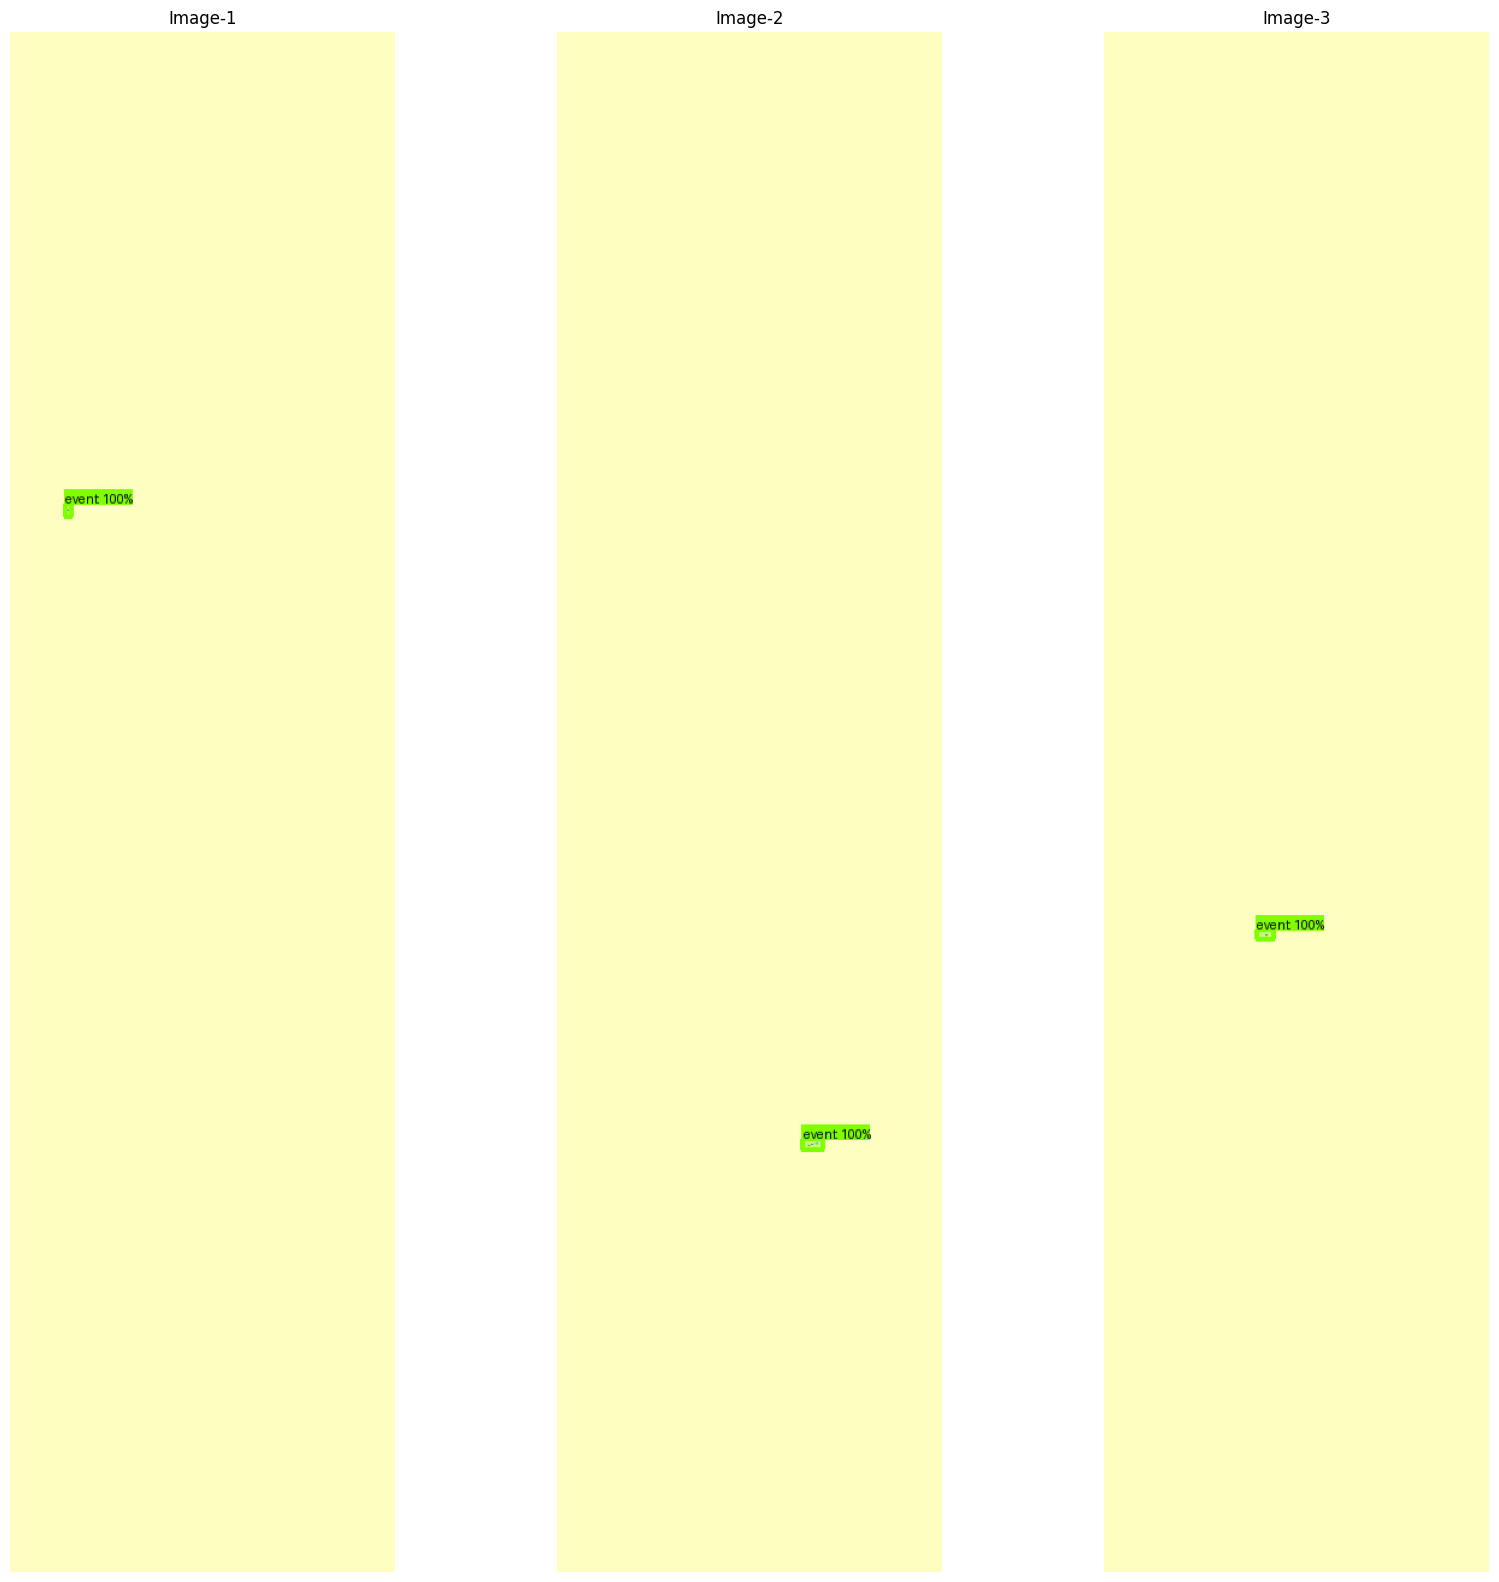

In [19]:
buffer_size = 10
num_of_examples = 3

train_tfrecords = tf.io.gfile.glob(exp_config.task.train_data.input_path)
raw_records = tf.data.TFRecordDataset(train_tfrecords).shuffle(buffer_size=buffer_size).take(num_of_examples)
show_batch(raw_records)

2024-11-07 18:58:04.870432: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


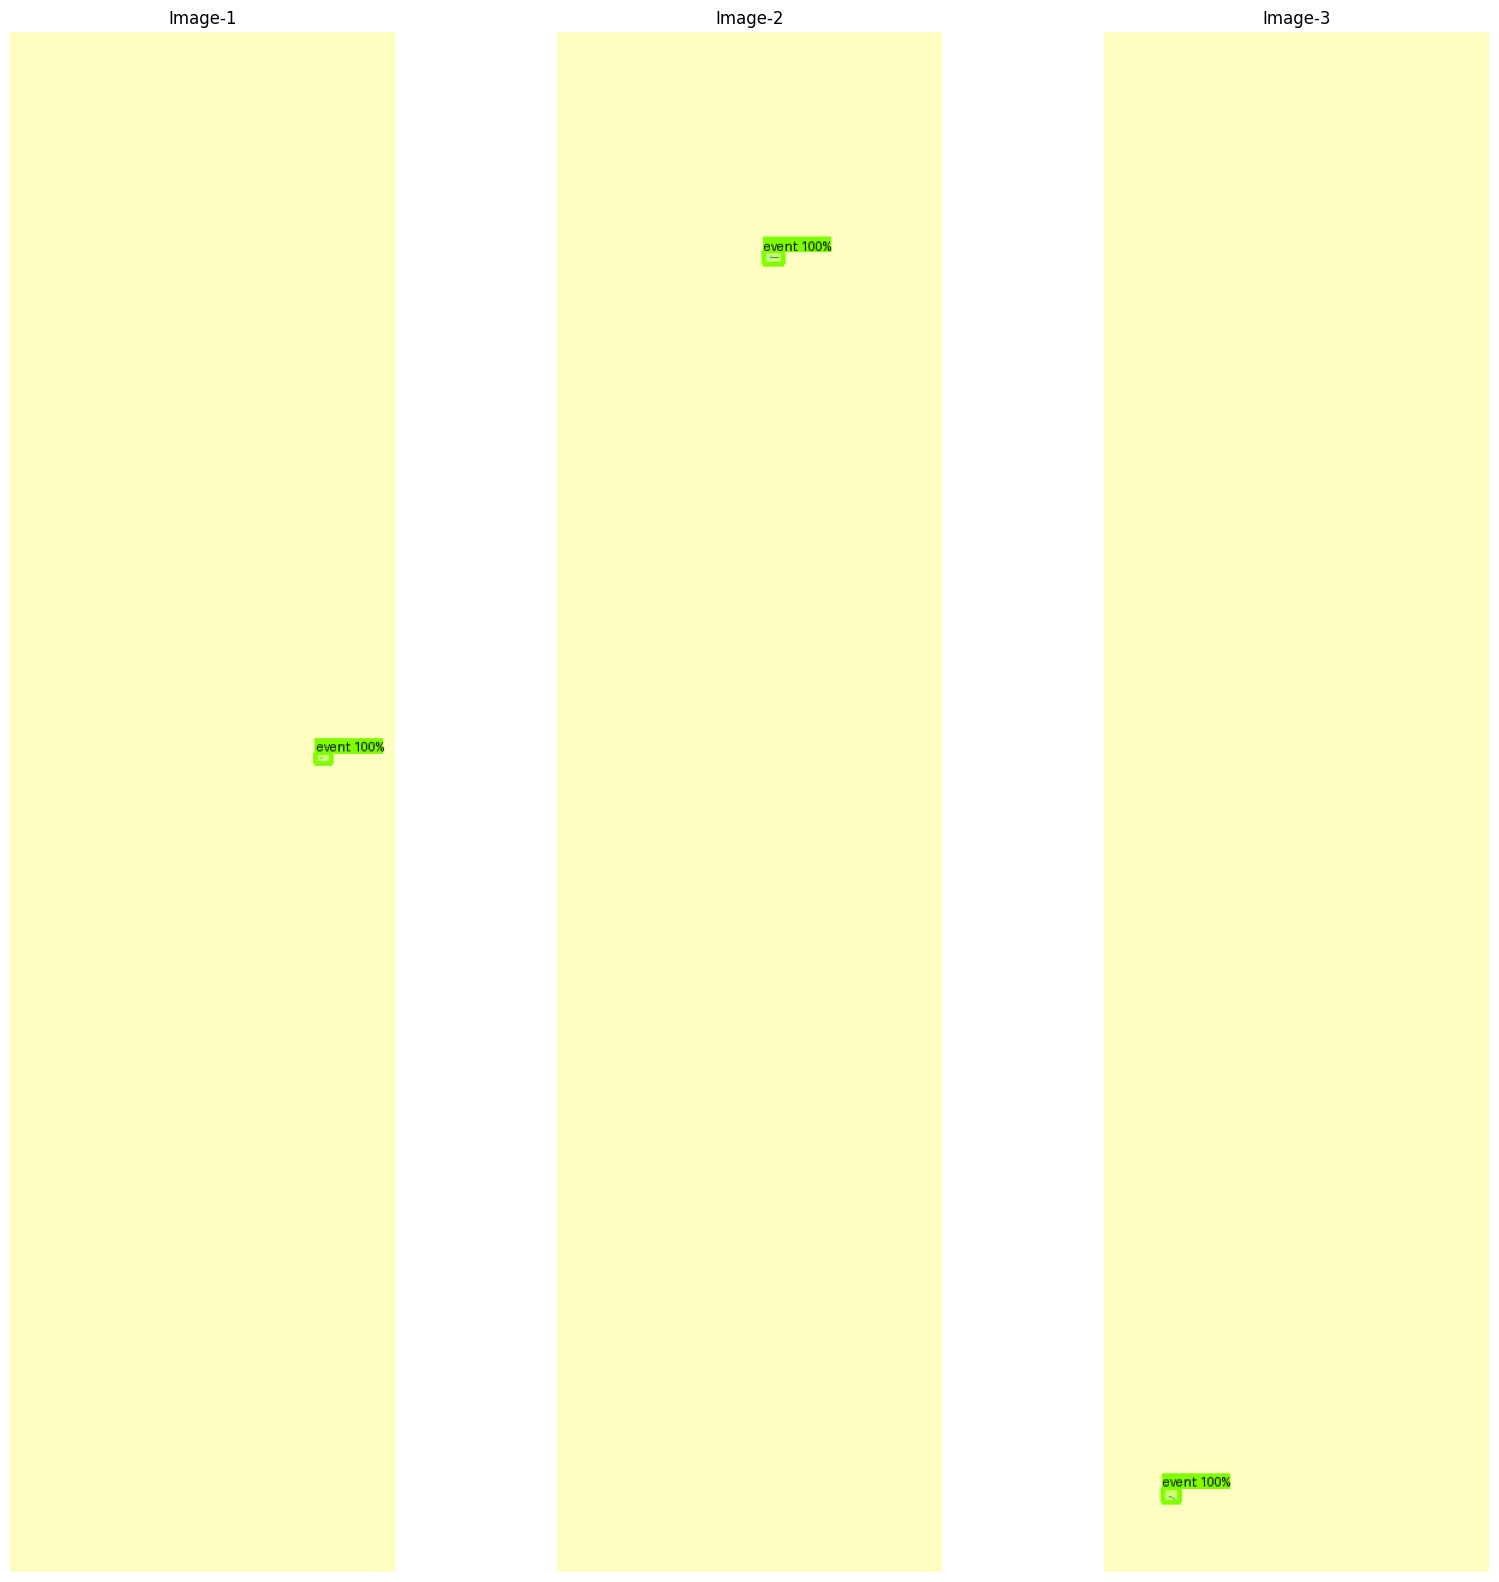

In [20]:
buffer_size = 10
num_of_examples = 3

val_tfrecords = tf.io.gfile.glob(exp_config.task.validation_data.input_path)
raw_records = tf.data.TFRecordDataset(val_tfrecords).shuffle(buffer_size=buffer_size).take(num_of_examples)
show_batch(raw_records)

## Train and evaluate

We follow the COCO challenge tradition to evaluate the accuracy of object detection based on mAP(mean Average Precision). Please check [here](https://cocodataset.org/#detection-eval) for detail explanation of how evaluation metrics for detection task is done.

**IoU**: is defined as the area of the intersection divided by the area of the union of a predicted bounding box and ground truth bounding box.

In [21]:
model, eval_logs = tfm.core.train_lib.run_experiment(
    distribution_strategy=distribution_strategy,
    task=task,
    mode='train_and_eval',
    params=exp_config,
    model_dir=model_dir,
    run_post_eval=True)

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


/home/jennetd/.conda/envs/instance-seg-2/lib/python3.10/site-packages/tf_keras/src/engine/functional.py:641: UserWarning: Input dict contained keys ['6'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)
/home/jennetd/.conda/envs/instance-seg-2/lib/python3.10/site-packages/tf_keras/src/initializers/initializers.py:121: UserWarning: The initializer VarianceScaling is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


Instructions for updating:
Use fn_output_signature instead


Instructions for updating:
Use fn_output_signature instead


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
restoring or initializing model...
restored model from /uscms/home/jennetd/nobackup/smart-pixels/instance-segmentation/my_trained_model/ckpt-100.
restored from checkpoint: /uscms/home/jennetd/nobackup/smart-pixels/instance-segmentation/my_trained_model/ckpt-100
 eval | step:    100 | running 2 steps of evaluation...


W0000 00:00:1731005900.212849   58711 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "CropAndResize" attr { key: "T" value { type: DT_FLOAT } } attr { key: "extrapolation_value" value { f: 0 } } attr { key: "method" value { s: "bilinear" } } inputs { dtype: DT_FLOAT shape { dim { size: -5 } dim { size: -6 } dim { size: -7 } dim { size: 1 } } } inputs { dtype: DT_FLOAT shape { dim { size: -2 } dim { size: 4 } } } inputs { dtype: DT_INT32 shape { dim { size: -2 } } } inputs { dtype: DT_INT32 shape { dim { size: 2 } } value { dtype: DT_INT32 tensor_shape { dim { size: 2 } } int_val: 112 } } device { type: "CPU" vendor: "AuthenticAMD" model: "241" frequency: 2799 num_cores: 127 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 65536 l2_cache_size: 524288 l3_cache_size: 16777216 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { dim { size: -2 } dim { size

creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.03s).
Accumulating evaluation results...
DONE (t=0.00s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.

## Load logs in tensorboard

## Saving and exporting the trained model

The `keras.Model` object returned by `train_lib.run_experiment` expects the data to be normalized by the dataset loader using the same mean and variance statiscics in `preprocess_ops.normalize_image(image, offset=MEAN_RGB, scale=STDDEV_RGB)`. This export function handles those details, so you can pass `tf.uint8` images and get the correct results.

In [22]:
export_saved_model_lib.export_inference_graph(
    input_type='image_tensor',
    batch_size=1,
    input_image_size=[HEIGHT, WIDTH],
    params=exp_config,
    checkpoint_path=tf.train.latest_checkpoint(model_dir),
    export_dir=export_dir)

/home/jennetd/.conda/envs/instance-seg-2/lib/python3.10/site-packages/tf_keras/src/engine/functional.py:641: UserWarning: Input dict contained keys ['6'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


INFO:tensorflow:Assets written to: /uscms/home/jennetd/nobackup/smart-pixels/instance-segmentation/my_exported_model/assets


INFO:tensorflow:Assets written to: /uscms/home/jennetd/nobackup/smart-pixels/instance-segmentation/my_exported_model/assets


## Inference from Trained Model

In [23]:
def load_image_into_numpy_array(path):
  """Load an image from file into a numpy array.

  Puts image into numpy array to feed into tensorflow graph.
  Note that by convention we put it into a numpy array with shape
  (height, width, channels), where channels=3 for RGB.

  Args:
    path: the file path to the image

  Returns:
    uint8 numpy array with shape (img_height, img_width, 3)
  """
  image = None
  if(path.startswith('http')):
    response = urlopen(path)
    image_data = response.read()
    image_data = BytesIO(image_data)
    image = Image.open(image_data)
  else:
    image_data = tf.io.gfile.GFile(path, 'rb').read()
    image = Image.open(BytesIO(image_data))

  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (1, im_height, im_width, 3)).astype(np.uint8)



def build_inputs_for_object_detection(image, input_image_size):
  """Builds Object Detection model inputs for serving."""
  image, _ = resize_and_crop_image(
      image,
      input_image_size,
      padded_size=input_image_size,
      aug_scale_min=1.0,
      aug_scale_max=1.0)
  return image

## Visualize test data

## Importing SavedModel

In [24]:
imported = tf.saved_model.load(export_dir)
model_fn = imported.signatures['serving_default']

## Visualize predictions

In [44]:
input_image_size = (HEIGHT, WIDTH)

def show_prediction(raw_records):
  plt.figure(figsize=(20, 20))
  use_normalized_coordinates=True
  min_score_thresh = 0.00
  for i, serialized_example in enumerate(raw_records):
    plt.subplot(1, 3, i + 1)
    decoded_tensors = tf_ex_decoder.decode(serialized_example)
      
    image = build_inputs_for_object_detection(decoded_tensors['image'], input_image_size)
      
    image = tf.expand_dims(image, axis=0)
    image = tf.cast(image, dtype = tf.uint8)
    image_np = image[0].numpy()
      
    result = model_fn(image)
      
    scores = np.ones(shape=(len(decoded_tensors['groundtruth_boxes'])))
    
    visualization_utils.visualize_boxes_and_labels_on_image_array(
        image_np,
        decoded_tensors['groundtruth_boxes'].numpy(),
        decoded_tensors['groundtruth_classes'].numpy().astype('int'),
        scores,
        category_index=category_index,
        use_normalized_coordinates=use_normalized_coordinates,
        min_score_thresh=min_score_thresh,
        #instance_masks=decoded_tensors['groundtruth_instance_masks'].numpy().astype('uint8'),
        line_thickness=4)

    visualization_utils.visualize_boxes_and_labels_on_image_array(
        image_np,
        result['detection_boxes'][0].numpy(),
        (result['detection_classes'][0] + 0).numpy().astype(int),
        result['detection_scores'][0].numpy(),
        category_index=category_index,
        use_normalized_coordinates=use_normalized_coordinates,
        max_boxes_to_draw=3,
        min_score_thresh=0.4,
        instance_masks=result.get('detection_masks_reframed', None),
        line_thickness=4)

    plt.imshow(image_np)
    plt.axis("off")
    plt.title(f"Image-{i+1}")
  plt.show()

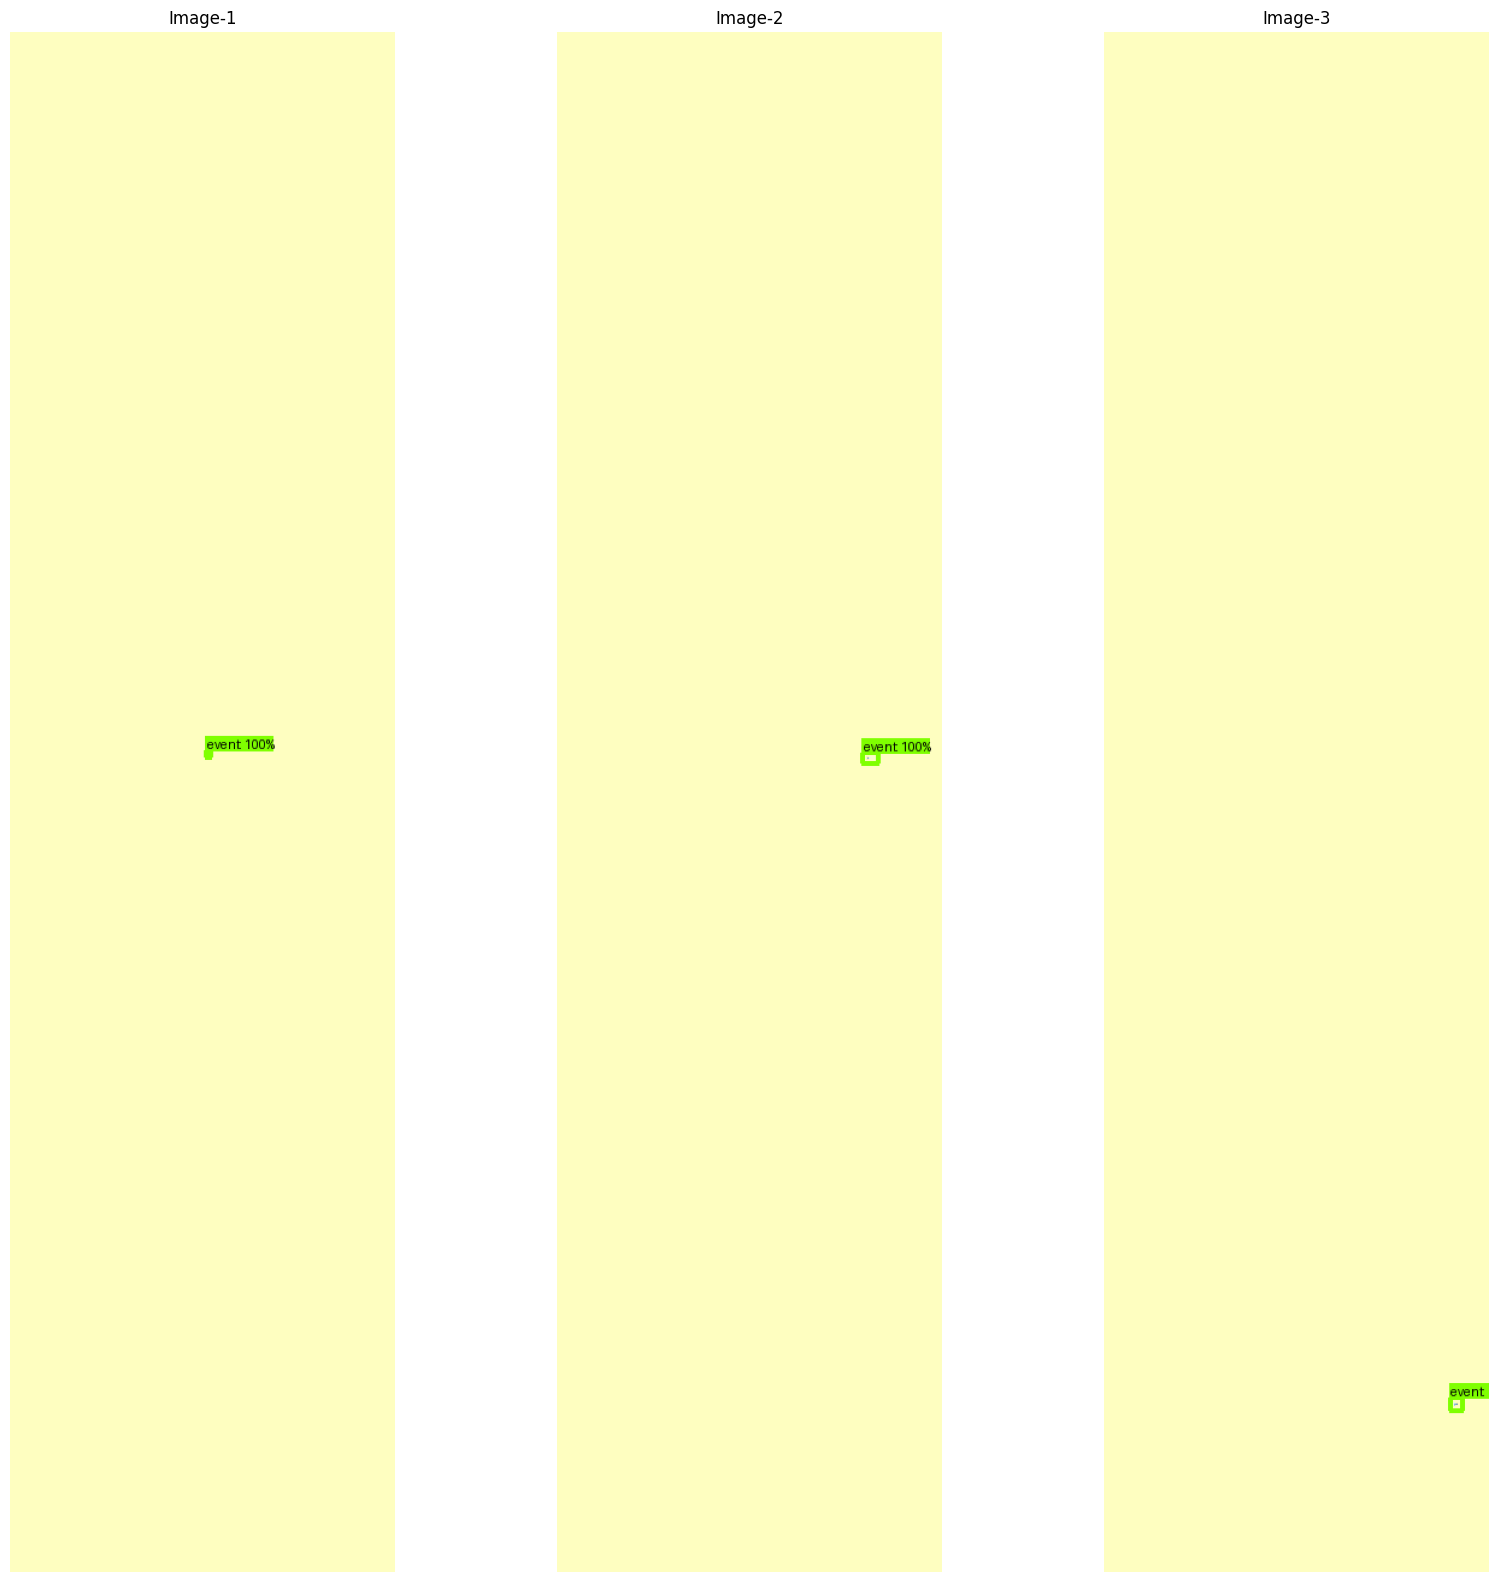

In [45]:
# Cheating and visualizing val data
test_ds = tf.data.TFRecordDataset(val_tfrecords).take(num_of_examples)
show_prediction(test_ds)